<a href="https://colab.research.google.com/github/Adarshmanepalli/Master_Thesis/blob/main/Thesis_Models_CombinedDataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Models Used

##Input 128x128 images directly then downsizing to 64x64 before feeding to our model but without KD and BH values

1 Physical GPUs, 1 Logical GPUs
Loading combined data...
Loading data for Quercus_robur...
Loading data for Carpinus_betulus...
Loading data for Acer_campestre...
Loading data for Tilia_cordata...
Loading data for Betula_pendula...
Loading data for Alnus_glutinosa...
Loading data for Acer_pseudoplatanus...
Loading data for Fagus_sylvatica...
Loading data for Fraxinus_excelsior...
Loading data for Acer_platanoides...
Loaded 25000 images with shape (25000, 64, 64, 4).
Splitting data into training and testing sets...
Data splitting completed. Training set size: 20000, Testing set size: 5000
Shape of X_train_img: (20000, 64, 64, 4)
Shape of y_train: (20000,)
Shape of X_test_img: (5000, 64, 64, 4)
Shape of y_test: (5000,)
Any NaN values in X_train_img: False
Any Inf values in X_train_img: False
Any NaN values in y_train: False
Any Inf values in y_train: False
Creating model with input size (64, 64, 4) and 10 classes...
Model: "model_1"
_______________________________________________________

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved as /content/drive/MyDrive/MainDataFolder/AIModels/RGBI_ONLY_128x128_combined_model.h5
Evaluating model...
40/40 [==============================] - 0s 5ms/step
Model - Accuracy: 0.5212
Model - Classification Report:
157/157 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.33      0.31      0.32       493
           1       0.52      0.52      0.52       502
           2       0.34      0.36      0.35       485
           3       0.57      0.71      0.64       491
           4       0.59      0.84      0.69       494
           5       0.61      0.28      0.39       528
           6       0.56      0.57      0.56       504
           7       0.54      0.38      0.44       503
           8       0.46      0.65      0.54       493
           9       0.77      0.61      0.68       507

    accuracy                           0.52      5000
   macro avg       0.53      0.52      0.51      5000
weighted avg  

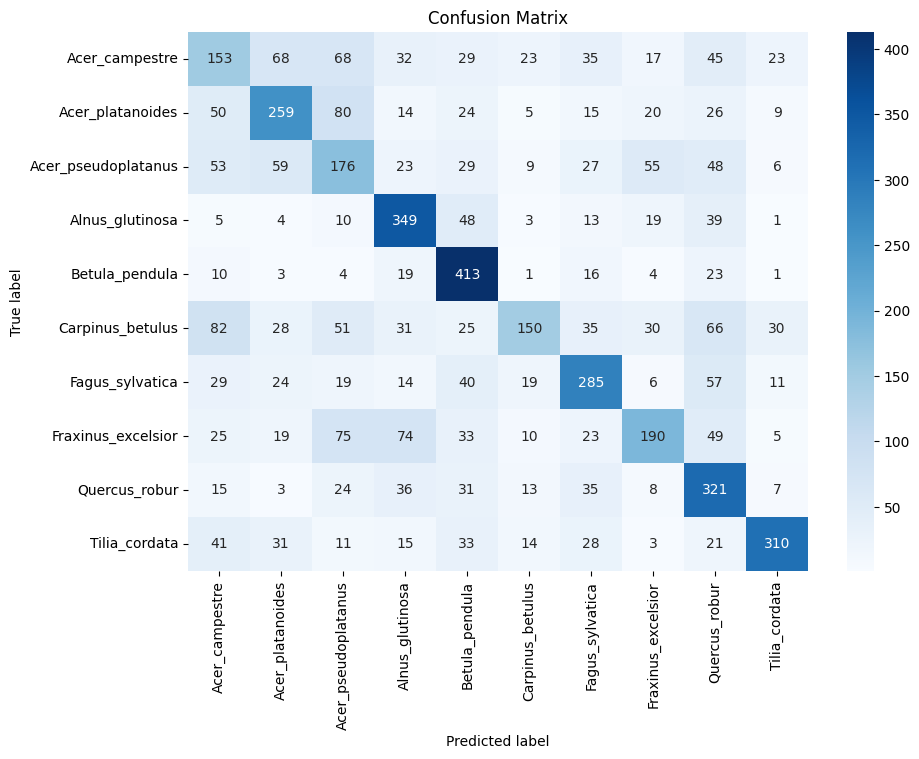

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from pathlib import Path
from tensorflow.image import resize
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Set up GPU memory growth
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

# Enable mixed precision training
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

# Define paths
base_path = "/content/drive/MyDrive/MainDataFolder/CombinedDataset"
species = ['Quercus_robur', 'Carpinus_betulus', 'Acer_campestre', 'Tilia_cordata',
           'Betula_pendula', 'Alnus_glutinosa', 'Acer_pseudoplatanus',
           'Fagus_sylvatica', 'Fraxinus_excelsior', 'Acer_platanoides']

# Load data from .npy files and downsample to 64x64
def load_data(target_size=(64, 64)):
    images = []
    labels = []
    for specie in species:
        print(f"Loading data for {specie}...")
        specie_images = np.load(Path(base_path) / f"{specie}_RGBI_combined.npy")
        specie_labels = np.load(Path(base_path) / f"{specie}_label_combined.npy")

        # Sample 2500 instances from each species
        indices = np.random.choice(len(specie_images), 2500, replace=False)
        specie_images_sampled = specie_images[indices]

        # Downsample images to target size
        specie_images_resized = np.array([resize(img, target_size).numpy() / 255.0 for img in specie_images_sampled])

        images.append(specie_images_resized)
        labels.append(specie_labels[indices])

    images = np.concatenate(images)
    labels = np.concatenate(labels)
    return images, labels

# Load combined data
print("Loading combined data...")
rgb_images, labels = load_data()

# Encode labels
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

print(f"Loaded {len(rgb_images)} images with shape {rgb_images.shape}.")

# Split data into training and testing sets
print("Splitting data into training and testing sets...")
X_train_img, X_test_img, y_train, y_test = train_test_split(rgb_images, labels, test_size=0.2, random_state=42)

print(f"Data splitting completed. Training set size: {len(X_train_img)}, Testing set size: {len(X_test_img)}")
print(f"Shape of X_train_img: {X_train_img.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of X_test_img: {X_test_img.shape}")
print(f"Shape of y_test: {y_test.shape}")

# Check for NaN and Inf values
print(f"Any NaN values in X_train_img: {np.isnan(X_train_img).any()}")
print(f"Any Inf values in X_train_img: {np.isinf(X_train_img).any()}")
print(f"Any NaN values in y_train: {np.isnan(y_train).any()}")
print(f"Any Inf values in y_train: {np.isinf(y_train).any()}")

# Define a CNN model
def combined_model(input_image_size=(64, 64, 4), num_classes=10):
    # Image input branch
    image_input = Input(shape=input_image_size, name='image_input')
    x = Conv2D(32, (3, 3), activation='relu')(image_input)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu')(x)
    x = GlobalAveragePooling2D()(x)

    combined = Dense(128, activation='relu')(x)
    combined = Dropout(0.5)(combined)
    output = Dense(num_classes, activation='softmax')(combined)

    # Model definition
    model = Model(inputs=image_input, outputs=output)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Create and train the model
input_image_size = X_train_img.shape[1:]
num_classes = len(np.unique(y_train))
print(f"Creating model with input size {input_image_size} and {num_classes} classes...")
model = combined_model(input_image_size=input_image_size, num_classes=num_classes)
model.summary()

checkpoint_filepath = '/content/drive/MyDrive/MainDataFolder/checkpoints/RGBI_ONLY_128x128/combined_model_checkpoint.h5'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True
)

early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

print("Training model...")
try:
    history = model.fit(
        X_train_img, y_train,
        validation_data=(X_test_img, y_test),
        epochs=50, batch_size=32,
        callbacks=[model_checkpoint_callback, early_stopping_callback]
    )
    print("Model training completed.")
except tf.errors.InvalidArgumentError as e:
    print(f"Error during training: {e}")

# Save the model
model_save_path = "/content/drive/MyDrive/MainDataFolder/AIModels/RGBI_ONLY_128x128_combined_model.h5"
model.save(model_save_path)
print(f"Model saved as {model_save_path}")

# Evaluate the model
def evaluate_model(model, images, labels, batch_size=128):
    preds = model.predict(images, batch_size=batch_size)
    preds_labels = np.argmax(preds, axis=1)

    accuracy = accuracy_score(labels, preds_labels)
    cm = confusion_matrix(labels, preds_labels)
    report = classification_report(labels, preds_labels, output_dict=True)
    return accuracy, cm, report

print("Evaluating model...")
accuracy, cm, report = evaluate_model(model, X_test_img, y_test)

print(f"Model - Accuracy: {accuracy}")
print("Model - Classification Report:")
print(classification_report(y_test, np.argmax(model.predict(X_test_img), axis=1)))

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()


##Input 128x128 images directly then downsizing to 64x64 before feeding to our model but without KD and BH values and incorporating data augmentation, regularization techniques, and learning rate adjustments

Physical devices cannot be modified after being initialized
Loading combined data...
Loading data for Quercus_robur...
Loading data for Carpinus_betulus...
Loading data for Acer_campestre...
Loading data for Tilia_cordata...
Loading data for Betula_pendula...
Loading data for Alnus_glutinosa...
Loading data for Acer_pseudoplatanus...
Loading data for Fagus_sylvatica...
Loading data for Fraxinus_excelsior...
Loading data for Acer_platanoides...
Loaded 25000 images with shape (25000, 64, 64, 4).
Splitting data into training and testing sets...
Data splitting completed. Training set size: 20000, Testing set size: 5000
Shape of X_train_img: (20000, 64, 64, 4)
Shape of y_train: (20000,)
Shape of X_test_img: (5000, 64, 64, 4)
Shape of y_test: (5000,)
Any NaN values in X_train_img: False
Any Inf values in X_train_img: False
Any NaN values in y_train: False
Any Inf values in y_train: False
Creating model with input size (64, 64, 4) and 10 classes...
Model: "model_3"
___________________________

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved as /content/drive/MyDrive/MainDataFolder/AIModels/RGBI_ONLY_WITH_DAUG_128x128_combined_model.h5
Training history saved as /content/drive/MyDrive/MainDataFolder/AIModels/History/RGBI_ONLY_WITH_DAUG_128x128_2500_EP50_history.npz
Evaluating model...
40/40 [==============================] - 1s 5ms/step
Model - Accuracy: 0.2446
Model - Classification Report:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


157/157 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.25      0.00      0.00       493
           1       0.23      0.34      0.27       502
           2       0.20      0.00      0.00       485
           3       0.23      0.57      0.33       491
           4       0.37      0.56      0.45       494
           5       0.17      0.41      0.24       528
           6       0.00      0.00      0.00       504
           7       0.13      0.11      0.12       503
           8       0.00      0.00      0.00       493
           9       0.39      0.43      0.41       507

    accuracy                           0.24      5000
   macro avg       0.20      0.24      0.18      5000
weighted avg       0.20      0.24      0.18      5000



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


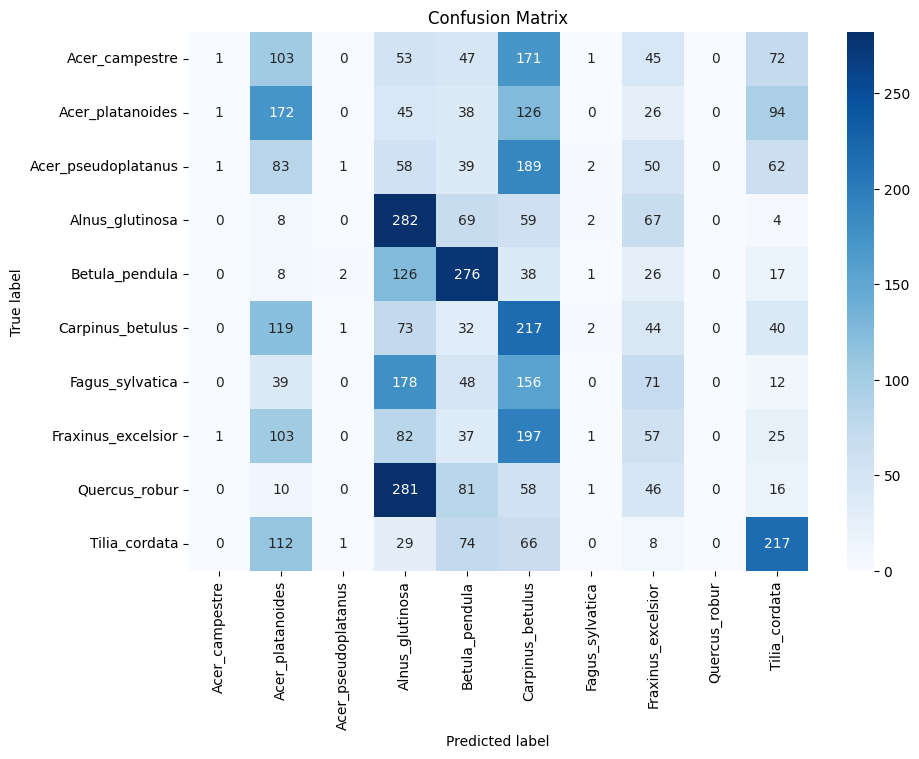

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from pathlib import Path
from tensorflow.image import resize
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Set up GPU memory growth
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

# Enable mixed precision training
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

# Define paths
base_path = "/content/drive/MyDrive/MainDataFolder/CombinedDataset"
species = ['Quercus_robur', 'Carpinus_betulus', 'Acer_campestre', 'Tilia_cordata',
           'Betula_pendula', 'Alnus_glutinosa', 'Acer_pseudoplatanus',
           'Fagus_sylvatica', 'Fraxinus_excelsior', 'Acer_platanoides']

# Load data from .npy files and downsample to 64x64
def load_data(target_size=(64, 64)):
    images = []
    labels = []
    for specie in species:
        print(f"Loading data for {specie}...")
        specie_images = np.load(Path(base_path) / f"{specie}_RGBI_combined.npy")
        specie_labels = np.load(Path(base_path) / f"{specie}_label_combined.npy")

        # Sample 2500 instances from each species
        indices = np.random.choice(len(specie_images), 2500, replace=False)
        specie_images_sampled = specie_images[indices]

        # Downsample images to target size
        specie_images_resized = np.array([resize(img, target_size).numpy() / 255.0 for img in specie_images_sampled])

        images.append(specie_images_resized)
        labels.append(specie_labels[indices])

    images = np.concatenate(images)
    labels = np.concatenate(labels)
    return images, labels

# Load combined data
print("Loading combined data...")
rgb_images, labels = load_data()

# Encode labels
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

print(f"Loaded {len(rgb_images)} images with shape {rgb_images.shape}.")

# Split data into training and testing sets
print("Splitting data into training and testing sets...")
X_train_img, X_test_img, y_train, y_test = train_test_split(rgb_images, labels, test_size=0.2, random_state=42)

print(f"Data splitting completed. Training set size: {len(X_train_img)}, Testing set size: {len(X_test_img)}")
print(f"Shape of X_train_img: {X_train_img.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of X_test_img: {X_test_img.shape}")
print(f"Shape of y_test: {y_test.shape}")

# Check for NaN and Inf values
print(f"Any NaN values in X_train_img: {np.isnan(X_train_img).any()}")
print(f"Any Inf values in X_train_img: {np.isinf(X_train_img).any()}")
print(f"Any NaN values in y_train: {np.isnan(y_train).any()}")
print(f"Any Inf values in y_train: {np.isinf(y_train).any()}")

# Define a CNN model with regularization and dropout
def combined_model(input_image_size=(64, 64, 4), num_classes=10):
    # Image input branch
    image_input = Input(shape=input_image_size, name='image_input')
    x = Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4))(image_input)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4))(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4))(x)
    x = GlobalAveragePooling2D()(x)

    combined = Dense(128, activation='relu', kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4))(x)
    combined = Dropout(0.5)(combined)
    output = Dense(num_classes, activation='softmax')(combined)

    # Model definition
    model = Model(inputs=image_input, outputs=output)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Create and train the model
input_image_size = X_train_img.shape[1:]
num_classes = len(np.unique(y_train))
print(f"Creating model with input size {input_image_size} and {num_classes} classes...")
model = combined_model(input_image_size=input_image_size, num_classes=num_classes)
model.summary()

checkpoint_filepath = '/content/drive/MyDrive/MainDataFolder/checkpoints/RGBI_ONLY_WITH_DAUG_128x128/combined_model_checkpoint.h5'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True
)

early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

# Create data augmentation generator
data_augmentation = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Apply data augmentation to the training data
train_generator = data_augmentation.flow(X_train_img, y_train, batch_size=32)

print("Training model...")
try:
    history = model.fit(
        train_generator,
        validation_data=(X_test_img, y_test),
        epochs=50,
        callbacks=[model_checkpoint_callback, early_stopping_callback, reduce_lr]
    )
    print("Model training completed.")
except tf.errors.InvalidArgumentError as e:
    print(f"Error during training: {e}")

# Save the model
model_save_path = "/content/drive/MyDrive/MainDataFolder/AIModels/RGBI_ONLY_WITH_DAUG_128x128_combined_model.h5"
model.save(model_save_path)
print(f"Model saved as {model_save_path}")

history_save_path = "/content/drive/MyDrive/MainDataFolder/AIModels/History/RGBI_ONLY_WITH_DAUG_128x128_2500_EP50_history.npz"
np.savez(history_save_path, history.history)
print(f"Training history saved as {history_save_path}")

# Evaluate the model
def evaluate_model(model, images, labels, batch_size=128):
    preds = model.predict(images, batch_size=batch_size)
    preds_labels = np.argmax(preds, axis=1)

    accuracy = accuracy_score(labels, preds_labels)
    cm = confusion_matrix(labels, preds_labels)
    report = classification_report(labels, preds_labels, output_dict=True)
    return accuracy, cm, report

print("Evaluating model...")
accuracy, cm, report = evaluate_model(model, X_test_img, y_test)

print(f"Model - Accuracy: {accuracy}")
print("Model - Classification Report:")
print(classification_report(y_test, np.argmax(model.predict(X_test_img), axis=1)))

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

## Input 2500 128x128 images directly then downsizing to 64x64 before feeding to our model but for only RGBI data!!


Physical devices cannot be modified after being initialized
Loading combined data...
Loading data for Quercus_robur...
Loading data for Carpinus_betulus...
Loading data for Acer_campestre...
Loading data for Tilia_cordata...
Loading data for Betula_pendula...
Loading data for Alnus_glutinosa...
Loading data for Acer_pseudoplatanus...
Loading data for Fagus_sylvatica...
Loading data for Fraxinus_excelsior...
Loading data for Acer_platanoides...
Loaded 25000 images with shape (25000, 64, 64, 4).
Splitting data into training and testing sets...
Data splitting completed. Training set size: 20000, Testing set size: 5000
Shape of X_train_img: (20000, 64, 64, 4)
Shape of y_train: (20000,)
Shape of X_test_img: (5000, 64, 64, 4)
Shape of y_test: (5000,)
Any NaN values in X_train_img: False
Any Inf values in X_train_img: False
Any NaN values in y_train: False
Any Inf values in y_train: False
Creating model with input size (64, 64, 4) and 10 classes...
Model: "model_4"
___________________________

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved as /content/drive/MyDrive/MainDataFolder/AIModels/V2RGBI_Only_128x128_2500_combined_model.h5
Training history saved as /content/drive/MyDrive/MainDataFolder/AIModels/History/RGBI_Only_128x128_2500_EP50_history.npz
Evaluating model...
40/40 [==============================] - 0s 5ms/step
Model - Accuracy: 0.5472
Model - Classification Report:
157/157 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.34      0.29      0.31       493
           1       0.60      0.46      0.52       502
           2       0.43      0.22      0.29       485
           3       0.68      0.69      0.69       491
           4       0.68      0.79      0.73       494
           5       0.47      0.52      0.49       528
           6       0.50      0.67      0.57       504
           7       0.49      0.51      0.50       503
           8       0.53      0.59      0.56       493
           9       0.67      0.72      0.69      

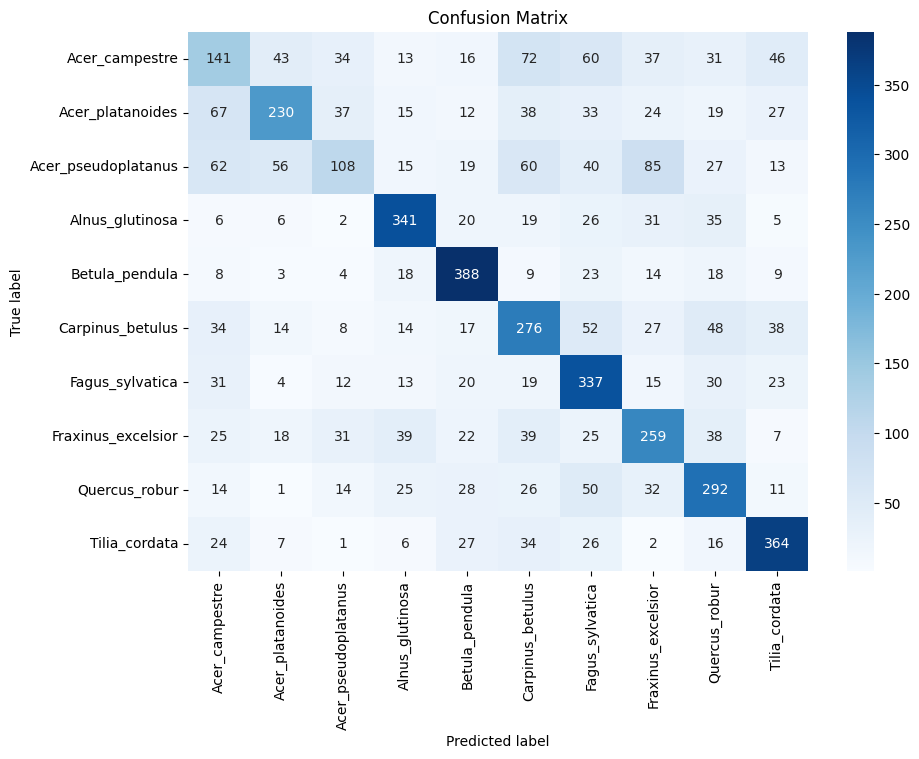

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from pathlib import Path
from tensorflow.image import resize
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Set up GPU memory growth
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

# Enable mixed precision training
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

# Define paths
base_path = "/content/drive/MyDrive/MainDataFolder/CombinedDataset"
species = ['Quercus_robur', 'Carpinus_betulus', 'Acer_campestre', 'Tilia_cordata',
           'Betula_pendula', 'Alnus_glutinosa', 'Acer_pseudoplatanus',
           'Fagus_sylvatica', 'Fraxinus_excelsior', 'Acer_platanoides']

# Load data from .npy files and downsample to 64x64
def load_data(target_size=(64, 64)):
    images = []
    labels = []
    for specie in species:
        print(f"Loading data for {specie}...")
        specie_images = np.load(Path(base_path) / f"{specie}_RGBI_combined.npy")
        specie_labels = np.load(Path(base_path) / f"{specie}_label_combined.npy")

        # Sample 2500 instances from each species
        indices = np.random.choice(len(specie_images), 2500, replace=False)
        specie_images_sampled = specie_images[indices]

        # Downsample images to target size
        specie_images_resized = np.array([resize(img, target_size).numpy() / 255.0 for img in specie_images_sampled])

        images.append(specie_images_resized)
        labels.append(specie_labels[indices])

    images = np.concatenate(images)
    labels = np.concatenate(labels)
    return images, labels

# Load combined data
print("Loading combined data...")
rgb_images, labels = load_data()

# Encode labels
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

print(f"Loaded {len(rgb_images)} images with shape {rgb_images.shape}.")

# Split data into training and testing sets
print("Splitting data into training and testing sets...")
X_train_img, X_test_img, y_train, y_test = train_test_split(rgb_images, labels, test_size=0.2, random_state=42)

print(f"Data splitting completed. Training set size: {len(X_train_img)}, Testing set size: {len(X_test_img)}")
print(f"Shape of X_train_img: {X_train_img.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of X_test_img: {X_test_img.shape}")
print(f"Shape of y_test: {y_test.shape}")

# Check for NaN and Inf values
print(f"Any NaN values in X_train_img: {np.isnan(X_train_img).any()}")
print(f"Any Inf values in X_train_img: {np.isinf(X_train_img).any()}")
print(f"Any NaN values in y_train: {np.isnan(y_train).any()}")
print(f"Any Inf values in y_train: {np.isinf(y_train).any()}")

# Define a CNN model
def combined_model(input_image_size=(64, 64, 4), num_classes=10):
    # Image input branch
    image_input = Input(shape=input_image_size, name='image_input')
    x = Conv2D(32, (3, 3), activation='relu')(image_input)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu')(x)
    x = GlobalAveragePooling2D()(x)

    combined = Dense(128, activation='relu')(x)
    combined = Dropout(0.5)(combined)
    output = Dense(num_classes, activation='softmax')(combined)

    # Model definition
    model = Model(inputs=image_input, outputs=output)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Create and train the model
input_image_size = X_train_img.shape[1:]
num_classes = len(np.unique(y_train))
print(f"Creating model with input size {input_image_size} and {num_classes} classes...")
model = combined_model(input_image_size=input_image_size, num_classes=num_classes)
model.summary()

checkpoint_filepath = '/content/drive/MyDrive/MainDataFolder/checkpoints/RGBI_ONLY_128x128_2500/combined_model_checkpoint.h5'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True
)

early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

print("Training model...")
try:
    history = model.fit(
        X_train_img, y_train,
        validation_data=(X_test_img, y_test),
        epochs=50, batch_size=32,
        callbacks=[model_checkpoint_callback, early_stopping_callback]
    )
    print("Model training completed.")
except tf.errors.InvalidArgumentError as e:
    print(f"Error during training: {e}")

# Save the model
model_save_path = "/content/drive/MyDrive/MainDataFolder/AIModels/V2RGBI_Only_128x128_2500_combined_model.h5"
model.save(model_save_path)
print(f"Model saved as {model_save_path}")

history_save_path = "/content/drive/MyDrive/MainDataFolder/AIModels/History/RGBI_Only_128x128_2500_EP50_history.npz"
np.savez(history_save_path, history.history)
print(f"Training history saved as {history_save_path}")

# Evaluate the model
def evaluate_model(model, images, labels, batch_size=128):
    preds = model.predict(images, batch_size=batch_size)
    preds_labels = np.argmax(preds, axis=1)

    accuracy = accuracy_score(labels, preds_labels)
    cm = confusion_matrix(labels, preds_labels)
    report = classification_report(labels, preds_labels, output_dict=True)
    return accuracy, cm, report

print("Evaluating model...")
accuracy, cm, report = evaluate_model(model, X_test_img, y_test)

print(f"Model - Accuracy: {accuracy}")
print("Model - Classification Report:")
print(classification_report(y_test, np.argmax(model.predict(X_test_img), axis=1)))

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()


##Input 64x64 images so no need for downsampling but without KD and BH values

1 Physical GPUs, 1 Logical GPUs
Loading combined data...
Loading data for Quercus_robur...
Loading data for Carpinus_betulus...
Loading data for Acer_campestre...
Loading data for Tilia_cordata...
Loading data for Betula_pendula...
Loading data for Alnus_glutinosa...
Loading data for Acer_pseudoplatanus...
Loading data for Fagus_sylvatica...
Loading data for Fraxinus_excelsior...
Loading data for Acer_platanoides...
Loaded 55359 images with shape (55359, 64, 64, 4).
Splitting data into training and testing sets...
Data splitting completed. Training set size: 44287, Testing set size: 11072
Shape of X_train_img: (44287, 64, 64, 4)
Shape of y_train: (44287,)
Shape of X_test_img: (11072, 64, 64, 4)
Shape of y_test: (11072,)
Data type of X_train_img: float32
Data type of y_train: int32
Data type of X_test_img: float32
Data type of y_test: int32
Any NaN values in X_train_img: False
Any Inf values in X_train_img: False
Any NaN values in y_train: False
Any Inf values in y_train: False
Creating

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


87/87 [==============================] - 1s 9ms/step
Model - Accuracy: 0.601878612716763
Model - Classification Report:
346/346 [==============================] - 1s 2ms/step
              precision    recall  f1-score   support

           0       0.39      0.39      0.39       985
           1       0.55      0.54      0.54       825
           2       0.44      0.35      0.39       833
           3       0.52      0.69      0.60       905
           4       0.63      0.78      0.69       625
           5       0.63      0.57      0.60      1885
           6       0.58      0.37      0.45       558
           7       0.55      0.27      0.36       574
           8       0.68      0.79      0.73      2879
           9       0.76      0.71      0.73      1003

    accuracy                           0.60     11072
   macro avg       0.57      0.55      0.55     11072
weighted avg       0.60      0.60      0.59     11072



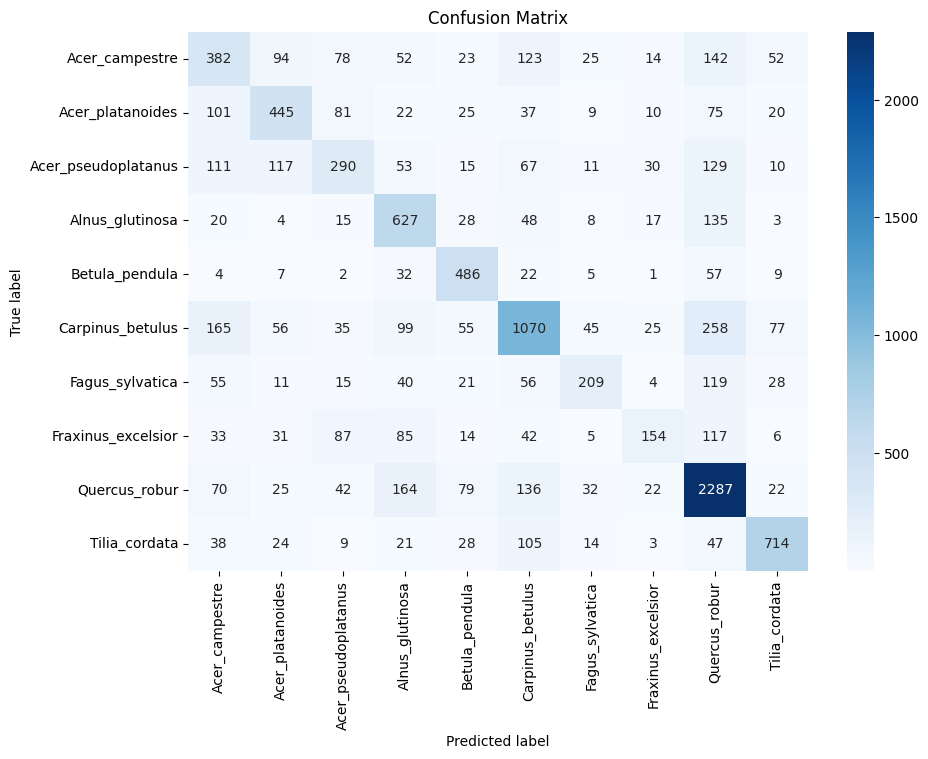

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from pathlib import Path
from tensorflow.image import resize
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Set up GPU memory growth
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

# Enable mixed precision training
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

# Define paths
base_path_64 = "/content/drive/MyDrive/MainDataFolder/CombinedDataset64"
species = ['Quercus_robur', 'Carpinus_betulus', 'Acer_campestre', 'Tilia_cordata',
           'Betula_pendula', 'Alnus_glutinosa', 'Acer_pseudoplatanus',
           'Fagus_sylvatica', 'Fraxinus_excelsior', 'Acer_platanoides']

# Load data from .npy files
def load_data():
    images = []
    labels = []
    for specie in species:
        print(f"Loading data for {specie}...")
        images.append(np.load(Path(base_path_64) / f"{specie}_RGBI_combined.npy"))
        labels.append(np.load(Path(base_path_64) / f"{specie}_label_combined.npy"))
    images = np.concatenate(images)
    labels = np.concatenate(labels)
    return images, labels

# Load combined data
print("Loading combined data...")
rgb_images, labels = load_data()

# Encode labels
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

print(f"Loaded {len(rgb_images)} images with shape {rgb_images.shape}.")

# Split data into training and testing sets
print("Splitting data into training and testing sets...")
X_train_img, X_test_img, y_train, y_test = train_test_split(rgb_images, labels, test_size=0.2, random_state=42)

print(f"Data splitting completed. Training set size: {len(X_train_img)}, Testing set size: {len(X_test_img)}")

print(f"Shape of X_train_img: {X_train_img.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of X_test_img: {X_test_img.shape}")
print(f"Shape of y_test: {y_test.shape}")

# Normalize the images
X_train_img = X_train_img.astype('float32') / 255.0
X_test_img = X_test_img.astype('float32') / 255.0

# Ensure labels are in the correct format
y_train = y_train.astype('int32')
y_test = y_test.astype('int32')

print(f"Data type of X_train_img: {X_train_img.dtype}")
print(f"Data type of y_train: {y_train.dtype}")
print(f"Data type of X_test_img: {X_test_img.dtype}")
print(f"Data type of y_test: {y_test.dtype}")

# Check for NaN and Inf values
print(f"Any NaN values in X_train_img: {np.isnan(X_train_img).any()}")
print(f"Any Inf values in X_train_img: {np.isinf(X_train_img).any()}")
print(f"Any NaN values in y_train: {np.isnan(y_train).any()}")
print(f"Any Inf values in y_train: {np.isinf(y_train).any()}")

# Define a CNN model
def combined_model(input_image_size=(64, 64, 4), num_classes=10):
    # Image input branch
    image_input = Input(shape=input_image_size, name='image_input')
    x = Conv2D(32, (3, 3), activation='relu')(image_input)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu')(x)
    x = GlobalAveragePooling2D()(x)

    combined = Dense(128, activation='relu')(x)
    combined = Dropout(0.5)(combined)
    output = Dense(num_classes, activation='softmax')(combined)

    # Model definition
    model = Model(inputs=image_input, outputs=output)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Create and train the model
input_image_size = X_train_img.shape[1:]
num_classes = len(np.unique(y_train))
print(f"Creating model with input size {input_image_size} and {num_classes} classes...")
model = combined_model(input_image_size=input_image_size, num_classes=num_classes)
model.summary()

checkpoint_filepath = '/content/drive/MyDrive/MainDataFolder/checkpoints/RGBI_ONLY_64x64/combined_model_checkpoint.h5'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True
)

early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

print("Training model...")
try:
    history = model.fit(
        X_train_img, y_train,
        validation_data=(X_test_img, y_test),
        epochs=50, batch_size=32,
        callbacks=[model_checkpoint_callback, early_stopping_callback]
    )
    print("Model training completed.")
except tf.errors.InvalidArgumentError as e:
    print(f"Error during training: {e}")

# Save the model
model_save_path = "/content/drive/MyDrive/MainDataFolder/AIModels/RGBI_ONLY_64x64_combined_model.h5"
model.save(model_save_path)
print(f"Model saved as {model_save_path}")

# Evaluate the model
def evaluate_model(model, images, labels, batch_size=128):
    preds = model.predict(images, batch_size=batch_size)
    preds_labels = np.argmax(preds, axis=1)

    accuracy = accuracy_score(labels, preds_labels)
    cm = confusion_matrix(labels, preds_labels)
    report = classification_report(labels, preds_labels, output_dict=True)
    return accuracy, cm, report

print("Evaluating model...")
accuracy, cm, report = evaluate_model(model, X_test_img, y_test)

print(f"Model - Accuracy: {accuracy}")
print("Model - Classification Report:")
print(classification_report(y_test, np.argmax(model.predict(X_test_img), axis=1)))

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()


## Input 2500 64x64 images directly but only with RGBI data no KD and BH values feeding to our model


Physical devices cannot be modified after being initialized
Loading combined data...
Loading data for Quercus_robur...
Loading data for Carpinus_betulus...
Loading data for Acer_campestre...
Loading data for Tilia_cordata...
Loading data for Betula_pendula...
Loading data for Alnus_glutinosa...
Loading data for Acer_pseudoplatanus...
Loading data for Fagus_sylvatica...
Loading data for Fraxinus_excelsior...
Loading data for Acer_platanoides...
Loaded 25000 images with shape (25000, 64, 64, 4).
Splitting data into training and testing sets...
Data splitting completed. Training set size: 20000, Testing set size: 5000
Shape of X_train_img: (20000, 64, 64, 4)
Shape of y_train: (20000,)
Shape of X_test_img: (5000, 64, 64, 4)
Shape of y_test: (5000,)
Any NaN values in X_train_img: False
Any Inf values in X_train_img: False
Any NaN values in y_train: False
Any Inf values in y_train: False
Creating model with input size (64, 64, 4) and 10 classes...
Model: "model_5"
___________________________

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved as /content/drive/MyDrive/MainDataFolder/AIModels/RGBI_ONLY_64x64_2500_combined_model.h5
Training history saved as /content/drive/MyDrive/MainDataFolder/AIModels/History/RGBI_ONLY_64x64_2500_EP50_history.npz
Evaluating model...
40/40 [==============================] - 0s 5ms/step
Model - Accuracy: 0.494
Model - Classification Report:
157/157 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.35      0.21      0.27       493
           1       0.43      0.54      0.48       502
           2       0.40      0.23      0.29       485
           3       0.43      0.70      0.53       491
           4       0.62      0.75      0.68       494
           5       0.45      0.43      0.44       528
           6       0.51      0.49      0.50       504
           7       0.62      0.40      0.49       503
           8       0.50      0.45      0.48       493
           9       0.58      0.72      0.64       507

 

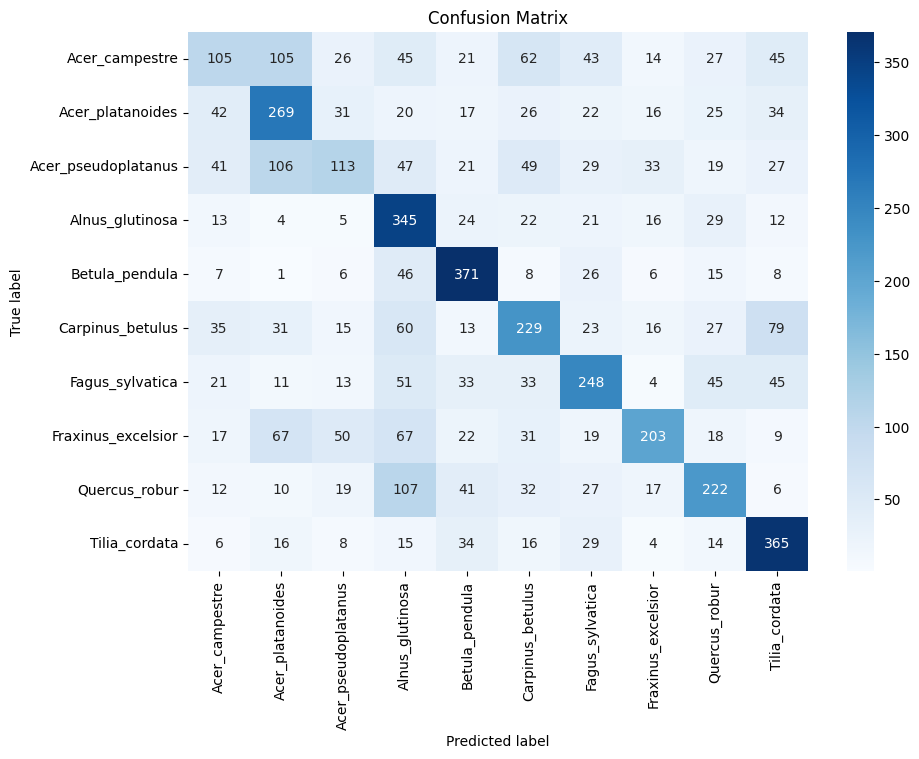

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from pathlib import Path
from tensorflow.image import resize
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Set up GPU memory growth
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

# Enable mixed precision training
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

# Define paths
base_path_64 = "/content/drive/MyDrive/MainDataFolder/CombinedDataset64"
species = ['Quercus_robur', 'Carpinus_betulus', 'Acer_campestre', 'Tilia_cordata',
           'Betula_pendula', 'Alnus_glutinosa', 'Acer_pseudoplatanus',
           'Fagus_sylvatica', 'Fraxinus_excelsior', 'Acer_platanoides']

# Load data from .npy files
def load_data():
    images = []
    labels = []
    for specie in species:
        print(f"Loading data for {specie}...")
        specie_images = np.load(Path(base_path_64) / f"{specie}_RGBI_combined.npy")
        specie_labels = np.load(Path(base_path_64) / f"{specie}_label_combined.npy")

        # Sample 2500 instances from each species
        indices = np.random.choice(len(specie_images), 2500, replace=False)
        images.append(specie_images[indices])
        labels.append(specie_labels[indices])

    images = np.concatenate(images)
    labels = np.concatenate(labels)
    return images, labels

# Load combined data
print("Loading combined data...")
rgb_images, labels = load_data()

# Encode labels
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

print(f"Loaded {len(rgb_images)} images with shape {rgb_images.shape}.")

# Split data into training and testing sets
print("Splitting data into training and testing sets...")
X_train_img, X_test_img, y_train, y_test = train_test_split(rgb_images, labels, test_size=0.2, random_state=42)

# Normalize the images
X_train_img = X_train_img.astype('float32') / 255.0
X_test_img = X_test_img.astype('float32') / 255.0

print(f"Data splitting completed. Training set size: {len(X_train_img)}, Testing set size: {len(X_test_img)}")
print(f"Shape of X_train_img: {X_train_img.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of X_test_img: {X_test_img.shape}")
print(f"Shape of y_test: {y_test.shape}")

# Check for NaN and Inf values
print(f"Any NaN values in X_train_img: {np.isnan(X_train_img).any()}")
print(f"Any Inf values in X_train_img: {np.isinf(X_train_img).any()}")
print(f"Any NaN values in y_train: {np.isnan(y_train).any()}")
print(f"Any Inf values in y_train: {np.isinf(y_train).any()}")

# Define a CNN model
def combined_model(input_image_size=(64, 64, 4), num_classes=10):
    # Image input branch
    image_input = Input(shape=input_image_size, name='image_input')
    x = Conv2D(32, (3, 3), activation='relu')(image_input)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu')(x)
    x = GlobalAveragePooling2D()(x)

    combined = Dense(128, activation='relu')(x)
    combined = Dropout(0.5)(combined)
    output = Dense(num_classes, activation='softmax')(combined)

    # Model definition
    model = Model(inputs=image_input, outputs=output)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Create and train the model
input_image_size = X_train_img.shape[1:]
num_classes = len(np.unique(y_train))
print(f"Creating model with input size {input_image_size} and {num_classes} classes...")
model = combined_model(input_image_size=input_image_size, num_classes=num_classes)
model.summary()

checkpoint_filepath = '/content/drive/MyDrive/MainDataFolder/checkpoints/RGBI_ONLY_64x64_2500/combined_model_checkpoint.h5'

model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True
)

early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

print("Training model...")
try:
    history = model.fit(
        X_train_img, y_train,
        validation_data=(X_test_img, y_test),
        epochs=50, batch_size=32,
        callbacks=[model_checkpoint_callback, early_stopping_callback]
    )
    print("Model training completed.")
except tf.errors.InvalidArgumentError as e:
    print(f"Error during training: {e}")

# Save the model
model_save_path = "/content/drive/MyDrive/MainDataFolder/AIModels/RGBI_ONLY_64x64_2500_combined_model.h5"
model.save(model_save_path)
print(f"Model saved as {model_save_path}")

history_save_path = "/content/drive/MyDrive/MainDataFolder/AIModels/History/RGBI_ONLY_64x64_2500_EP50_history.npz"
np.savez(history_save_path, history.history)
print(f"Training history saved as {history_save_path}")

# Evaluate the model
def evaluate_model(model, images, labels, batch_size=128):
    preds = model.predict(images, batch_size=batch_size)
    preds_labels = np.argmax(preds, axis=1)

    accuracy = accuracy_score(labels, preds_labels)
    cm = confusion_matrix(labels, preds_labels)
    report = classification_report(labels, preds_labels, output_dict=True)
    return accuracy, cm, report

print("Evaluating model...")
accuracy, cm, report = evaluate_model(model, X_test_img, y_test)

print(f"Model - Accuracy: {accuracy}")
print("Model - Classification Report:")
print(classification_report(y_test, np.argmax(model.predict(X_test_img), axis=1)))

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()


##Input 32x32 images sp we need to upsample it to match the input size but without KD and BH values

1 Physical GPUs, 1 Logical GPUs
Loading combined data...
Loading data for Quercus_robur...
Loading data for Carpinus_betulus...
Loading data for Acer_campestre...
Loading data for Tilia_cordata...
Loading data for Betula_pendula...
Loading data for Alnus_glutinosa...
Loading data for Acer_pseudoplatanus...
Loading data for Fagus_sylvatica...
Loading data for Fraxinus_excelsior...
Loading data for Acer_platanoides...
Upsampling images to 64x64...
Loaded 55359 images with shape (55359, 64, 64, 4).
Splitting data into training and testing sets...
Data type of X_train_img: float32
Data type of y_train: int32
Data type of X_test_img: float32
Data type of y_test: int32
Any NaN values in X_train_img: False
Any Inf values in X_train_img: False
Any NaN values in y_train: False
Any Inf values in y_train: False
Creating model with input size (64, 64, 4) and 10 classes...
Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape   

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


87/87 [==============================] - 0s 5ms/step
Model - Accuracy: 0.5080382947976878
Model - Classification Report:
346/346 [==============================] - 1s 2ms/step
              precision    recall  f1-score   support

           0       0.33      0.19      0.24       985
           1       0.56      0.35      0.43       825
           2       0.43      0.09      0.14       833
           3       0.41      0.54      0.47       905
           4       0.57      0.71      0.63       625
           5       0.42      0.59      0.49      1885
           6       0.39      0.25      0.30       558
           7       0.47      0.20      0.28       574
           8       0.61      0.72      0.66      2879
           9       0.58      0.69      0.63      1003

    accuracy                           0.51     11072
   macro avg       0.48      0.43      0.43     11072
weighted avg       0.50      0.51      0.48     11072



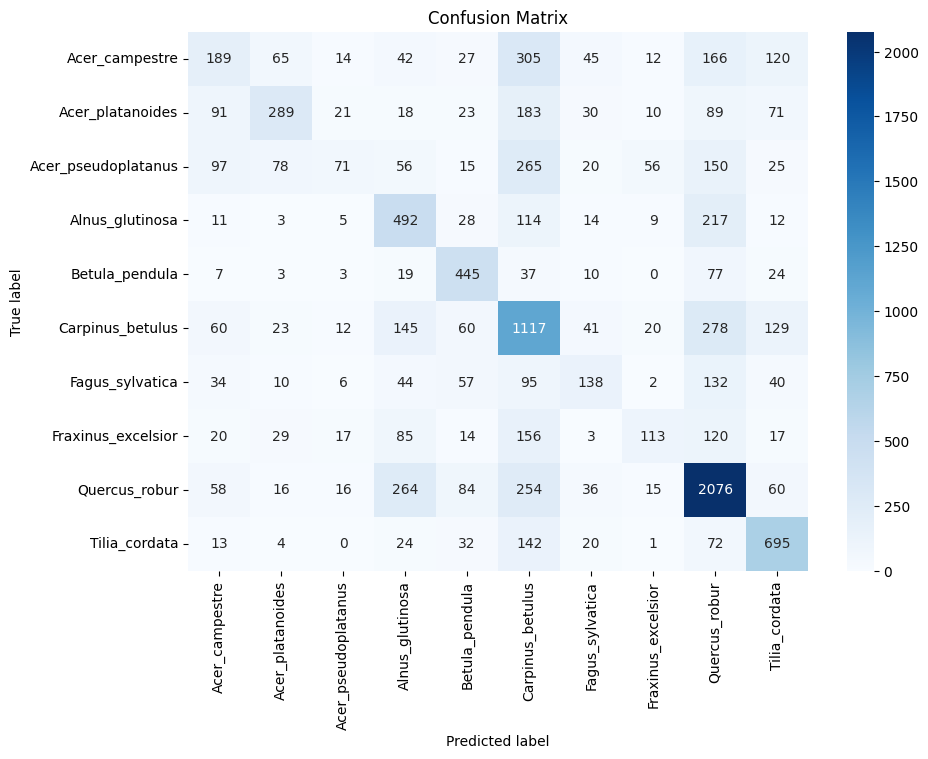

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from pathlib import Path
from tensorflow.image import resize
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Set up GPU memory growth
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

# Enable mixed precision training
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

# Define paths
base_path_32 = "/content/drive/MyDrive/MainDataFolder/CombinedDataset32"
base_path = "/content/drive/MyDrive/MainDataFolder/CombinedDataset"
species = ['Quercus_robur', 'Carpinus_betulus', 'Acer_campestre', 'Tilia_cordata',
           'Betula_pendula', 'Alnus_glutinosa', 'Acer_pseudoplatanus',
           'Fagus_sylvatica', 'Fraxinus_excelsior', 'Acer_platanoides']

# Load data from .npy files
def load_data():
    images = []
    labels = []
    for specie in species:
        print(f"Loading data for {specie}...")
        images.append(np.load(Path(base_path_32) / f"{specie}_RGBI_combined.npy"))
        labels.append(np.load(Path(base_path) / f"{specie}_label_combined.npy"))
    images = np.concatenate(images)
    labels = np.concatenate(labels)
    return images, labels

# Load combined data
print("Loading combined data...")
rgb_images, labels = load_data()

# Upsample images to 64x64
print("Upsampling images to 64x64...")
rgb_images_resized = np.array([resize(img, [64, 64]).numpy() for img in rgb_images])

# Encode labels
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

print(f"Loaded {len(rgb_images_resized)} images with shape {rgb_images_resized.shape}.")

# Split data into training and testing sets
print("Splitting data into training and testing sets...")
X_train_img, X_test_img, y_train, y_test = train_test_split(rgb_images_resized, labels, test_size=0.2, random_state=42)

# Normalize the images
X_train_img = X_train_img.astype('float32') / 255.0
X_test_img = X_test_img.astype('float32') / 255.0

# Ensure labels are in the correct format
y_train = y_train.astype('int32')
y_test = y_test.astype('int32')

print(f"Data type of X_train_img: {X_train_img.dtype}")
print(f"Data type of y_train: {y_train.dtype}")
print(f"Data type of X_test_img: {X_test_img.dtype}")
print(f"Data type of y_test: {y_test.dtype}")

# Check for NaN and Inf values
print(f"Any NaN values in X_train_img: {np.isnan(X_train_img).any()}")
print(f"Any Inf values in X_train_img: {np.isinf(X_train_img).any()}")
print(f"Any NaN values in y_train: {np.isnan(y_train).any()}")
print(f"Any Inf values in y_train: {np.isinf(y_train).any()}")

# Define a CNN model
def combined_model(input_image_size=(64, 64, 4), num_classes=10):
    # Image input branch
    image_input = Input(shape=input_image_size, name='image_input')
    x = Conv2D(32, (3, 3), activation='relu')(image_input)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu')(x)
    x = GlobalAveragePooling2D()(x)

    combined = Dense(128, activation='relu')(x)
    combined = Dropout(0.5)(combined)
    output = Dense(num_classes, activation='softmax')(combined)

    # Model definition
    model = Model(inputs=image_input, outputs=output)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Create and train the model
input_image_size = X_train_img.shape[1:]
num_classes = len(np.unique(y_train))
print(f"Creating model with input size {input_image_size} and {num_classes} classes...")
model = combined_model(input_image_size=input_image_size, num_classes=num_classes)
model.summary()

checkpoint_filepath = '/content/drive/MyDrive/MainDataFolder/checkpoints/RGBI_ONLY_32x32/combined_model_checkpoint.h5'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True
)

early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

print("Training model...")
try:
    history = model.fit(
        X_train_img, y_train,
        validation_data=(X_test_img, y_test),
        epochs=50, batch_size=32,
        callbacks=[model_checkpoint_callback, early_stopping_callback]
    )
    print("Model training completed.")
except tf.errors.InvalidArgumentError as e:
    print(f"Error during training: {e}")

# Save the model
model_save_path = "/content/drive/MyDrive/MainDataFolder/AIModels/RGBI_ONLY_32x32combined_model.h5"
model.save(model_save_path)
print(f"Model saved as {model_save_path}")

# Evaluate the model
def evaluate_model(model, images, labels, batch_size=128):
    preds = model.predict(images, batch_size=batch_size)
    preds_labels = np.argmax(preds, axis=1)

    accuracy = accuracy_score(labels, preds_labels)
    cm = confusion_matrix(labels, preds_labels)
    report = classification_report(labels, preds_labels, output_dict=True)
    return accuracy, cm, report

print("Evaluating model...")
accuracy, cm, report = evaluate_model(model, X_test_img, y_test)

print(f"Model - Accuracy: {accuracy}")
print("Model - Classification Report:")
print(classification_report(y_test, np.argmax(model.predict(X_test_img), axis=1)))

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()


##Input 2500 32x32 images directly then Upsampling to 64x64 but only with RGBI data and no KD and BH values before feeding to our model

Physical devices cannot be modified after being initialized
Loading combined data...
Loading data for Quercus_robur...
Loading data for Carpinus_betulus...
Loading data for Acer_campestre...
Loading data for Tilia_cordata...
Loading data for Betula_pendula...
Loading data for Alnus_glutinosa...
Loading data for Acer_pseudoplatanus...
Loading data for Fagus_sylvatica...
Loading data for Fraxinus_excelsior...
Loading data for Acer_platanoides...
Upsampling images to 64x64...
Loaded 25000 images with shape (25000, 64, 64, 4).
Splitting data into training and testing sets...
Data splitting completed. Training set size: 20000, Testing set size: 5000
Shape of X_train_img: (20000, 64, 64, 4)
Shape of y_train: (20000,)
Shape of X_test_img: (5000, 64, 64, 4)
Shape of y_test: (5000,)
Any NaN values in X_train_img: False
Any Inf values in X_train_img: False
Any NaN values in y_train: False
Any Inf values in y_train: False
Creating model with input size (64, 64, 4) and 10 classes...
Model: "model_

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved as /content/drive/MyDrive/MainDataFolder/AIModels/RGBI_ONLY_32x32_2500_combined_model.h5
Training history saved as /content/drive/MyDrive/MainDataFolder/AIModels/History/RGBI_ONLY_32x32_2500_EP50_history.npz
Evaluating model...
40/40 [==============================] - 0s 5ms/step
Model - Accuracy: 0.4416
Model - Classification Report:
157/157 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.32      0.14      0.19       493
           1       0.46      0.39      0.42       502
           2       0.25      0.26      0.26       485
           3       0.39      0.65      0.48       491
           4       0.65      0.65      0.65       494
           5       0.41      0.29      0.34       528
           6       0.47      0.48      0.47       504
           7       0.33      0.45      0.38       503
           8       0.47      0.52      0.49       493
           9       0.70      0.61      0.65       507



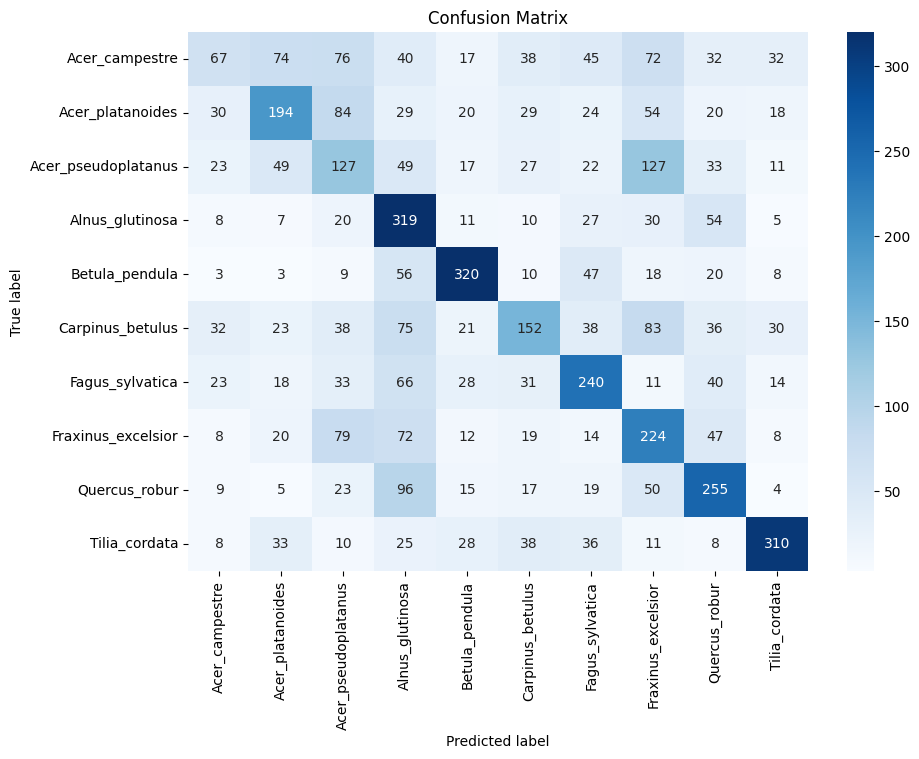

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from pathlib import Path
from tensorflow.image import resize
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Set up GPU memory growth
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

# Enable mixed precision training
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

# Define paths
base_path_32 = "/content/drive/MyDrive/MainDataFolder/CombinedDataset32"
species = ['Quercus_robur', 'Carpinus_betulus', 'Acer_campestre', 'Tilia_cordata',
           'Betula_pendula', 'Alnus_glutinosa', 'Acer_pseudoplatanus',
           'Fagus_sylvatica', 'Fraxinus_excelsior', 'Acer_platanoides']

# Load data from .npy files
def load_data():
    images = []
    labels = []
    for specie in species:
        print(f"Loading data for {specie}...")
        specie_images = np.load(Path(base_path_32) / f"{specie}_RGBI_combined.npy")
        specie_labels = np.load(Path(base_path_32) / f"{specie}_label_combined.npy")

        # Sample 2500 instances from each species
        indices = np.random.choice(len(specie_images), 2500, replace=False)
        images.append(specie_images[indices])
        labels.append(specie_labels[indices])

    images = np.concatenate(images)
    labels = np.concatenate(labels)
    return images, labels

# Load combined data
print("Loading combined data...")
rgb_images, labels = load_data()

# Upsample images to 64x64
print("Upsampling images to 64x64...")
rgb_images_resized = np.array([resize(img, [64, 64]).numpy() for img in rgb_images])

# Encode labels
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

print(f"Loaded {len(rgb_images_resized)} images with shape {rgb_images_resized.shape}.")

# Split data into training and testing sets
print("Splitting data into training and testing sets...")
X_train_img, X_test_img, y_train, y_test = train_test_split(rgb_images_resized, labels, test_size=0.2, random_state=42)

# Normalize the images
X_train_img = X_train_img.astype('float32') / 255.0
X_test_img = X_test_img.astype('float32') / 255.0

print(f"Data splitting completed. Training set size: {len(X_train_img)}, Testing set size: {len(X_test_img)}")
print(f"Shape of X_train_img: {X_train_img.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of X_test_img: {X_test_img.shape}")
print(f"Shape of y_test: {y_test.shape}")

# Check for NaN and Inf values
print(f"Any NaN values in X_train_img: {np.isnan(X_train_img).any()}")
print(f"Any Inf values in X_train_img: {np.isinf(X_train_img).any()}")
print(f"Any NaN values in y_train: {np.isnan(y_train).any()}")
print(f"Any Inf values in y_train: {np.isinf(y_train).any()}")

# Define a CNN model
def combined_model(input_image_size=(64, 64, 4), num_classes=10):
    # Image input branch
    image_input = Input(shape=input_image_size, name='image_input')
    x = Conv2D(32, (3, 3), activation='relu')(image_input)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu')(x)
    x = GlobalAveragePooling2D()(x)

    combined = Dense(128, activation='relu')(x)
    combined = Dropout(0.5)(combined)
    output = Dense(num_classes, activation='softmax')(combined)

    # Model definition
    model = Model(inputs=image_input, outputs=output)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Create and train the model
input_image_size = X_train_img.shape[1:]
num_classes = len(np.unique(y_train))
print(f"Creating model with input size {input_image_size} and {num_classes} classes...")
model = combined_model(input_image_size=input_image_size, num_classes=num_classes)
model.summary()

checkpoint_filepath = '/content/drive/MyDrive/MainDataFolder/checkpoints/RGBI_ONLY_32x32_2500/combined_model_checkpoint.h5'

model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True
)

early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

print("Training model...")
try:
    history = model.fit(
        X_train_img, y_train,
        validation_data=(X_test_img, y_test),
        epochs=50, batch_size=32,
        callbacks=[model_checkpoint_callback, early_stopping_callback]
    )
    print("Model training completed.")
except tf.errors.InvalidArgumentError as e:
    print(f"Error during training: {e}")

# Save the model
model_save_path = "/content/drive/MyDrive/MainDataFolder/AIModels/RGBI_ONLY_32x32_2500_combined_model.h5"
model.save(model_save_path)
print(f"Model saved as {model_save_path}")

history_save_path = "/content/drive/MyDrive/MainDataFolder/AIModels/History/RGBI_ONLY_32x32_2500_EP50_history.npz"
np.savez(history_save_path, history.history)
print(f"Training history saved as {history_save_path}")

# Evaluate the model
def evaluate_model(model, images, labels, batch_size=128):
    preds = model.predict(images, batch_size=batch_size)
    preds_labels = np.argmax(preds, axis=1)

    accuracy = accuracy_score(labels, preds_labels)
    cm = confusion_matrix(labels, preds_labels)
    report = classification_report(labels, preds_labels, output_dict=True)
    return accuracy, cm, report

print("Evaluating model...")
accuracy, cm, report = evaluate_model(model, X_test_img, y_test)

print(f"Model - Accuracy: {accuracy}")
print("Model - Classification Report:")
print(classification_report(y_test, np.argmax(model.predict(X_test_img), axis=1)))

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()


## Resnet50 with 2500 sample from each species for 'RGBI' bands with Data Augmentation,Learning Rate Adjustment and Early Stopping

In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Concatenate, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.image import resize
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define paths
base_path = "/content/drive/MyDrive/MainDataFolder/CombinedDataset"
species = ['Quercus_robur', 'Carpinus_betulus', 'Acer_campestre', 'Tilia_cordata',
           'Betula_pendula', 'Alnus_glutinosa', 'Acer_pseudoplatanus',
           'Fagus_sylvatica', 'Fraxinus_excelsior', 'Acer_platanoides']

# Load data from .npy files and downsample to 64x64
def load_data(target_size=(64, 64)):
    images = []
    ir_data = []
    labels = []
    for specie in species:
        print(f"Loading data for {specie}...")
        specie_images = np.load(Path(base_path) / f"{specie}_RGBI_combined.npy")
        specie_labels = np.load(Path(base_path) / f"{specie}_label_combined.npy")

        # Sample 2500 instances from each species
        indices = np.random.choice(len(specie_images), 2500, replace=False)
        specie_images_sampled = specie_images[indices]

        # Downsample images to target size
        specie_images_resized = np.array([resize(img[:, :, :3], target_size).numpy() / 255.0 for img in specie_images_sampled])
        specie_ir_resized = np.array([resize(img[:, :, 3:], target_size).numpy() / 255.0 for img in specie_images_sampled])

        images.append(specie_images_resized)
        ir_data.append(specie_ir_resized)
        labels.append(specie_labels[indices])

    images = np.concatenate(images)
    ir_data = np.concatenate(ir_data)
    labels = np.concatenate(labels)
    return images, ir_data, labels

# Load and preprocess data
print("Loading and preprocessing data...")
rgb_images, ir_images, labels = load_data()

# Encode labels
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

print(f"Loaded {len(rgb_images)} images with shape {rgb_images.shape}.")

# Split data into training and testing sets
print("Splitting data into training and testing sets...")
X_train_img, X_test_img, X_train_ir, X_test_ir, y_train, y_test = train_test_split(rgb_images, ir_images, labels_encoded, test_size=0.2, random_state=42)

print(f"Data splitting completed. Training set size: {len(X_train_img)}, Testing set size: {len(X_test_img)}")

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

class CustomDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, image_data, ir_data, labels, batch_size, datagen):
        self.image_data = image_data
        self.ir_data = ir_data
        self.labels = labels
        self.batch_size = batch_size
        self.datagen = datagen
        self.indices = np.arange(len(self.image_data))

    def __len__(self):
        return len(self.image_data) // self.batch_size

    def __getitem__(self, index):
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        batch_images = self.image_data[batch_indices]
        batch_ir = self.ir_data[batch_indices]
        batch_labels = self.labels[batch_indices]

        augmented_images = next(self.datagen.flow(batch_images, batch_size=self.batch_size, shuffle=False))
        return [augmented_images, batch_ir], batch_labels

    def on_epoch_end(self):
        np.random.shuffle(self.indices)

# Define the ResNet-50 based model
def create_resnet_model(input_image_size=(64, 64, 3), input_ir_size=(64, 64, 1), num_classes=10):
    base_model = ResNet50(include_top=False, weights='imagenet', input_shape=input_image_size)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)

    # IR input branch
    ir_input = Input(shape=input_ir_size, name='ir_input')
    ir_x = GlobalAveragePooling2D()(ir_input)

    # Combine branches
    combined = Concatenate()([x, ir_x])
    combined = Dense(128, activation='relu')(combined)
    combined = Dropout(0.5)(combined)
    output = Dense(num_classes, activation='softmax')(combined)

    model = Model(inputs=[base_model.input, ir_input], outputs=output)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Create and train the ResNet-50 model
input_image_size = X_train_img.shape[1:]
input_ir_size = X_train_ir.shape[1:]
num_classes = len(np.unique(y_train))

print(f"Creating ResNet-50 model with input sizes {input_image_size}, {input_ir_size}, and {num_classes} classes...")
model = create_resnet_model(input_image_size=input_image_size, input_ir_size=input_ir_size, num_classes=num_classes)
model.summary()

checkpoint_filepath = '/content/drive/MyDrive/MainDataFolder/checkpoints/resnet50_RGBI_Aug_2500/combined_model_checkpoint.h5'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True
)

early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

reduce_lr_callback = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=5,
    min_lr=1e-6
)

train_generator = CustomDataGenerator(X_train_img, X_train_ir, y_train, batch_size=32, datagen=datagen)
validation_data = ([X_test_img, X_test_ir], y_test)

print("Training ResNet-50 model...")
history = model.fit(
    train_generator,
    validation_data=validation_data,
    epochs=50,
    callbacks=[model_checkpoint_callback, early_stopping_callback, reduce_lr_callback]
)
print("Model training completed.")

# Save the model
model_save_path = "/content/drive/MyDrive/MainDataFolder/AIModels/resnet50_2500_RGBI_Aug_combined_model.h5"
model.save(model_save_path)
print(f"Model saved as {model_save_path}")

history_save_path = "/content/drive/MyDrive/MainDataFolder/AIModels/History/resnet50_RGBI_2500_EP50_history.npz"
np.savez(history_save_path, history.history)
print(f"Training history saved as {history_save_path}")

# Evaluate the model
def evaluate_model(model, images, irs, labels, batch_size=128):
    preds = model.predict([images, irs], batch_size=batch_size)
    preds_labels = np.argmax(preds, axis=1)

    accuracy = accuracy_score(labels, preds_labels)
    cm = confusion_matrix(labels, preds_labels)
    report = classification_report(labels, preds_labels, output_dict=True)
    return accuracy, cm, report

print("Evaluating ResNet-50 model...")
accuracy, cm, report = evaluate_model(model, X_test_img, X_test_ir, y_test)

print(f"ResNet-50 Model - Accuracy: {accuracy}")
print("ResNet-50 Model - Classification Report:")
print(classification_report(y_test, np.argmax(model.predict([X_test_img, X_test_ir]), axis=1)))

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix for ResNet-50 Model')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()


##ResNet 101 with 2500 sample from each species for RGBI bands with Data Augmentation,Learning Rate Adjustment and Early Stopping and no KD and BH values

Loading and preprocessing data...
Loading data for Quercus_robur...
Loading data for Carpinus_betulus...
Loading data for Acer_campestre...
Loading data for Tilia_cordata...
Loading data for Betula_pendula...
Loading data for Alnus_glutinosa...
Loading data for Acer_pseudoplatanus...
Loading data for Fagus_sylvatica...
Loading data for Fraxinus_excelsior...
Loading data for Acer_platanoides...
Loaded 25000 images with shape (25000, 64, 64, 3).
Splitting data into training and testing sets...
Data splitting completed. Training set size: 20000, Testing set size: 5000
Creating ResNet-101 model with input sizes (64, 64, 3), (64, 64, 1), and 10 classes...
171446536/171446536 [==============================] - 7s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 64, 64, 3)]          0  

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved as /content/drive/MyDrive/MainDataFolder/AIModels/resnet101_RGBI_2500_combined_model.h5
Evaluating ResNet-101 model...
40/40 [==============================] - 6s 58ms/step
ResNet-101 Model - Accuracy: 0.501
ResNet-101 Model - Classification Report:
157/157 [==============================] - 4s 24ms/step
              precision    recall  f1-score   support

           0       0.33      0.25      0.29       493
           1       0.52      0.51      0.52       502
           2       0.39      0.25      0.30       485
           3       0.71      0.49      0.58       491
           4       0.71      0.71      0.71       494
           5       0.56      0.36      0.44       528
           6       0.36      0.73      0.49       504
           7       0.51      0.35      0.41       503
           8       0.43      0.63      0.51       493
           9       0.64      0.72      0.68       507

    accuracy                           0.50      5000
   macro avg       0.52      0.5

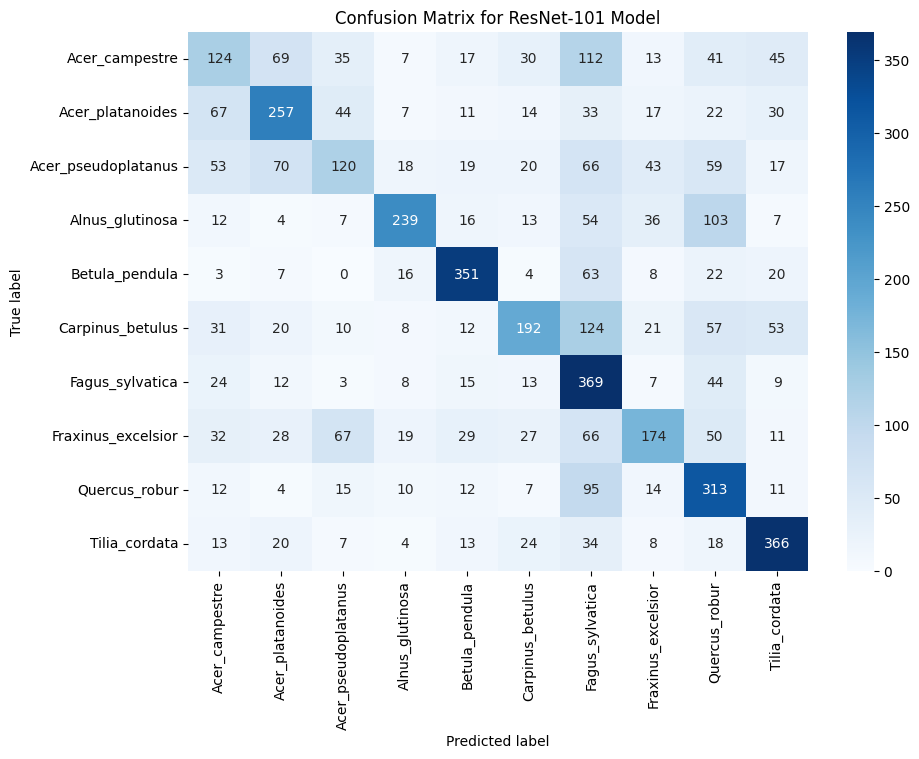

In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Concatenate, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.image import resize
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

# Define paths
base_path = "/content/drive/MyDrive/MainDataFolder/CombinedDataset"
species = ['Quercus_robur', 'Carpinus_betulus', 'Acer_campestre', 'Tilia_cordata',
           'Betula_pendula', 'Alnus_glutinosa', 'Acer_pseudoplatanus',
           'Fagus_sylvatica', 'Fraxinus_excelsior', 'Acer_platanoides']

# Load data from .npy files and downsample to 64x64
def load_data(target_size=(64, 64)):
    images = []
    ir_data = []
    labels = []
    for specie in species:
        print(f"Loading data for {specie}...")
        specie_images = np.load(Path(base_path) / f"{specie}_RGBI_combined.npy")
        specie_labels = np.load(Path(base_path) / f"{specie}_label_combined.npy")

        # Sample 2500 instances from each species
        indices = np.random.choice(len(specie_images), 2500, replace=False)
        specie_images_sampled = specie_images[indices]

        # Downsample images to target size
        specie_images_resized = np.array([resize(img[:, :, :3], target_size).numpy() / 255.0 for img in specie_images_sampled])
        specie_ir_resized = np.array([resize(img[:, :, 3:], target_size).numpy() / 255.0 for img in specie_images_sampled])

        images.append(specie_images_resized)
        ir_data.append(specie_ir_resized)
        labels.append(specie_labels[indices])

    images = np.concatenate(images)
    ir_data = np.concatenate(ir_data)
    labels = np.concatenate(labels)
    return images, ir_data, labels

# Load and preprocess data
print("Loading and preprocessing data...")
rgb_images, ir_images, labels = load_data()

# Encode labels
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

print(f"Loaded {len(rgb_images)} images with shape {rgb_images.shape}.")

# Split data into training and testing sets
print("Splitting data into training and testing sets...")
X_train_img, X_test_img, X_train_ir, X_test_ir, y_train, y_test = train_test_split(rgb_images, ir_images, labels_encoded, test_size=0.2, random_state=42)

print(f"Data splitting completed. Training set size: {len(X_train_img)}, Testing set size: {len(X_test_img)}")

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Custom data generator for multiple inputs
def custom_data_generator(datagen, X_img, X_ir, y, batch_size):
    genX1 = datagen.flow(X_img, y, batch_size=batch_size, seed=7)
    genX2 = datagen.flow(X_img, X_ir, batch_size=batch_size, seed=7)
    while True:
        X1i = genX1.next()
        X2i = genX2.next()
        yield [X1i[0], X2i[1]], X1i[1]

# Define the ResNet-101 based model
def create_resnet_model(input_image_size=(64, 64, 3), input_ir_size=(64, 64, 1), num_classes=10):
    base_model = ResNet101(include_top=False, weights='imagenet', input_shape=input_image_size)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)

    # IR input branch
    ir_input = Input(shape=input_ir_size, name='ir_input')
    ir_x = GlobalAveragePooling2D()(ir_input)

    # Combine branches
    combined = Concatenate()([x, ir_x])
    combined = Dense(128, activation='relu')(combined)
    combined = Dropout(0.5)(combined)
    output = Dense(num_classes, activation='softmax')(combined)

    model = Model(inputs=[base_model.input, ir_input], outputs=output)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Create and train the ResNet-101 model
input_image_size = X_train_img.shape[1:]
input_ir_size = X_train_ir.shape[1:]
num_classes = len(np.unique(y_train))

print(f"Creating ResNet-101 model with input sizes {input_image_size}, {input_ir_size}, and {num_classes} classes...")
model = create_resnet_model(input_image_size=input_image_size, input_ir_size=input_ir_size, num_classes=num_classes)
model.summary()

checkpoint_filepath = '/content/drive/MyDrive/MainDataFolder/checkpoints/resnet101_RGBI_2500/combined_model_checkpoint.h5'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True
)

early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

reduce_lr_callback = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

batch_size = 32
train_generator = custom_data_generator(datagen, X_train_img, X_train_ir, y_train, batch_size)

print("Training ResNet-101 model...")
history = model.fit(
    train_generator,
    validation_data=([X_test_img, X_test_ir], y_test),
    epochs=50,
    steps_per_epoch=len(X_train_img) // batch_size,
    callbacks=[model_checkpoint_callback, early_stopping_callback, reduce_lr_callback]
)
print("Model training completed.")

# Save the model
model_save_path = "/content/drive/MyDrive/MainDataFolder/AIModels/resnet101_RGBI_2500_combined_model.h5"
model.save(model_save_path)
print(f"Model saved as {model_save_path}")

# Evaluate the model
def evaluate_model(model, images, irs, labels, batch_size=128):
    preds = model.predict([images, irs], batch_size=batch_size)
    preds_labels = np.argmax(preds, axis=1)

    accuracy = accuracy_score(labels, preds_labels)
    cm = confusion_matrix(labels, preds_labels)
    report = classification_report(labels, preds_labels, output_dict=True)
    return accuracy, cm, report

print("Evaluating ResNet-101 model...")
accuracy, cm, report = evaluate_model(model, X_test_img, X_test_ir, y_test)

print(f"ResNet-101 Model - Accuracy: {accuracy}")
print("ResNet-101 Model - Classification Report:")
print(classification_report(y_test, np.argmax(model.predict([X_test_img, X_test_ir]), axis=1)))

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix for ResNet-101 Model')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()


With epochs = 100 but for now we do it for 50

Loading and preprocessing data...
Loading data for Quercus_robur...
Loading data for Carpinus_betulus...
Loading data for Acer_campestre...
Loading data for Tilia_cordata...
Loading data for Betula_pendula...
Loading data for Alnus_glutinosa...
Loading data for Acer_pseudoplatanus...
Loading data for Fagus_sylvatica...
Loading data for Fraxinus_excelsior...
Loading data for Acer_platanoides...
Loaded 25000 images with shape (25000, 64, 64, 3).
Splitting data into training and testing sets...
Data splitting completed. Training set size: 20000, Testing set size: 5000
Creating ResNet-101 model with input sizes (64, 64, 3), (64, 64, 1), and 10 classes...
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                           

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved as /content/drive/MyDrive/MainDataFolder/AIModels/resnet101_RGBI_2500_EP50_combined_model.h5
Training history saved as /content/drive/MyDrive/MainDataFolder/AIModels/History/resnet101_RGBI_2500_EP50_history.npz
Evaluating ResNet-101 model...
40/40 [==============================] - 5s 55ms/step
ResNet-101 Model - Accuracy: 0.4662
ResNet-101 Model - Classification Report:
157/157 [==============================] - 3s 21ms/step
              precision    recall  f1-score   support

           0       0.22      0.19      0.20       493
           1       0.38      0.60      0.46       502
           2       0.29      0.23      0.26       485
           3       0.76      0.57      0.65       491
           4       0.71      0.71      0.71       494
           5       0.45      0.32      0.37       528
           6       0.36      0.70      0.48       504
           7       0.47      0.23      0.31       503
           8       0.54      0.37      0.44       493
           9     

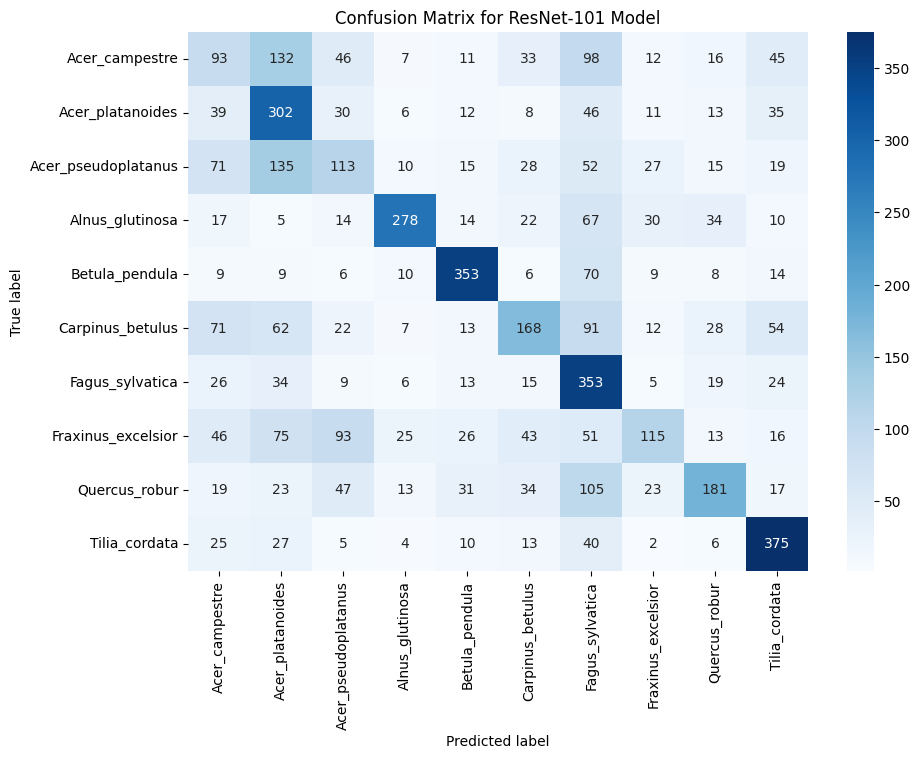

In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Concatenate, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.image import resize
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

# Define paths
base_path = "/content/drive/MyDrive/MainDataFolder/CombinedDataset"
species = ['Quercus_robur', 'Carpinus_betulus', 'Acer_campestre', 'Tilia_cordata',
           'Betula_pendula', 'Alnus_glutinosa', 'Acer_pseudoplatanus',
           'Fagus_sylvatica', 'Fraxinus_excelsior', 'Acer_platanoides']

# Load data from .npy files and downsample to 64x64
def load_data(target_size=(64, 64)):
    images = []
    ir_data = []
    labels = []
    for specie in species:
        print(f"Loading data for {specie}...")
        specie_images = np.load(Path(base_path) / f"{specie}_RGBI_combined.npy")
        specie_labels = np.load(Path(base_path) / f"{specie}_label_combined.npy")

        # Sample 2500 instances from each species
        indices = np.random.choice(len(specie_images), 2500, replace=False)
        specie_images_sampled = specie_images[indices]

        # Downsample images to target size
        specie_images_resized = np.array([resize(img[:, :, :3], target_size).numpy() / 255.0 for img in specie_images_sampled])
        specie_ir_resized = np.array([resize(img[:, :, 3:], target_size).numpy() / 255.0 for img in specie_images_sampled])

        images.append(specie_images_resized)
        ir_data.append(specie_ir_resized)
        labels.append(specie_labels[indices])

    images = np.concatenate(images)
    ir_data = np.concatenate(ir_data)
    labels = np.concatenate(labels)
    return images, ir_data, labels

# Load and preprocess data
print("Loading and preprocessing data...")
rgb_images, ir_images, labels = load_data()

# Encode labels
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

print(f"Loaded {len(rgb_images)} images with shape {rgb_images.shape}.")

# Split data into training and testing sets
print("Splitting data into training and testing sets...")
X_train_img, X_test_img, X_train_ir, X_test_ir, y_train, y_test = train_test_split(rgb_images, ir_images, labels_encoded, test_size=0.2, random_state=42)

print(f"Data splitting completed. Training set size: {len(X_train_img)}, Testing set size: {len(X_test_img)}")

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Custom data generator for multiple inputs
def custom_data_generator(datagen, X_img, X_ir, y, batch_size):
    genX1 = datagen.flow(X_img, y, batch_size=batch_size, seed=7)
    genX2 = datagen.flow(X_img, X_ir, batch_size=batch_size, seed=7)
    while True:
        X1i = genX1.next()
        X2i = genX2.next()
        yield [X1i[0], X2i[1]], X1i[1]

# Define the ResNet-101 based model
def create_resnet_model(input_image_size=(64, 64, 3), input_ir_size=(64, 64, 1), num_classes=10):
    base_model = ResNet101(include_top=False, weights='imagenet', input_shape=input_image_size)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)

    # IR input branch
    ir_input = Input(shape=input_ir_size, name='ir_input')
    ir_x = GlobalAveragePooling2D()(ir_input)

    # Combine branches
    combined = Concatenate()([x, ir_x])
    combined = Dense(128, activation='relu')(combined)
    combined = Dropout(0.5)(combined)
    output = Dense(num_classes, activation='softmax')(combined)

    model = Model(inputs=[base_model.input, ir_input], outputs=output)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Create and train the ResNet-101 model
input_image_size = X_train_img.shape[1:]
input_ir_size = X_train_ir.shape[1:]
num_classes = len(np.unique(y_train))

print(f"Creating ResNet-101 model with input sizes {input_image_size}, {input_ir_size}, and {num_classes} classes...")
model = create_resnet_model(input_image_size=input_image_size, input_ir_size=input_ir_size, num_classes=num_classes)
model.summary()

checkpoint_filepath = '/content/drive/MyDrive/MainDataFolder/checkpoints/resnet101_RGBI_2500_EP50/combined_model_checkpoint.h5'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True
)

early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

reduce_lr_callback = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

batch_size = 32
train_generator = custom_data_generator(datagen, X_train_img, X_train_ir, y_train, batch_size)

print("Training ResNet-101 model...")
history = model.fit(
    train_generator,
    validation_data=([X_test_img, X_test_ir], y_test),
    epochs=50,
    steps_per_epoch=len(X_train_img) // batch_size,
    callbacks=[model_checkpoint_callback, early_stopping_callback, reduce_lr_callback]
)
print("Model training completed.")

# Save the model and history
model_save_path = "/content/drive/MyDrive/MainDataFolder/AIModels/resnet101_RGBI_2500_EP50_combined_model.h5"
model.save(model_save_path)
print(f"Model saved as {model_save_path}")

history_save_path = "/content/drive/MyDrive/MainDataFolder/AIModels/History/resnet101_RGBI_2500_EP50_history.npz"
np.savez(history_save_path, history.history)
print(f"Training history saved as {history_save_path}")

# Evaluate the model
def evaluate_model(model, images, irs, labels, batch_size=128):
    preds = model.predict([images, irs], batch_size=batch_size)
    preds_labels = np.argmax(preds, axis=1)

    accuracy = accuracy_score(labels, preds_labels)
    cm = confusion_matrix(labels, preds_labels)
    report = classification_report(labels, preds_labels, output_dict=True)
    return accuracy, cm, report

print("Evaluating ResNet-101 model...")
accuracy, cm, report = evaluate_model(model, X_test_img, X_test_ir, y_test)

print(f"ResNet-101 Model - Accuracy: {accuracy}")
print("ResNet-101 Model - Classification Report:")
print(classification_report(y_test, np.argmax(model.predict([X_test_img, X_test_ir]), axis=1)))

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix for ResNet-101 Model')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()
#ran for 44min

now for epoch 100

Loading and preprocessing data...
Loading data for Quercus_robur...
Loading data for Carpinus_betulus...
Loading data for Acer_campestre...
Loading data for Tilia_cordata...
Loading data for Betula_pendula...
Loading data for Alnus_glutinosa...
Loading data for Acer_pseudoplatanus...
Loading data for Fagus_sylvatica...
Loading data for Fraxinus_excelsior...
Loading data for Acer_platanoides...
Loaded 25000 images with shape (25000, 64, 64, 3).
Splitting data into training and testing sets...
Data splitting completed. Training set size: 20000, Testing set size: 5000
Creating ResNet-101 model with input sizes (64, 64, 3), (64, 64, 1), and 10 classes...
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                           

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved as /content/drive/MyDrive/MainDataFolder/AIModels/resnet101_RGBI_2500_EP100_combined_model.h5
Training history saved as /content/drive/MyDrive/MainDataFolder/AIModels/History/resnet101_RGBI_2500_EP100_history.npz
Evaluating ResNet-101 model...
40/40 [==============================] - 4s 58ms/step
ResNet-101 Model - Accuracy: 0.4836
ResNet-101 Model - Classification Report:
157/157 [==============================] - 3s 21ms/step
              precision    recall  f1-score   support

           0       0.31      0.10      0.15       493
           1       0.48      0.45      0.47       502
           2       0.32      0.15      0.21       485
           3       0.54      0.76      0.63       491
           4       0.65      0.79      0.71       494
           5       0.41      0.44      0.42       528
           6       0.59      0.45      0.51       504
           7       0.31      0.46      0.37       503
           8       0.42      0.62      0.50       493
           9   

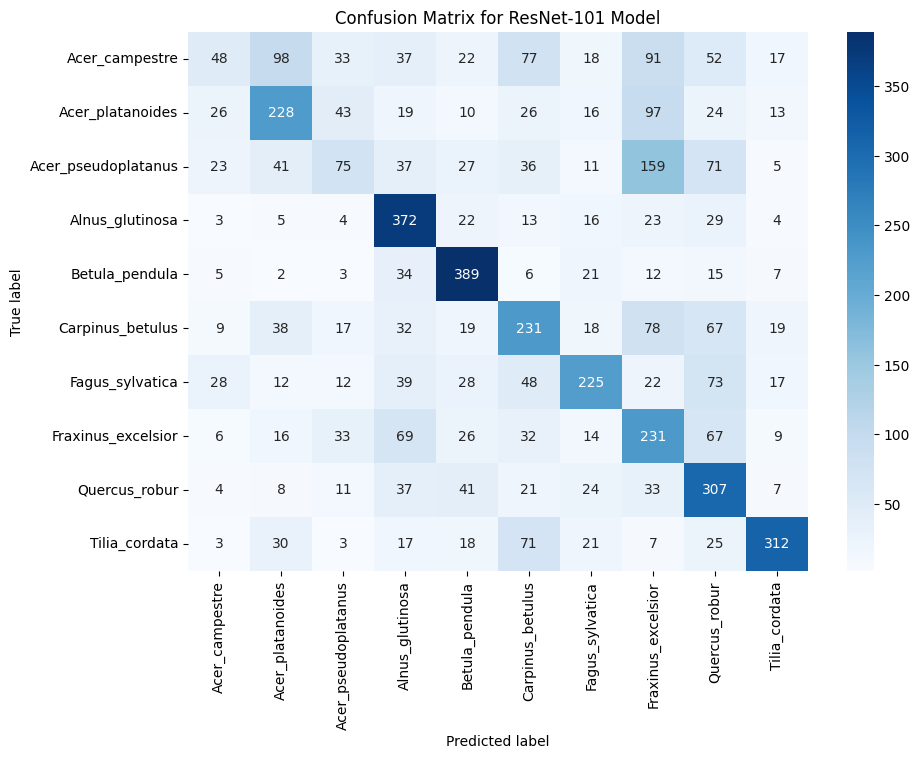

In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Concatenate, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.image import resize
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

# Define paths
base_path = "/content/drive/MyDrive/MainDataFolder/CombinedDataset"
species = ['Quercus_robur', 'Carpinus_betulus', 'Acer_campestre', 'Tilia_cordata',
           'Betula_pendula', 'Alnus_glutinosa', 'Acer_pseudoplatanus',
           'Fagus_sylvatica', 'Fraxinus_excelsior', 'Acer_platanoides']

# Load data from .npy files and downsample to 64x64
def load_data(target_size=(64, 64)):
    images = []
    ir_data = []
    labels = []
    for specie in species:
        print(f"Loading data for {specie}...")
        specie_images = np.load(Path(base_path) / f"{specie}_RGBI_combined.npy")
        specie_labels = np.load(Path(base_path) / f"{specie}_label_combined.npy")

        # Sample 2500 instances from each species
        indices = np.random.choice(len(specie_images), 2500, replace=False)
        specie_images_sampled = specie_images[indices]

        # Downsample images to target size
        specie_images_resized = np.array([resize(img[:, :, :3], target_size).numpy() / 255.0 for img in specie_images_sampled])
        specie_ir_resized = np.array([resize(img[:, :, 3:], target_size).numpy() / 255.0 for img in specie_images_sampled])

        images.append(specie_images_resized)
        ir_data.append(specie_ir_resized)
        labels.append(specie_labels[indices])

    images = np.concatenate(images)
    ir_data = np.concatenate(ir_data)
    labels = np.concatenate(labels)
    return images, ir_data, labels

# Load and preprocess data
print("Loading and preprocessing data...")
rgb_images, ir_images, labels = load_data()

# Encode labels
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

print(f"Loaded {len(rgb_images)} images with shape {rgb_images.shape}.")

# Split data into training and testing sets
print("Splitting data into training and testing sets...")
X_train_img, X_test_img, X_train_ir, X_test_ir, y_train, y_test = train_test_split(rgb_images, ir_images, labels_encoded, test_size=0.2, random_state=42)

print(f"Data splitting completed. Training set size: {len(X_train_img)}, Testing set size: {len(X_test_img)}")

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Custom data generator for multiple inputs
def custom_data_generator(datagen, X_img, X_ir, y, batch_size):
    genX1 = datagen.flow(X_img, y, batch_size=batch_size, seed=7)
    genX2 = datagen.flow(X_img, X_ir, batch_size=batch_size, seed=7)
    while True:
        X1i = genX1.next()
        X2i = genX2.next()
        yield [X1i[0], X2i[1]], X1i[1]

# Define the ResNet-101 based model
def create_resnet_model(input_image_size=(64, 64, 3), input_ir_size=(64, 64, 1), num_classes=10):
    base_model = ResNet101(include_top=False, weights='imagenet', input_shape=input_image_size)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)

    # IR input branch
    ir_input = Input(shape=input_ir_size, name='ir_input')
    ir_x = GlobalAveragePooling2D()(ir_input)

    # Combine branches
    combined = Concatenate()([x, ir_x])
    combined = Dense(128, activation='relu')(combined)
    combined = Dropout(0.5)(combined)
    output = Dense(num_classes, activation='softmax')(combined)

    model = Model(inputs=[base_model.input, ir_input], outputs=output)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Create and train the ResNet-101 model
input_image_size = X_train_img.shape[1:]
input_ir_size = X_train_ir.shape[1:]
num_classes = len(np.unique(y_train))

print(f"Creating ResNet-101 model with input sizes {input_image_size}, {input_ir_size}, and {num_classes} classes...")
model = create_resnet_model(input_image_size=input_image_size, input_ir_size=input_ir_size, num_classes=num_classes)
model.summary()

checkpoint_filepath = '/content/drive/MyDrive/MainDataFolder/checkpoints/resnet101_RGBI_2500_EP100/combined_model_checkpoint.h5'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True
)

early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

reduce_lr_callback = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

batch_size = 32
train_generator = custom_data_generator(datagen, X_train_img, X_train_ir, y_train, batch_size)

print("Training ResNet-101 model...")
history = model.fit(
    train_generator,
    validation_data=([X_test_img, X_test_ir], y_test),
    epochs=100,
    steps_per_epoch=len(X_train_img) // batch_size,
    callbacks=[model_checkpoint_callback, early_stopping_callback, reduce_lr_callback]
)
print("Model training completed.")

# Save the model and history
model_save_path = "/content/drive/MyDrive/MainDataFolder/AIModels/resnet101_RGBI_2500_EP100_combined_model.h5"
model.save(model_save_path)
print(f"Model saved as {model_save_path}")

history_save_path = "/content/drive/MyDrive/MainDataFolder/AIModels/History/resnet101_RGBI_2500_EP100_history.npz"
np.savez(history_save_path, history.history)
print(f"Training history saved as {history_save_path}")

# Evaluate the model
def evaluate_model(model, images, irs, labels, batch_size=128):
    preds = model.predict([images, irs], batch_size=batch_size)
    preds_labels = np.argmax(preds, axis=1)

    accuracy = accuracy_score(labels, preds_labels)
    cm = confusion_matrix(labels, preds_labels)
    report = classification_report(labels, preds_labels, output_dict=True)
    return accuracy, cm, report

print("Evaluating ResNet-101 model...")
accuracy, cm, report = evaluate_model(model, X_test_img, X_test_ir, y_test)

print(f"ResNet-101 Model - Accuracy: {accuracy}")
print("ResNet-101 Model - Classification Report:")
print(classification_report(y_test, np.argmax(model.predict([X_test_img, X_test_ir]), axis=1)))

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix for ResNet-101 Model')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()
#ran for 44min

## EfficientNetV2S with Data Augmentation,Learning Rate Adjustment and Early Stopping

Loading and preprocessing data...
Loading data for Quercus_robur...
Loading data for Carpinus_betulus...
Loading data for Acer_campestre...
Loading data for Tilia_cordata...
Loading data for Betula_pendula...
Loading data for Alnus_glutinosa...
Loading data for Acer_pseudoplatanus...
Loading data for Fagus_sylvatica...
Loading data for Fraxinus_excelsior...
Loading data for Acer_platanoides...
Loaded 25000 images with shape (25000, 64, 64, 3).
Splitting data into training and testing sets...
Data splitting completed. Training set size: 20000, Testing set size: 5000
Creating EfficientNetV2S model with input sizes (64, 64, 3), (64, 64, 1), and 10 classes...
82420632/82420632 [==============================] - 0s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 64, 64, 3)]        

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved as /content/drive/MyDrive/MainDataFolder/AIModels/efficientnetv2s_Aug_2500_RGBI_combined_model.h5
Evaluating EfficientNetV2S model...
40/40 [==============================] - 7s 58ms/step
EfficientNetV2S Model - Accuracy: 0.2194
EfficientNetV2S Model - Classification Report:
157/157 [==============================] - 3s 22ms/step
              precision    recall  f1-score   support

           0       0.20      0.04      0.06       493
           1       0.51      0.26      0.35       502
           2       0.50      0.00      0.00       485
           3       0.29      0.55      0.38       491
           4       0.19      0.01      0.02       494
           5       0.20      0.30      0.24       528
           6       0.20      0.34      0.25       504
           7       0.12      0.36      0.18       503
           8       0.00      0.00      0.00       493
           9       0.29      0.32      0.30       507

    accuracy                           0.22      5000
   mac

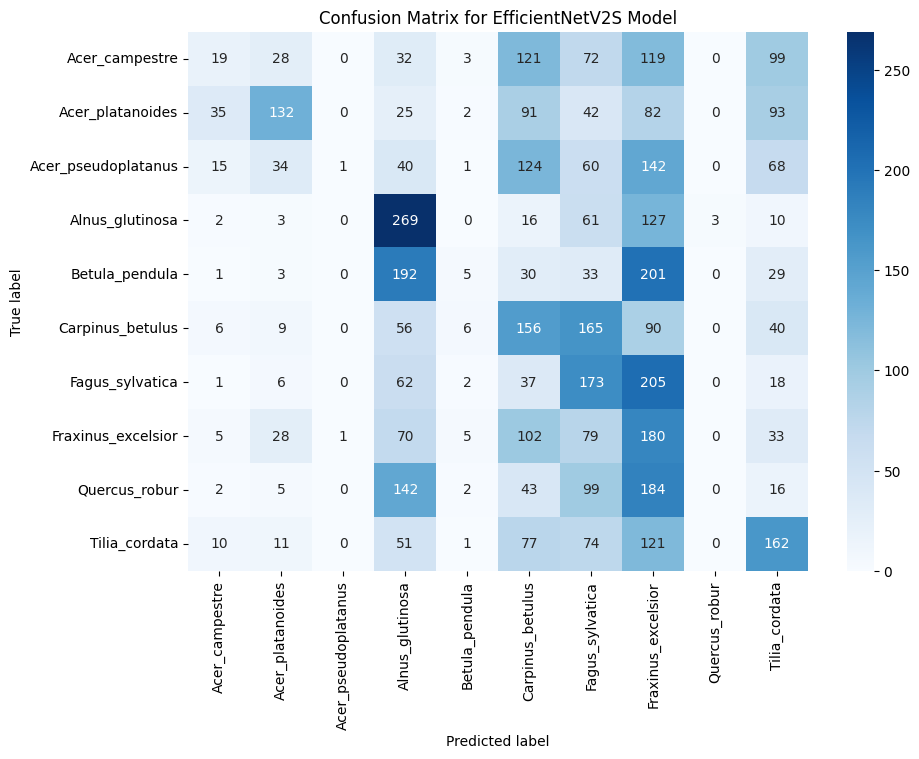

In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from tensorflow.keras.applications import EfficientNetV2S
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Concatenate, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.image import resize
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define paths
base_path = "/content/drive/MyDrive/MainDataFolder/CombinedDataset"
species = ['Quercus_robur', 'Carpinus_betulus', 'Acer_campestre', 'Tilia_cordata',
           'Betula_pendula', 'Alnus_glutinosa', 'Acer_pseudoplatanus',
           'Fagus_sylvatica', 'Fraxinus_excelsior', 'Acer_platanoides']

# Load data from .npy files and downsample to 64x64
def load_data(target_size=(64, 64)):
    images = []
    ir_data = []
    labels = []
    for specie in species:
        print(f"Loading data for {specie}...")
        specie_images = np.load(Path(base_path) / f"{specie}_RGBI_combined.npy")
        specie_labels = np.load(Path(base_path) / f"{specie}_label_combined.npy")

        # Sample 2500 instances from each species
        indices = np.random.choice(len(specie_images), 2500, replace=False)
        specie_images_sampled = specie_images[indices]

        # Downsample images to target size
        specie_images_resized = np.array([resize(img[:, :, :3], target_size).numpy() / 255.0 for img in specie_images_sampled])
        specie_ir_resized = np.array([resize(img[:, :, 3:], target_size).numpy() / 255.0 for img in specie_images_sampled])

        images.append(specie_images_resized)
        ir_data.append(specie_ir_resized)
        labels.append(specie_labels[indices])

    images = np.concatenate(images)
    ir_data = np.concatenate(ir_data)
    labels = np.concatenate(labels)
    return images, ir_data, labels

# Load and preprocess data
print("Loading and preprocessing data...")
rgb_images, ir_images, labels = load_data()

# Encode labels
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

print(f"Loaded {len(rgb_images)} images with shape {rgb_images.shape}.")

# Split data into training and testing sets
print("Splitting data into training and testing sets...")
X_train_img, X_test_img, X_train_ir, X_test_ir, y_train, y_test = train_test_split(rgb_images, ir_images, labels_encoded, test_size=0.2, random_state=42)

print(f"Data splitting completed. Training set size: {len(X_train_img)}, Testing set size: {len(X_test_img)}")

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

class CustomDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, images, ir_data, labels, batch_size, datagen):
        self.images = images
        self.ir_data = ir_data
        self.labels = labels
        self.batch_size = batch_size
        self.datagen = datagen
        self.indexes = np.arange(len(images))

    def __len__(self):
        return len(self.images) // self.batch_size

    def __getitem__(self, index):
        batch_indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        batch_images = self.images[batch_indexes]
        batch_ir = self.ir_data[batch_indexes]
        batch_labels = self.labels[batch_indexes]

        # Apply data augmentation to images only
        augmented_images = next(self.datagen.flow(batch_images, batch_size=self.batch_size, shuffle=False))

        return [augmented_images, batch_ir], batch_labels

# Define the EfficientNetV2S based model
def create_efficientnetv2s_model(input_image_size=(64, 64, 3), input_ir_size=(64, 64, 1), num_classes=10):
    base_model = EfficientNetV2S(include_top=False, weights='imagenet', input_shape=input_image_size)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)

    # IR input branch
    ir_input = Input(shape=input_ir_size, name='ir_input')
    ir_x = GlobalAveragePooling2D()(ir_input)

    # Combine branches
    combined = Concatenate()([x, ir_x])
    combined = Dense(128, activation='relu')(combined)
    combined = Dropout(0.5)(combined)
    output = Dense(num_classes, activation='softmax')(combined)

    model = Model(inputs=[base_model.input, ir_input], outputs=output)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Create and train the EfficientNetV2S model
input_image_size = X_train_img.shape[1:]
input_ir_size = X_train_ir.shape[1:]
num_classes = len(np.unique(y_train))

print(f"Creating EfficientNetV2S model with input sizes {input_image_size}, {input_ir_size}, and {num_classes} classes...")
model = create_efficientnetv2s_model(input_image_size=input_image_size, input_ir_size=input_ir_size, num_classes=num_classes)
model.summary()

checkpoint_filepath = '/content/drive/MyDrive/MainDataFolder/checkpoints/efficientnetv2s_RGBI_Aug_2500/combined_model_checkpoint.h5'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True
)

early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

reduce_lr_callback = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=0.0001
)

print("Training EfficientNetV2S model...")
train_generator = CustomDataGenerator(X_train_img, X_train_ir, y_train, batch_size=32, datagen=datagen)
history = model.fit(
    train_generator,
    validation_data=([X_test_img, X_test_ir], y_test),
    epochs=50,
    callbacks=[model_checkpoint_callback, early_stopping_callback, reduce_lr_callback]
)
print("Model training completed.")

# Save the model
model_save_path = "/content/drive/MyDrive/MainDataFolder/AIModels/efficientnetv2s_Aug_2500_RGBI_combined_model.h5"
model.save(model_save_path)
print(f"Model saved as {model_save_path}")

history_save_path = "/content/drive/MyDrive/MainDataFolder/AIModels/History/efficientnetv2s_RGBI_2500_EP50_history.npz"
np.savez(history_save_path, history.history)
print(f"Training history saved as {history_save_path}")

# Evaluate the model
def evaluate_model(model, images, irs, labels, batch_size=128):
    preds = model.predict([images, irs], batch_size=batch_size)
    preds_labels = np.argmax(preds, axis=1)

    accuracy = accuracy_score(labels, preds_labels)
    cm = confusion_matrix(labels, preds_labels)
    report = classification_report(labels, preds_labels, output_dict=True)
    return accuracy, cm, report

print("Evaluating EfficientNetV2S model...")
accuracy, cm, report = evaluate_model(model, X_test_img, X_test_ir, y_test)

print(f"EfficientNetV2S Model - Accuracy: {accuracy}")
print("EfficientNetV2S Model - Classification Report:")
print(classification_report(y_test, np.argmax(model.predict([X_test_img, X_test_ir]), axis=1)))

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix for EfficientNetV2S Model')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()


##DenseNet-121 (Densely Connected Convolutional Networks) with Data Augmentation and other CHanges for RGBI data

Loading and preprocessing data...
Loading data for Quercus_robur...
Loading data for Carpinus_betulus...
Loading data for Acer_campestre...
Loading data for Tilia_cordata...
Loading data for Betula_pendula...
Loading data for Alnus_glutinosa...
Loading data for Acer_pseudoplatanus...
Loading data for Fagus_sylvatica...
Loading data for Fraxinus_excelsior...
Loading data for Acer_platanoides...
Loaded 25000 images with shape (25000, 64, 64, 3).
Splitting data into training and testing sets...
Data splitting completed. Training set size: 20000, Testing set size: 5000
Creating DenseNet-121 model with input sizes (64, 64, 3), (64, 64, 1), and 10 classes...
29084464/29084464 [==============================] - 0s 0us/step
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 64, 64, 3)]          0

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved as /content/drive/MyDrive/MainDataFolder/AIModels/densenet121_Aug_2500_RGBI_combined_model.h5
Evaluating DenseNet-121 model...
40/40 [==============================] - 6s 35ms/step
DenseNet-121 Model - Accuracy: 0.4742
DenseNet-121 Model - Classification Report:
157/157 [==============================] - 2s 14ms/step
              precision    recall  f1-score   support

           0       0.25      0.11      0.16       493
           1       0.44      0.42      0.43       502
           2       0.37      0.14      0.20       485
           3       0.52      0.76      0.62       491
           4       0.57      0.82      0.67       494
           5       0.47      0.34      0.39       528
           6       0.38      0.62      0.47       504
           7       0.50      0.19      0.27       503
           8       0.45      0.58      0.51       493
           9       0.58      0.77      0.66       507

    accuracy                           0.47      5000
   macro avg       

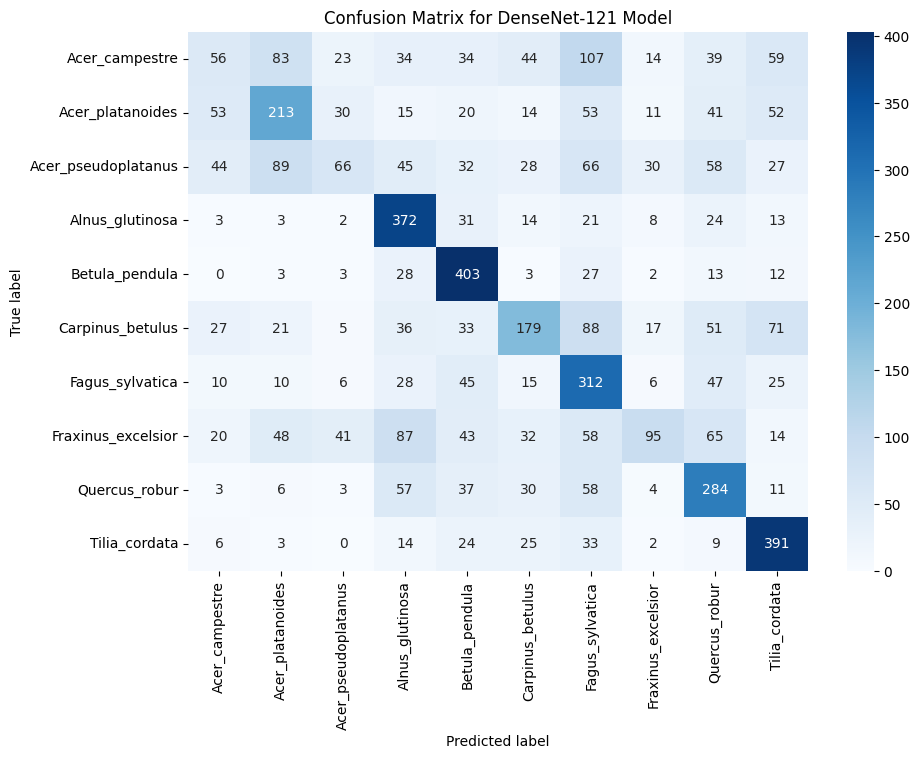

In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Concatenate, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.image import resize
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define paths
base_path = "/content/drive/MyDrive/MainDataFolder/CombinedDataset"
species = ['Quercus_robur', 'Carpinus_betulus', 'Acer_campestre', 'Tilia_cordata',
           'Betula_pendula', 'Alnus_glutinosa', 'Acer_pseudoplatanus',
           'Fagus_sylvatica', 'Fraxinus_excelsior', 'Acer_platanoides']

# Load data from .npy files and downsample to 64x64
def load_data(target_size=(64, 64)):
    images = []
    ir_data = []
    labels = []
    for specie in species:
        print(f"Loading data for {specie}...")
        specie_images = np.load(Path(base_path) / f"{specie}_RGBI_combined.npy")
        specie_labels = np.load(Path(base_path) / f"{specie}_label_combined.npy")

        # Sample 2500 instances from each species
        indices = np.random.choice(len(specie_images), 2500, replace=False)
        specie_images_sampled = specie_images[indices]

        # Downsample images to target size
        specie_images_resized = np.array([resize(img[:, :, :3], target_size).numpy() / 255.0 for img in specie_images_sampled])
        specie_ir_resized = np.array([resize(img[:, :, 3:], target_size).numpy() / 255.0 for img in specie_images_sampled])

        images.append(specie_images_resized)
        ir_data.append(specie_ir_resized)
        labels.append(specie_labels[indices])

    images = np.concatenate(images)
    ir_data = np.concatenate(ir_data)
    labels = np.concatenate(labels)
    return images, ir_data, labels

# Load and preprocess data
print("Loading and preprocessing data...")
rgb_images, ir_images, labels = load_data()

# Encode labels
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

print(f"Loaded {len(rgb_images)} images with shape {rgb_images.shape}.")

# Split data into training and testing sets
print("Splitting data into training and testing sets...")
X_train_img, X_test_img, X_train_ir, X_test_ir, y_train, y_test = train_test_split(rgb_images, ir_images, labels_encoded, test_size=0.2, random_state=42)

print(f"Data splitting completed. Training set size: {len(X_train_img)}, Testing set size: {len(X_test_img)}")

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

class CustomDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, images, ir_data, labels, batch_size, datagen):
        self.images = images
        self.ir_data = ir_data
        self.labels = labels
        self.batch_size = batch_size
        self.datagen = datagen
        self.indexes = np.arange(len(images))

    def __len__(self):
        return len(self.images) // self.batch_size

    def __getitem__(self, index):
        batch_indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        batch_images = self.images[batch_indexes]
        batch_ir = self.ir_data[batch_indexes]
        batch_labels = self.labels[batch_indexes]

        # Apply data augmentation to images only
        augmented_images = next(self.datagen.flow(batch_images, batch_size=self.batch_size, shuffle=False))

        return [augmented_images, batch_ir], batch_labels

# Define the DenseNet-121 based model
def create_densenet_model(input_image_size=(64, 64, 3), input_ir_size=(64, 64, 1), num_classes=10):
    base_model = DenseNet121(include_top=False, weights='imagenet', input_shape=input_image_size)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)

    # IR input branch
    ir_input = Input(shape=input_ir_size, name='ir_input')
    ir_x = GlobalAveragePooling2D()(ir_input)

    # Combine branches
    combined = Concatenate()([x, ir_x])
    combined = Dense(128, activation='relu')(combined)
    combined = Dropout(0.5)(combined)
    output = Dense(num_classes, activation='softmax')(combined)

    model = Model(inputs=[base_model.input, ir_input], outputs=output)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Create and train the DenseNet-121 model
input_image_size = X_train_img.shape[1:]
input_ir_size = X_train_ir.shape[1:]
num_classes = len(np.unique(y_train))

print(f"Creating DenseNet-121 model with input sizes {input_image_size}, {input_ir_size}, and {num_classes} classes...")
model = create_densenet_model(input_image_size=input_image_size, input_ir_size=input_ir_size, num_classes=num_classes)
model.summary()

checkpoint_filepath = '/content/drive/MyDrive/MainDataFolder/checkpoints/densenet121_RGBI_Aug_2500/combined_model_checkpoint.h5'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True
)

early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

reduce_lr_callback = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=0.0001
)

print("Training DenseNet-121 model...")
train_generator = CustomDataGenerator(X_train_img, X_train_ir, y_train, batch_size=32, datagen=datagen)
history = model.fit(
    train_generator,
    validation_data=([X_test_img, X_test_ir], y_test),
    epochs=50,
    callbacks=[model_checkpoint_callback, early_stopping_callback, reduce_lr_callback]
)
print("Model training completed.")

# Save the model
model_save_path = "/content/drive/MyDrive/MainDataFolder/AIModels/densenet121_Aug_2500_RGBI_combined_model.h5"
model.save(model_save_path)
print(f"Model saved as {model_save_path}")

history_save_path = "/content/drive/MyDrive/MainDataFolder/AIModels/History/densenet121_RGBI_2500_EP50_history.npz"
np.savez(history_save_path, history.history)
print(f"Training history saved as {history_save_path}")

# Evaluate the model
def evaluate_model(model, images, irs, labels, batch_size=128):
    preds = model.predict([images, irs], batch_size=batch_size)
    preds_labels = np.argmax(preds, axis=1)

    accuracy = accuracy_score(labels, preds_labels)
    cm = confusion_matrix(labels, preds_labels)
    report = classification_report(labels, preds_labels, output_dict=True)
    return accuracy, cm, report

print("Evaluating DenseNet-121 model...")
accuracy, cm, report = evaluate_model(model, X_test_img, X_test_ir, y_test)

print(f"DenseNet-121 Model - Accuracy: {accuracy}")
print("DenseNet-121 Model - Classification Report:")
print(classification_report(y_test, np.argmax(model.predict([X_test_img, X_test_ir]), axis=1)))

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix for DenseNet-121 Model')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()


#Detectree2 Evaluation

##467_5764

Mean IoU: 0.30614482864202486
Mean Over-Segmentation Ratio: 0.3233123925078629
Mean Under-Segmentation Ratio: 0.6046636731365184
Precision: 0.037831603229527104
Recall: 0.1569377990430622
F1 Score: 0.060966542750929366


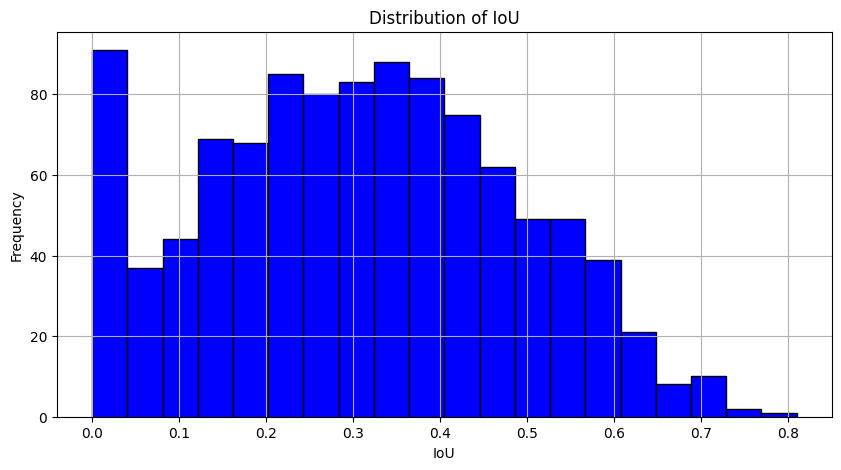

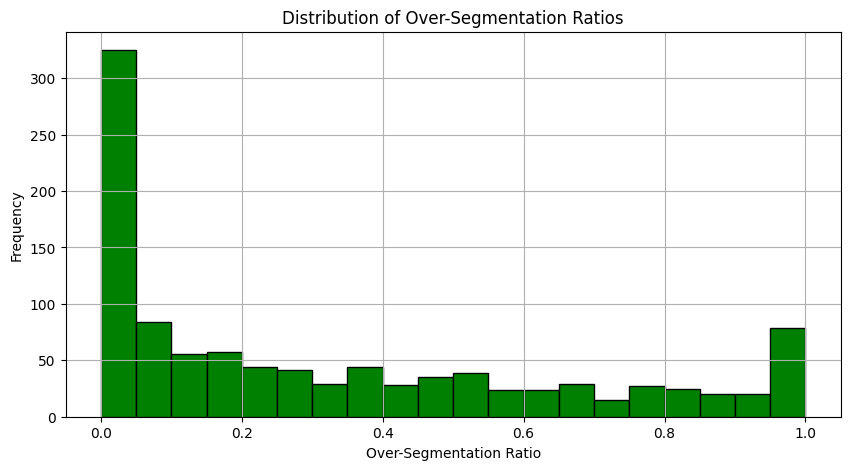

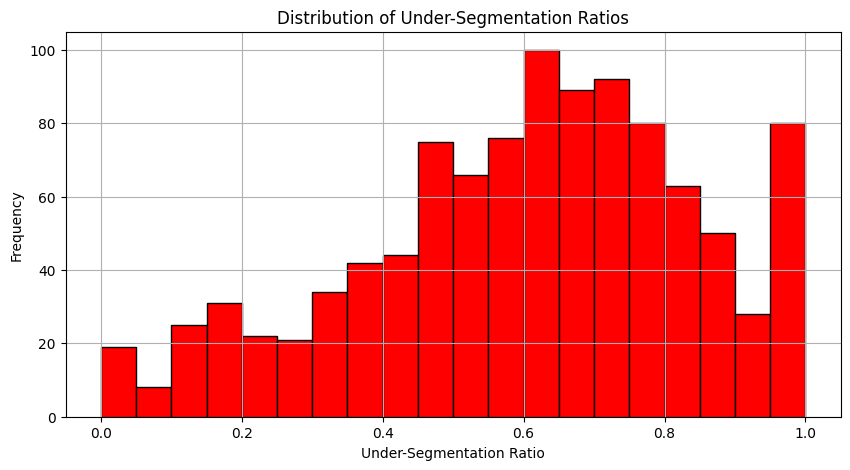

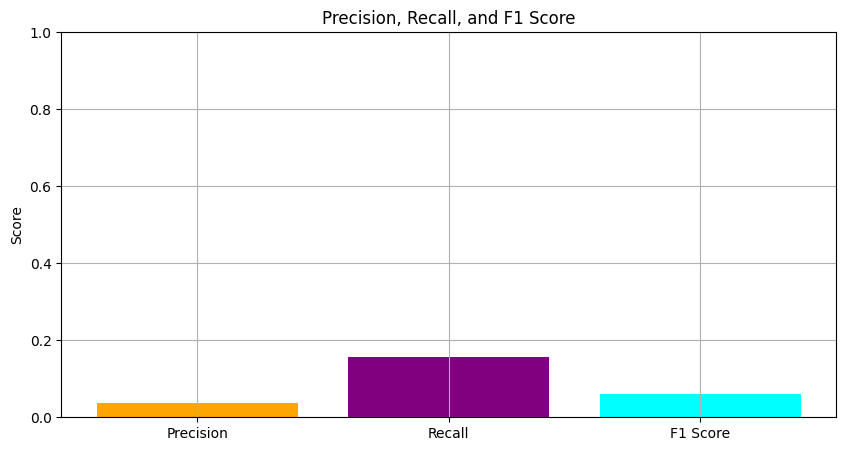

In [ ]:
# Step 1: Install necessary libraries
!pip install geopandas shapely matplotlib

# Step 2: Import the necessary libraries
import geopandas as gpd
from shapely.geometry import Polygon
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

# Step 3: Load the ground truth and detected tree crown polygons
# Load ground truth polygons
ground_truth_gdf = gpd.read_file("/content/drive/Othercomputers/ROG/detectree2-1.0.8/data/finalcrowns/reprojected_groundtruth_Mask_467_5764.gpkg")

# Load detected polygons
detected_gdf = gpd.read_file("/content/drive/Othercomputers/ROG/detectree2-1.0.8/data/finalcrowns/crowns_map_467_5764.gpkg")

# Step 4: Define evaluation functions
def calculate_iou(ground_truth, detected):
    intersection = ground_truth.intersection(detected).area
    union = ground_truth.union(detected).area
    return intersection / union

def calculate_oversegmentation_ratio(ground_truth, detected):
    return (detected.difference(ground_truth).area / detected.area) if detected.area != 0 else 0

def calculate_undersegmentation_ratio(ground_truth, detected):
    return (ground_truth.difference(detected).area / ground_truth.area) if ground_truth.area != 0 else 0

# Step 5: Perform evaluation
ious = []
oversegment_ratios = []
undersegment_ratios = []
true_positives = 0
false_positives = 0
false_negatives = 0

for idx, gt_polygon in ground_truth_gdf.iterrows():
    max_iou = 0
    best_detected_polygon = None

    for jdx, detected_polygon in detected_gdf.iterrows():
        iou = calculate_iou(gt_polygon.geometry, detected_polygon.geometry)
        if iou > max_iou:
            max_iou = iou
            best_detected_polygon = detected_polygon.geometry

    ious.append(max_iou)

    if best_detected_polygon is not None:
        oversegment_ratios.append(calculate_oversegmentation_ratio(gt_polygon.geometry, best_detected_polygon))
        undersegment_ratios.append(calculate_undersegmentation_ratio(gt_polygon.geometry, best_detected_polygon))
    else:
        oversegment_ratios.append(1)  # Maximum over-segmentation if no match found
        undersegment_ratios.append(1)  # Maximum under-segmentation if no match found

    if max_iou > 0.5:  # Assuming IoU > 0.5 indicates a true positive
        true_positives += 1
    else:
        false_negatives += 1

# False positives are detected polygons that do not match any ground truth polygon
for jdx, detected_polygon in detected_gdf.iterrows():
    max_iou = 0
    for idx, gt_polygon in ground_truth_gdf.iterrows():
        iou = calculate_iou(gt_polygon.geometry, detected_polygon.geometry)
        if iou > max_iou:
            max_iou = iou

    if max_iou <= 0.5:
        false_positives += 1

mean_iou = np.mean(ious)
mean_oversegmentation = np.mean(oversegment_ratios)
mean_undersegmentation = np.mean(undersegment_ratios)

precision = true_positives / (true_positives + false_positives)
recall = true_positives / (true_positives + false_negatives)
f1 = 2 * (precision * recall) / (precision + recall)

print(f"Mean IoU: {mean_iou}")
print(f"Mean Over-Segmentation Ratio: {mean_oversegmentation}")
print(f"Mean Under-Segmentation Ratio: {mean_undersegmentation}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

# Step 6: Plot graphical representations
# Plot IoU distribution
plt.figure(figsize=(10, 5))
plt.hist(ious, bins=20, color='blue', edgecolor='black')
plt.title('Distribution of IoU')
plt.xlabel('IoU')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Plot Over-Segmentation Ratio distribution
plt.figure(figsize=(10, 5))
plt.hist(oversegment_ratios, bins=20, color='green', edgecolor='black')
plt.title('Distribution of Over-Segmentation Ratios')
plt.xlabel('Over-Segmentation Ratio')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Plot Under-Segmentation Ratio distribution
plt.figure(figsize=(10, 5))
plt.hist(undersegment_ratios, bins=20, color='red', edgecolor='black')
plt.title('Distribution of Under-Segmentation Ratios')
plt.xlabel('Under-Segmentation Ratio')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Plot Precision, Recall, and F1 Score as a bar chart
metrics = ['Precision', 'Recall', 'F1 Score']
values = [precision, recall, f1]

plt.figure(figsize=(10, 5))
plt.bar(metrics, values, color=['orange', 'purple', 'cyan'])
plt.title('Precision, Recall, and F1 Score')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.grid(True)
plt.show()


##467_5763

Mean IoU: 0.3464336169000088
Mean Over-Segmentation Ratio: 0.5184278575947932
Mean Under-Segmentation Ratio: 0.39252341358444903
Precision: 0.07885072369842298
Recall: 0.2953074433656958
F1 Score: 0.12446717817561806


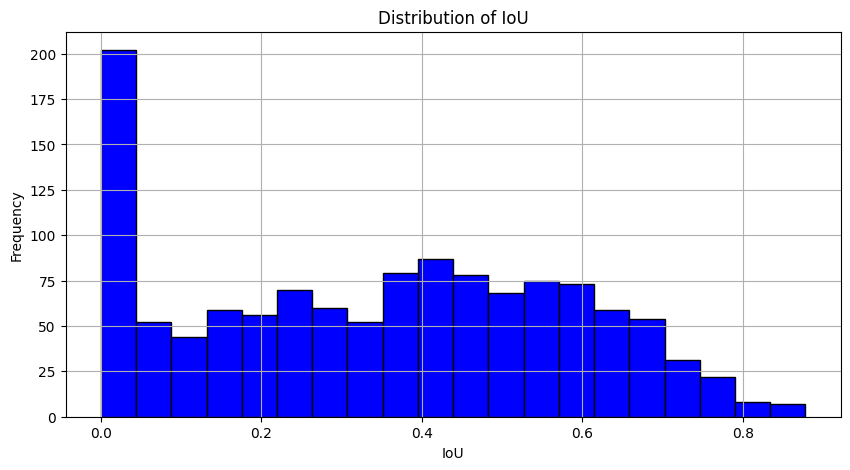

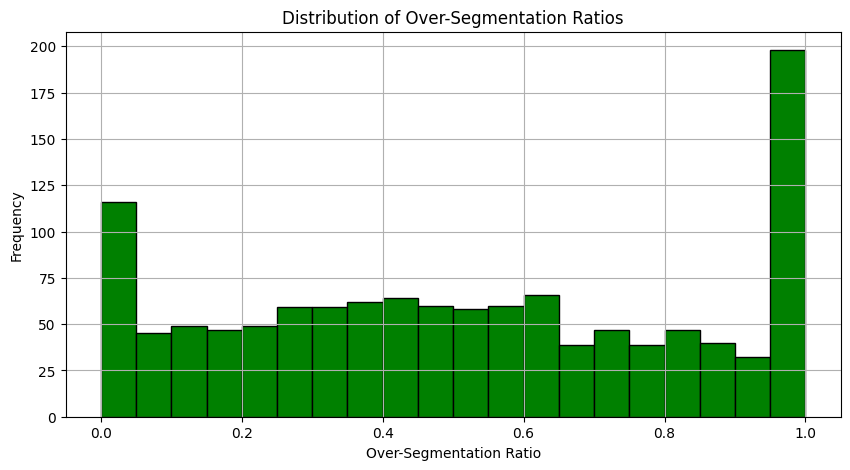

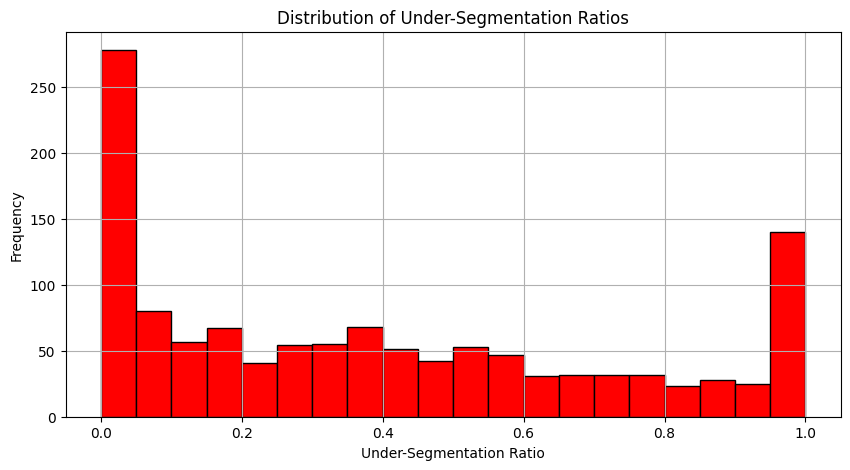

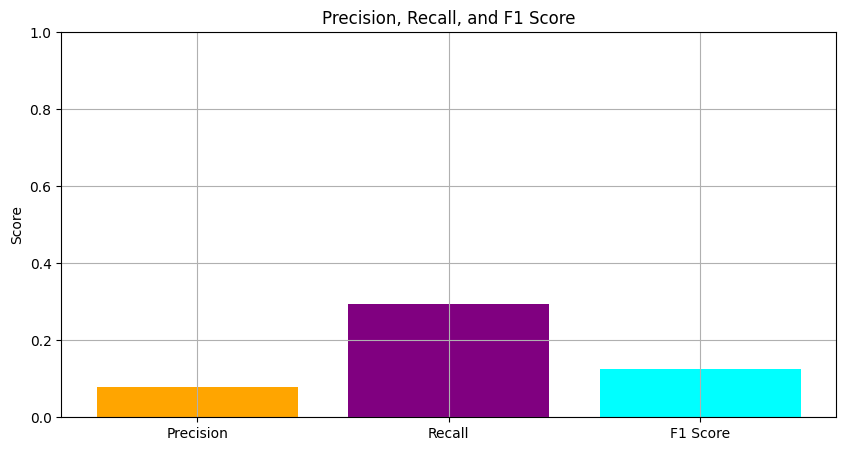

In [ ]:
# Step 1: Install necessary libraries
!pip install geopandas shapely matplotlib

# Step 2: Import the necessary libraries
import geopandas as gpd
from shapely.geometry import Polygon
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

# Step 3: Load the ground truth and detected tree crown polygons
# Load ground truth polygons
ground_truth_gdf = gpd.read_file("/content/drive/Othercomputers/ROG/detectree2-1.0.8/data/finalcrowns/groundtruth_Mask_467_5763.gpkg")

# Load detected polygons
detected_gdf = gpd.read_file("/content/drive/Othercomputers/ROG/detectree2-1.0.8/data/finalcrowns/crowns_map_467_5763.gpkg")

# Step 4: Define evaluation functions
def calculate_iou(ground_truth, detected):
    intersection = ground_truth.intersection(detected).area
    union = ground_truth.union(detected).area
    return intersection / union

def calculate_oversegmentation_ratio(ground_truth, detected):
    return (detected.difference(ground_truth).area / detected.area) if detected.area != 0 else 0

def calculate_undersegmentation_ratio(ground_truth, detected):
    return (ground_truth.difference(detected).area / ground_truth.area) if ground_truth.area != 0 else 0

# Step 5: Perform evaluation
ious = []
oversegment_ratios = []
undersegment_ratios = []
true_positives = 0
false_positives = 0
false_negatives = 0

for idx, gt_polygon in ground_truth_gdf.iterrows():
    max_iou = 0
    best_detected_polygon = None

    for jdx, detected_polygon in detected_gdf.iterrows():
        iou = calculate_iou(gt_polygon.geometry, detected_polygon.geometry)
        if iou > max_iou:
            max_iou = iou
            best_detected_polygon = detected_polygon.geometry

    ious.append(max_iou)

    if best_detected_polygon is not None:
        oversegment_ratios.append(calculate_oversegmentation_ratio(gt_polygon.geometry, best_detected_polygon))
        undersegment_ratios.append(calculate_undersegmentation_ratio(gt_polygon.geometry, best_detected_polygon))
    else:
        oversegment_ratios.append(1)  # Maximum over-segmentation if no match found
        undersegment_ratios.append(1)  # Maximum under-segmentation if no match found

    if max_iou > 0.5:  # Assuming IoU > 0.5 indicates a true positive
        true_positives += 1
    else:
        false_negatives += 1

# False positives are detected polygons that do not match any ground truth polygon
for jdx, detected_polygon in detected_gdf.iterrows():
    max_iou = 0
    for idx, gt_polygon in ground_truth_gdf.iterrows():
        iou = calculate_iou(gt_polygon.geometry, detected_polygon.geometry)
        if iou > max_iou:
            max_iou = iou

    if max_iou <= 0.5:
        false_positives += 1

mean_iou = np.mean(ious)
mean_oversegmentation = np.mean(oversegment_ratios)
mean_undersegmentation = np.mean(undersegment_ratios)

precision = true_positives / (true_positives + false_positives)
recall = true_positives / (true_positives + false_negatives)
f1 = 2 * (precision * recall) / (precision + recall)

print(f"Mean IoU: {mean_iou}")
print(f"Mean Over-Segmentation Ratio: {mean_oversegmentation}")
print(f"Mean Under-Segmentation Ratio: {mean_undersegmentation}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

# Step 6: Plot graphical representations
# Plot IoU distribution
plt.figure(figsize=(10, 5))
plt.hist(ious, bins=20, color='blue', edgecolor='black')
plt.title('Distribution of IoU')
plt.xlabel('IoU')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Plot Over-Segmentation Ratio distribution
plt.figure(figsize=(10, 5))
plt.hist(oversegment_ratios, bins=20, color='green', edgecolor='black')
plt.title('Distribution of Over-Segmentation Ratios')
plt.xlabel('Over-Segmentation Ratio')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Plot Under-Segmentation Ratio distribution
plt.figure(figsize=(10, 5))
plt.hist(undersegment_ratios, bins=20, color='red', edgecolor='black')
plt.title('Distribution of Under-Segmentation Ratios')
plt.xlabel('Under-Segmentation Ratio')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Plot Precision, Recall, and F1 Score as a bar chart
metrics = ['Precision', 'Recall', 'F1 Score']
values = [precision, recall, f1]

plt.figure(figsize=(10, 5))
plt.bar(metrics, values, color=['orange', 'purple', 'cyan'])
plt.title('Precision, Recall, and F1 Score')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.grid(True)
plt.show()


##468_5763

Mean IoU: 0.33816984615905726
Mean Over-Segmentation Ratio: 0.502272109734855
Mean Under-Segmentation Ratio: 0.4728193204540273
Precision: 0.11723534558180228
Recall: 0.29910714285714285
F1 Score: 0.1684475172847266


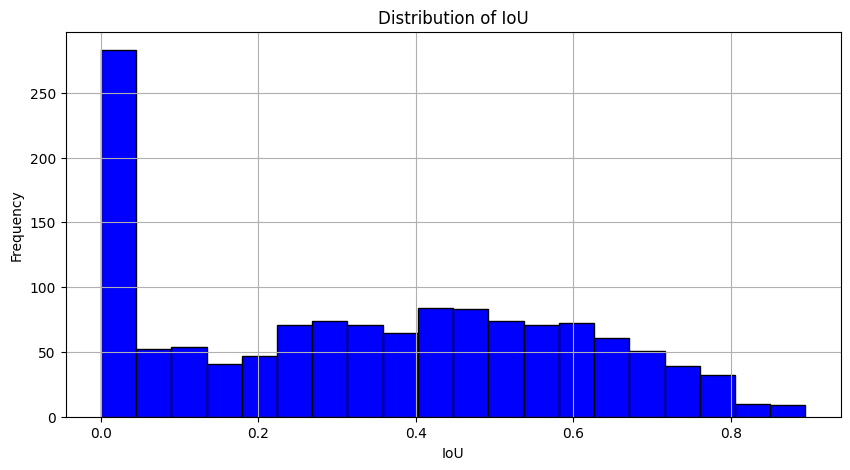

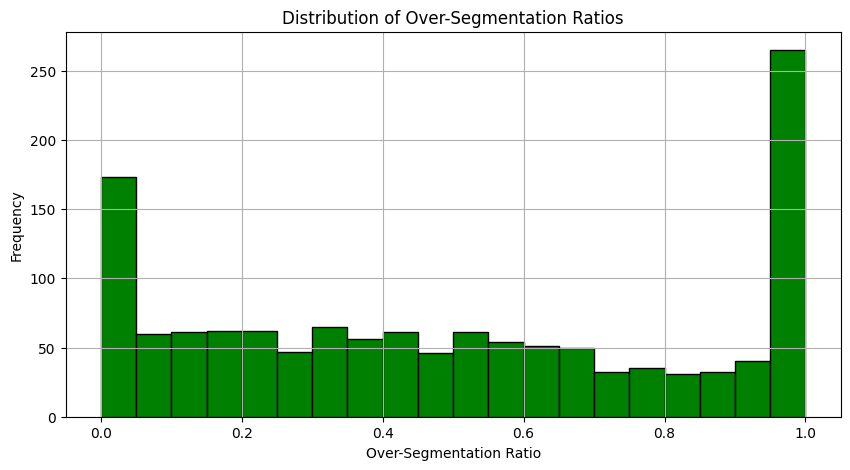

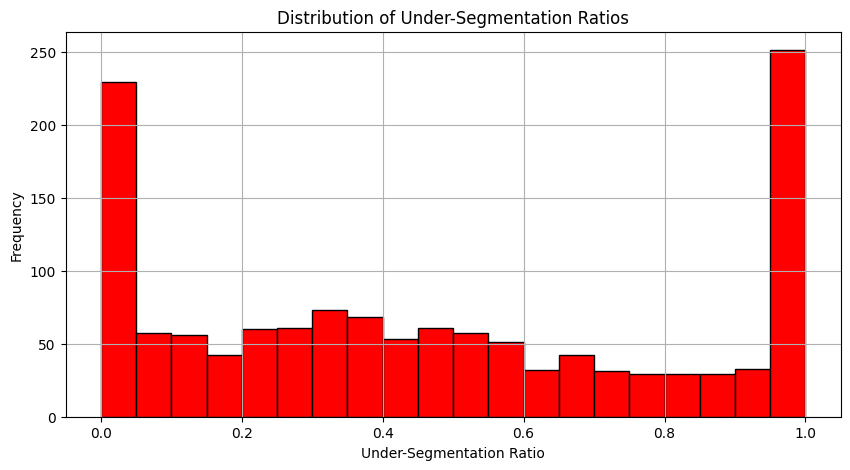

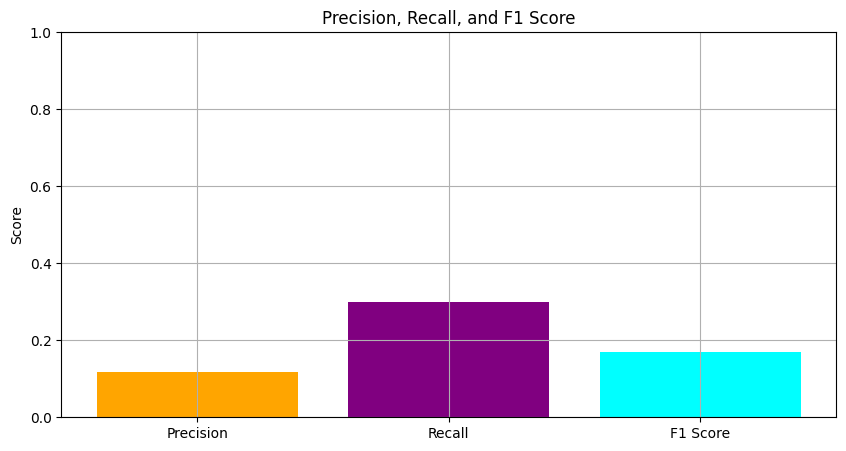

In [ ]:
# Step 1: Install necessary libraries
#!pip install geopandas shapely matplotlib

# Step 2: Import the necessary libraries
import geopandas as gpd
from shapely.geometry import Polygon
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

# Step 3: Load the ground truth and detected tree crown polygons
# Load ground truth polygons
ground_truth_gdf = gpd.read_file("/content/drive/Othercomputers/ROG/detectree2-1.0.8/data/finalcrowns/groundtruth_Mask_468_5763.gpkg")

# Load detected polygons
detected_gdf = gpd.read_file("/content/drive/Othercomputers/ROG/detectree2-1.0.8/data/finalcrowns/crowns_map_468_5763.gpkg")

# Step 4: Define evaluation functions
def calculate_iou(ground_truth, detected):
    intersection = ground_truth.intersection(detected).area
    union = ground_truth.union(detected).area
    return intersection / union

def calculate_oversegmentation_ratio(ground_truth, detected):
    return (detected.difference(ground_truth).area / detected.area) if detected.area != 0 else 0

def calculate_undersegmentation_ratio(ground_truth, detected):
    return (ground_truth.difference(detected).area / ground_truth.area) if ground_truth.area != 0 else 0

# Step 5: Perform evaluation
ious = []
oversegment_ratios = []
undersegment_ratios = []
true_positives = 0
false_positives = 0
false_negatives = 0

for idx, gt_polygon in ground_truth_gdf.iterrows():
    max_iou = 0
    best_detected_polygon = None

    for jdx, detected_polygon in detected_gdf.iterrows():
        iou = calculate_iou(gt_polygon.geometry, detected_polygon.geometry)
        if iou > max_iou:
            max_iou = iou
            best_detected_polygon = detected_polygon.geometry

    ious.append(max_iou)

    if best_detected_polygon is not None:
        oversegment_ratios.append(calculate_oversegmentation_ratio(gt_polygon.geometry, best_detected_polygon))
        undersegment_ratios.append(calculate_undersegmentation_ratio(gt_polygon.geometry, best_detected_polygon))
    else:
        oversegment_ratios.append(1)  # Maximum over-segmentation if no match found
        undersegment_ratios.append(1)  # Maximum under-segmentation if no match found

    if max_iou > 0.5:  # Assuming IoU > 0.5 indicates a true positive
        true_positives += 1
    else:
        false_negatives += 1

# False positives are detected polygons that do not match any ground truth polygon
for jdx, detected_polygon in detected_gdf.iterrows():
    max_iou = 0
    for idx, gt_polygon in ground_truth_gdf.iterrows():
        iou = calculate_iou(gt_polygon.geometry, detected_polygon.geometry)
        if iou > max_iou:
            max_iou = iou

    if max_iou <= 0.5:
        false_positives += 1

mean_iou = np.mean(ious)
mean_oversegmentation = np.mean(oversegment_ratios)
mean_undersegmentation = np.mean(undersegment_ratios)

precision = true_positives / (true_positives + false_positives)
recall = true_positives / (true_positives + false_negatives)
f1 = 2 * (precision * recall) / (precision + recall)

print(f"Mean IoU: {mean_iou}")
print(f"Mean Over-Segmentation Ratio: {mean_oversegmentation}")
print(f"Mean Under-Segmentation Ratio: {mean_undersegmentation}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

# Step 6: Plot graphical representations
# Plot IoU distribution
plt.figure(figsize=(10, 5))
plt.hist(ious, bins=20, color='blue', edgecolor='black')
plt.title('Distribution of IoU')
plt.xlabel('IoU')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Plot Over-Segmentation Ratio distribution
plt.figure(figsize=(10, 5))
plt.hist(oversegment_ratios, bins=20, color='green', edgecolor='black')
plt.title('Distribution of Over-Segmentation Ratios')
plt.xlabel('Over-Segmentation Ratio')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Plot Under-Segmentation Ratio distribution
plt.figure(figsize=(10, 5))
plt.hist(undersegment_ratios, bins=20, color='red', edgecolor='black')
plt.title('Distribution of Under-Segmentation Ratios')
plt.xlabel('Under-Segmentation Ratio')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Plot Precision, Recall, and F1 Score as a bar chart
metrics = ['Precision', 'Recall', 'F1 Score']
values = [precision, recall, f1]

plt.figure(figsize=(10, 5))
plt.bar(metrics, values, color=['orange', 'purple', 'cyan'])
plt.title('Precision, Recall, and F1 Score')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.grid(True)
plt.show()


##468_5764

Mean IoU: 0.3929976500010995
Mean Over-Segmentation Ratio: 0.4085344398080827
Mean Under-Segmentation Ratio: 0.4409050271474728
Precision: 0.09926341634514206
Recall: 0.38873626373626374
F1 Score: 0.15814473316568872


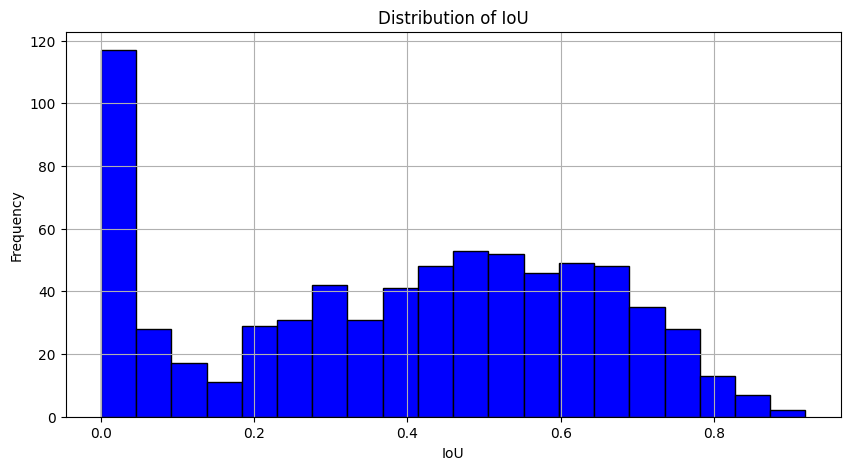

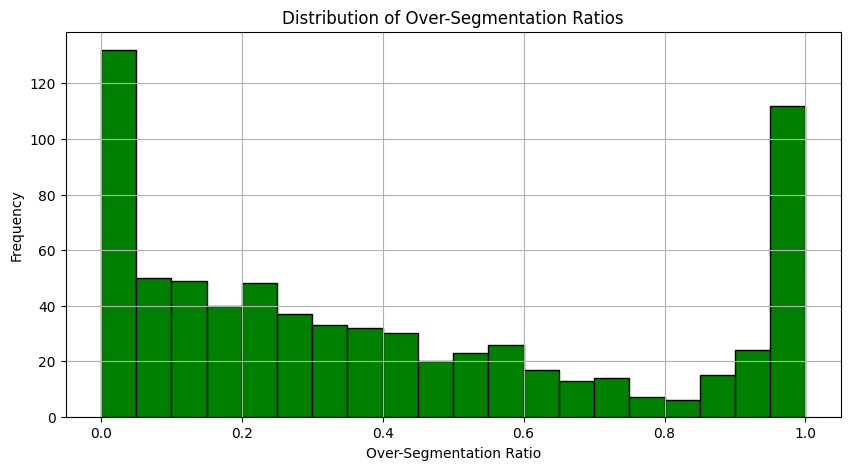

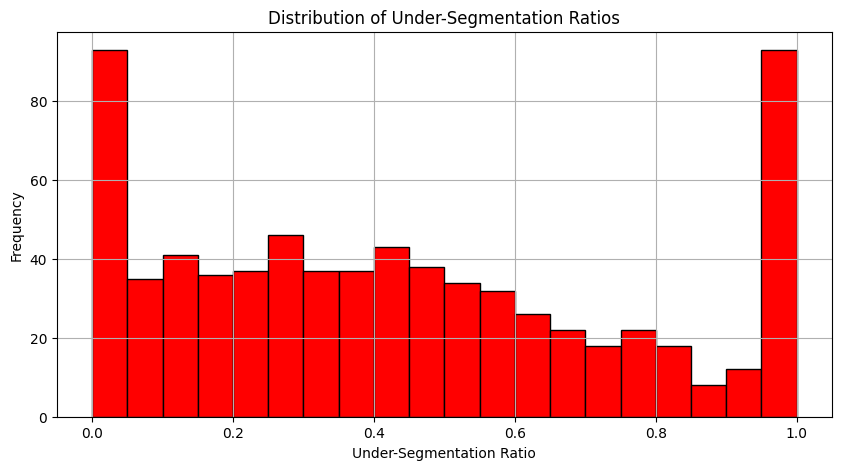

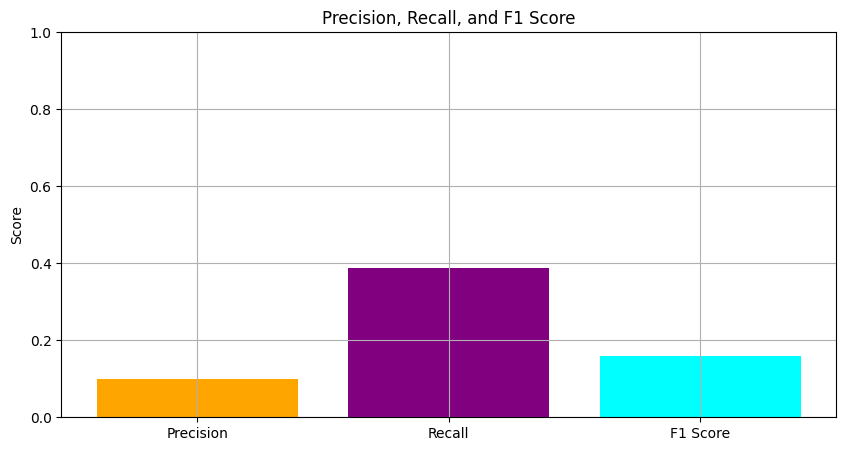

In [ ]:
# Step 1: Install necessary libraries
#!pip install geopandas shapely matplotlib

# Step 2: Import the necessary libraries
import geopandas as gpd
from shapely.geometry import Polygon
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

# Step 3: Load the ground truth and detected tree crown polygons
# Load ground truth polygons
ground_truth_gdf = gpd.read_file("/content/drive/Othercomputers/ROG/detectree2-1.0.8/data/finalcrowns/groundtruth_Mask_468_5764.gpkg")

# Load detected polygons
detected_gdf = gpd.read_file("/content/drive/Othercomputers/ROG/detectree2-1.0.8/data/finalcrowns/crowns_map_468_5764.gpkg")

# Step 4: Define evaluation functions
def calculate_iou(ground_truth, detected):
    intersection = ground_truth.intersection(detected).area
    union = ground_truth.union(detected).area
    return intersection / union

def calculate_oversegmentation_ratio(ground_truth, detected):
    return (detected.difference(ground_truth).area / detected.area) if detected.area != 0 else 0

def calculate_undersegmentation_ratio(ground_truth, detected):
    return (ground_truth.difference(detected).area / ground_truth.area) if ground_truth.area != 0 else 0

# Step 5: Perform evaluation
ious = []
oversegment_ratios = []
undersegment_ratios = []
true_positives = 0
false_positives = 0
false_negatives = 0

for idx, gt_polygon in ground_truth_gdf.iterrows():
    max_iou = 0
    best_detected_polygon = None

    for jdx, detected_polygon in detected_gdf.iterrows():
        iou = calculate_iou(gt_polygon.geometry, detected_polygon.geometry)
        if iou > max_iou:
            max_iou = iou
            best_detected_polygon = detected_polygon.geometry

    ious.append(max_iou)

    if best_detected_polygon is not None:
        oversegment_ratios.append(calculate_oversegmentation_ratio(gt_polygon.geometry, best_detected_polygon))
        undersegment_ratios.append(calculate_undersegmentation_ratio(gt_polygon.geometry, best_detected_polygon))
    else:
        oversegment_ratios.append(1)  # Maximum over-segmentation if no match found
        undersegment_ratios.append(1)  # Maximum under-segmentation if no match found

    if max_iou > 0.5:  # Assuming IoU > 0.5 indicates a true positive
        true_positives += 1
    else:
        false_negatives += 1

# False positives are detected polygons that do not match any ground truth polygon
for jdx, detected_polygon in detected_gdf.iterrows():
    max_iou = 0
    for idx, gt_polygon in ground_truth_gdf.iterrows():
        iou = calculate_iou(gt_polygon.geometry, detected_polygon.geometry)
        if iou > max_iou:
            max_iou = iou

    if max_iou <= 0.5:
        false_positives += 1

mean_iou = np.mean(ious)
mean_oversegmentation = np.mean(oversegment_ratios)
mean_undersegmentation = np.mean(undersegment_ratios)

precision = true_positives / (true_positives + false_positives)
recall = true_positives / (true_positives + false_negatives)
f1 = 2 * (precision * recall) / (precision + recall)

print(f"Mean IoU: {mean_iou}")
print(f"Mean Over-Segmentation Ratio: {mean_oversegmentation}")
print(f"Mean Under-Segmentation Ratio: {mean_undersegmentation}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

# Step 6: Plot graphical representations
# Plot IoU distribution
plt.figure(figsize=(10, 5))
plt.hist(ious, bins=20, color='blue', edgecolor='black')
plt.title('Distribution of IoU')
plt.xlabel('IoU')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Plot Over-Segmentation Ratio distribution
plt.figure(figsize=(10, 5))
plt.hist(oversegment_ratios, bins=20, color='green', edgecolor='black')
plt.title('Distribution of Over-Segmentation Ratios')
plt.xlabel('Over-Segmentation Ratio')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Plot Under-Segmentation Ratio distribution
plt.figure(figsize=(10, 5))
plt.hist(undersegment_ratios, bins=20, color='red', edgecolor='black')
plt.title('Distribution of Under-Segmentation Ratios')
plt.xlabel('Under-Segmentation Ratio')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Plot Precision, Recall, and F1 Score as a bar chart
metrics = ['Precision', 'Recall', 'F1 Score']
values = [precision, recall, f1]

plt.figure(figsize=(10, 5))
plt.bar(metrics, values, color=['orange', 'purple', 'cyan'])
plt.title('Precision, Recall, and F1 Score')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.grid(True)
plt.show()


# **BELOW ARE SOME CODE SAMPLE NOT INCLUDED/CONSIDERED AS A PART OF THE FINAL EVALUATION OF THESIS REPORT**

# *NOT INCLUDED IN THESIS REPORT*



## Models Including Kronendurch and Baumhoehe values

## Input 128x128 images directly then downsizing to 64x64 before feeding to our model


In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from pathlib import Path
from tensorflow.image import resize

# Set up GPU memory growth
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

# Enable mixed precision training
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

# Define paths
base_path = "/content/drive/MyDrive/MainDataFolder/CombinedDataset"
species = ['Quercus_robur', 'Carpinus_betulus', 'Acer_campestre', 'Tilia_cordata',
           'Betula_pendula', 'Alnus_glutinosa', 'Acer_pseudoplatanus',
           'Fagus_sylvatica', 'Fraxinus_excelsior', 'Acer_platanoides']

# Load data from .npy files
def load_data():
    images = []
    kds = []
    bhs = []
    labels = []
    for specie in species:
        print(f"Loading data for {specie}...")
        images.append(np.load(Path(base_path) / f"{specie}_RGBI_combined.npy"))
        kds.append(np.load(Path(base_path) / f"{specie}_KD_combined.npy"))
        bhs.append(np.load(Path(base_path) / f"{specie}_BH_combined.npy"))
        labels.append(np.load(Path(base_path) / f"{specie}_label_combined.npy"))
    images = np.concatenate(images)
    kds = np.concatenate(kds)
    bhs = np.concatenate(bhs)
    labels = np.concatenate(labels)
    return images, kds, bhs, labels

# Load combined data
print("Loading combined data...")
rgb_images, kd_values, bh_values, labels = load_data()

# Encode labels
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

print(f"Loaded {len(rgb_images)} images with shape {rgb_images.shape}.")

# Resize images to 64x64 to reduce memory usage
rgb_images_resized = np.array([resize(img, [64, 64]).numpy() for img in rgb_images])

# Split data into training and testing sets
print("Splitting data into training and testing sets...")
X_train_img, X_test_img, y_train, y_test = train_test_split(rgb_images_resized, labels, test_size=0.2, random_state=42)
X_train_kd, X_test_kd = train_test_split(kd_values, test_size=0.2, random_state=42)
X_train_bh, X_test_bh = train_test_split(bh_values, test_size=0.2, random_state=42)

# Proceed as before
print(f"Data splitting completed. Training set size: {len(X_train_img)}, Testing set size: {len(X_test_img)}")

print(f"Shape of X_train_img: {X_train_img.shape}")
print(f"Shape of X_train_kd: {X_train_kd.shape}")
print(f"Shape of X_train_bh: {X_train_bh.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of X_test_img: {X_test_img.shape}")
print(f"Shape of X_test_kd: {X_test_kd.shape}")
print(f"Shape of X_test_bh: {X_test_bh.shape}")
print(f"Shape of y_test: {y_test.shape}")

# Normalize the images
X_train_img = X_train_img.astype('float32') / 255.0
X_test_img = X_test_img.astype('float32') / 255.0

# Ensure labels are in the correct format
y_train = y_train.astype('int32')
y_test = y_test.astype('int32')

print(f"Data type of X_train_img: {X_train_img.dtype}")
print(f"Data type of X_train_kd: {X_train_kd.dtype}")
print(f"Data type of X_train_bh: {X_train_bh.dtype}")
print(f"Data type of y_train: {y_train.dtype}")
print(f"Data type of X_test_img: {X_test_img.dtype}")
print(f"Data type of X_test_kd: {X_test_kd.dtype}")
print(f"Data type of X_test_bh: {X_test_bh.dtype}")
print(f"Data type of y_test: {y_test.dtype}")

# Check for NaN and Inf values
print(f"Any NaN values in X_train_img: {np.isnan(X_train_img).any()}")
print(f"Any Inf values in X_train_img: {np.isinf(X_train_img).any()}")
print(f"Any NaN values in X_train_kd: {np.isnan(X_train_kd).any()}")
print(f"Any Inf values in X_train_kd: {np.isinf(X_train_kd).any()}")
print(f"Any NaN values in X_train_bh: {np.isnan(X_train_bh).any()}")
print(f"Any Inf values in X_train_bh: {np.isinf(X_train_bh).any()}")
print(f"Any NaN values in y_train: {np.isnan(y_train).any()}")
print(f"Any Inf values in y_train: {np.isinf(y_train).any()}")

# Define a CNN model that also takes KD and BH as inputs
def combined_model(input_image_size=(64, 64, 4), input_kd_size=(1,), input_bh_size=(1,), num_classes=10):
    # Image input branch
    image_input = Input(shape=input_image_size, name='image_input')
    x = Conv2D(32, (3, 3), activation='relu')(image_input)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu')(x)
    x = GlobalAveragePooling2D()(x)

    # KD and BH input branches
    kd_input = Input(shape=input_kd_size, name='kd_input')
    bh_input = Input(shape=input_bh_size, name='bh_input')

    # Combine branches
    combined = Concatenate()([x, kd_input, bh_input])
    combined = Dense(128, activation='relu')(combined)
    combined = Dropout(0.5)(combined)
    output = Dense(num_classes, activation='softmax')(combined)

    # Model definition
    model = Model(inputs=[image_input, kd_input, bh_input], outputs=output)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Create and train the model
input_image_size = X_train_img.shape[1:]
input_kd_size = (1,)
input_bh_size = (1,)
num_classes = len(np.unique(y_train))
print(f"Creating model with input sizes {input_image_size}, {input_kd_size}, {input_bh_size} and {num_classes} classes...")
model = combined_model(input_image_size=input_image_size, input_kd_size=input_kd_size, input_bh_size=input_bh_size, num_classes=num_classes)
model.summary()

checkpoint_filepath = '/content/drive/MyDrive/MainDataFolder/checkpoints/128x128/combined_model_checkpoint.h5'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True
)

early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

print("Training model...")
try:
    history = model.fit(
        [X_train_img, X_train_kd, X_train_bh], y_train,
        validation_data=([X_test_img, X_test_kd, X_test_bh], y_test),
        epochs=50, batch_size=32,
        callbacks=[model_checkpoint_callback, early_stopping_callback]
    )
    print("Model training completed.")
except tf.errors.InvalidArgumentError as e:
    print(f"Error during training: {e}")

# Save the model
model_save_path = "/content/drive/MyDrive/MainDataFolder/AIModels/128x128combined_model.h5"
model.save(model_save_path)
print(f"Model saved as {model_save_path}")


1 Physical GPUs, 1 Logical GPUs
Loading combined data...
Loading data for Quercus_robur...
Loading data for Carpinus_betulus...
Loading data for Acer_campestre...
Loading data for Tilia_cordata...
Loading data for Betula_pendula...
Loading data for Alnus_glutinosa...
Loading data for Acer_pseudoplatanus...
Loading data for Fagus_sylvatica...
Loading data for Fraxinus_excelsior...
Loading data for Acer_platanoides...
Loaded 55359 images with shape (55359, 128, 128, 4).
Splitting data into training and testing sets...
Data splitting completed. Training set size: 44287, Testing set size: 11072
Shape of X_train_img: (44287, 64, 64, 4)
Shape of X_train_kd: (44287,)
Shape of X_train_bh: (44287,)
Shape of y_train: (44287,)
Shape of X_test_img: (11072, 64, 64, 4)
Shape of X_test_kd: (11072,)
Shape of X_test_bh: (11072,)
Shape of y_test: (11072,)
Data type of X_train_img: float32
Data type of X_train_kd: float64
Data type of X_train_bh: float64
Data type of y_train: int32
Data type of X_test_im

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


##Input 64x64 images so no need for **downsampling**

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from pathlib import Path
from tensorflow.image import resize

# Set up GPU memory growth
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

# Enable mixed precision training
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

# Define paths
base_path_64 = "/content/drive/MyDrive/MainDataFolder/CombinedDataset64"
base_path = "/content/drive/MyDrive/MainDataFolder/CombinedDataset"
species = ['Quercus_robur', 'Carpinus_betulus', 'Acer_campestre', 'Tilia_cordata',
           'Betula_pendula', 'Alnus_glutinosa', 'Acer_pseudoplatanus',
           'Fagus_sylvatica', 'Fraxinus_excelsior', 'Acer_platanoides']

# Load data from .npy files
def load_data():
    images = []
    kds = []
    bhs = []
    labels = []
    for specie in species:
        print(f"Loading data for {specie}...")
        images.append(np.load(Path(base_path_64) / f"{specie}_RGBI64_combined.npy"))
        kds.append(np.load(Path(base_path) / f"{specie}_KD_combined.npy"))
        bhs.append(np.load(Path(base_path) / f"{specie}_BH_combined.npy"))
        labels.append(np.load(Path(base_path) / f"{specie}_label_combined.npy"))
    images = np.concatenate(images)
    kds = np.concatenate(kds)
    bhs = np.concatenate(bhs)
    labels = np.concatenate(labels)
    return images, kds, bhs, labels

# Load combined data
print("Loading combined data...")
rgb_images, kd_values, bh_values, labels = load_data()

# Encode labels
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

print(f"Loaded {len(rgb_images)} images with shape {rgb_images.shape}.")

# Split data into training and testing sets
print("Splitting data into training and testing sets...")
X_train_img, X_test_img, y_train, y_test = train_test_split(rgb_images, labels, test_size=0.2, random_state=42)
X_train_kd, X_test_kd = train_test_split(kd_values, test_size=0.2, random_state=42)
X_train_bh, X_test_bh = train_test_split(bh_values, test_size=0.2, random_state=42)

# Proceed as before
print(f"Data splitting completed. Training set size: {len(X_train_img)}, Testing set size: {len(X_test_img)}")

print(f"Shape of X_train_img: {X_train_img.shape}")
print(f"Shape of X_train_kd: {X_train_kd.shape}")
print(f"Shape of X_train_bh: {X_train_bh.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of X_test_img: {X_test_img.shape}")
print(f"Shape of X_test_kd: {X_test_kd.shape}")
print(f"Shape of X_test_bh: {X_test_bh.shape}")
print(f"Shape of y_test: {y_test.shape}")

# Normalize the images
X_train_img = X_train_img.astype('float32') / 255.0
X_test_img = X_test_img.astype('float32') / 255.0

# Ensure labels are in the correct format
y_train = y_train.astype('int32')
y_test = y_test.astype('int32')

print(f"Data type of X_train_img: {X_train_img.dtype}")
print(f"Data type of X_train_kd: {X_train_kd.dtype}")
print(f"Data type of X_train_bh: {X_train_bh.dtype}")
print(f"Data type of y_train: {y_train.dtype}")
print(f"Data type of X_test_img: {X_test_img.dtype}")
print(f"Data type of X_test_kd: {X_test_kd.dtype}")
print(f"Data type of X_test_bh: {X_test_bh.dtype}")
print(f"Data type of y_test: {y_test.dtype}")

# Check for NaN and Inf values
print(f"Any NaN values in X_train_img: {np.isnan(X_train_img).any()}")
print(f"Any Inf values in X_train_img: {np.isinf(X_train_img).any()}")
print(f"Any NaN values in X_train_kd: {np.isnan(X_train_kd).any()}")
print(f"Any Inf values in X_train_kd: {np.isinf(X_train_kd).any()}")
print(f"Any NaN values in X_train_bh: {np.isnan(X_train_bh).any()}")
print(f"Any Inf values in X_train_bh: {np.isinf(X_train_bh).any()}")
print(f"Any NaN values in y_train: {np.isnan(y_train).any()}")
print(f"Any Inf values in y_train: {np.isinf(y_train).any()}")

# Define a CNN model that also takes KD and BH as inputs
def combined_model(input_image_size=(64, 64, 4), input_kd_size=(1,), input_bh_size=(1,), num_classes=10):
    # Image input branch
    image_input = Input(shape=input_image_size, name='image_input')
    x = Conv2D(32, (3, 3), activation='relu')(image_input)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu')(x)
    x = GlobalAveragePooling2D()(x)

    # KD and BH input branches
    kd_input = Input(shape=input_kd_size, name='kd_input')
    bh_input = Input(shape=input_bh_size, name='bh_input')

    # Combine branches
    combined = Concatenate()([x, kd_input, bh_input])
    combined = Dense(128, activation='relu')(combined)
    combined = Dropout(0.5)(combined)
    output = Dense(num_classes, activation='softmax')(combined)

    # Model definition
    model = Model(inputs=[image_input, kd_input, bh_input], outputs=output)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Create and train the model
input_image_size = X_train_img.shape[1:]
input_kd_size = (1,)
input_bh_size = (1,)
num_classes = len(np.unique(y_train))
print(f"Creating model with input sizes {input_image_size}, {input_kd_size}, {input_bh_size} and {num_classes} classes...")
model = combined_model(input_image_size=input_image_size, input_kd_size=input_kd_size, input_bh_size=input_bh_size, num_classes=num_classes)
model.summary()

checkpoint_filepath = '/content/drive/MyDrive/MainDataFolder/checkpoints/64x64/combined_model_checkpoint.h5'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True
)

early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

print("Training model...")
try:
    history = model.fit(
        [X_train_img, X_train_kd, X_train_bh], y_train,
        validation_data=([X_test_img, X_test_kd, X_test_bh], y_test),
        epochs=50, batch_size=32,
        callbacks=[model_checkpoint_callback, early_stopping_callback]
    )
    print("Model training completed.")
except tf.errors.InvalidArgumentError as e:
    print(f"Error during training: {e}")

# Save the model
model_save_path = "/content/drive/MyDrive/MainDataFolder/AIModels/64x64combined_model.h5"
model.save(model_save_path)
print(f"Model saved as {model_save_path}")


1 Physical GPUs, 1 Logical GPUs
Loading combined data...
Loading data for Quercus_robur...
Loading data for Carpinus_betulus...
Loading data for Acer_campestre...
Loading data for Tilia_cordata...
Loading data for Betula_pendula...
Loading data for Alnus_glutinosa...
Loading data for Acer_pseudoplatanus...
Loading data for Fagus_sylvatica...
Loading data for Fraxinus_excelsior...
Loading data for Acer_platanoides...
Loaded 55359 images with shape (55359, 64, 64, 4).
Splitting data into training and testing sets...
Data splitting completed. Training set size: 44287, Testing set size: 11072
Shape of X_train_img: (44287, 64, 64, 4)
Shape of X_train_kd: (44287,)
Shape of X_train_bh: (44287,)
Shape of y_train: (44287,)
Shape of X_test_img: (11072, 64, 64, 4)
Shape of X_test_kd: (11072,)
Shape of X_test_bh: (11072,)
Shape of y_test: (11072,)
Data type of X_train_img: float32
Data type of X_train_kd: float64
Data type of X_train_bh: float64
Data type of y_train: int32
Data type of X_test_img:

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


##Input 32x32 images sp we need to upsample it to match the input size

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from pathlib import Path
from tensorflow.image import resize

# Set up GPU memory growth
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

# Enable mixed precision training
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

# Define paths
base_path_32 = "/content/drive/MyDrive/MainDataFolder/CombinedDataset32"
base_path = "/content/drive/MyDrive/MainDataFolder/CombinedDataset"
species = ['Quercus_robur', 'Carpinus_betulus', 'Acer_campestre', 'Tilia_cordata',
           'Betula_pendula', 'Alnus_glutinosa', 'Acer_pseudoplatanus',
           'Fagus_sylvatica', 'Fraxinus_excelsior', 'Acer_platanoides']

# Load data from .npy files
def load_data():
    images = []
    kds = []
    bhs = []
    labels = []
    for specie in species:
        print(f"Loading data for {specie}...")
        images.append(np.load(Path(base_path_32) / f"{specie}_RGBI32_combined.npy"))
        kds.append(np.load(Path(base_path) / f"{specie}_KD_combined.npy"))
        bhs.append(np.load(Path(base_path) / f"{specie}_BH_combined.npy"))
        labels.append(np.load(Path(base_path) / f"{specie}_label_combined.npy"))
    images = np.concatenate(images)
    kds = np.concatenate(kds)
    bhs = np.concatenate(bhs)
    labels = np.concatenate(labels)
    return images, kds, bhs, labels

# Load combined data
print("Loading combined data...")
rgb_images, kd_values, bh_values, labels = load_data()

# Upsample images to 64x64
print("Upsampling images to 64x64...")
rgb_images_resized = np.array([resize(img, [64, 64]).numpy() for img in rgb_images])

# Encode labels
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

print(f"Loaded {len(rgb_images_resized)} images with shape {rgb_images_resized.shape}.")

# Split data into training and testing sets
print("Splitting data into training and testing sets...")
X_train_img, X_test_img, y_train, y_test = train_test_split(rgb_images_resized, labels, test_size=0.2, random_state=42)
X_train_kd, X_test_kd = train_test_split(kd_values, test_size=0.2, random_state=42)
X_train_bh, X_test_bh = train_test_split(bh_values, test_size=0.2, random_state=42)

# Proceed as before
print(f"Data splitting completed. Training set size: {len(X_train_img)}, Testing set size: {len(X_test_img)}")

print(f"Shape of X_train_img: {X_train_img.shape}")
print(f"Shape of X_train_kd: {X_train_kd.shape}")
print(f"Shape of X_train_bh: {X_train_bh.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of X_test_img: {X_test_img.shape}")
print(f"Shape of X_test_kd: {X_test_kd.shape}")
print(f"Shape of X_test_bh: {X_test_bh.shape}")
print(f"Shape of y_test: {y_test.shape}")

# Normalize the images
X_train_img = X_train_img.astype('float32') / 255.0
X_test_img = X_test_img.astype('float32') / 255.0

# Ensure labels are in the correct format
y_train = y_train.astype('int32')
y_test = y_test.astype('int32')

print(f"Data type of X_train_img: {X_train_img.dtype}")
print(f"Data type of X_train_kd: {X_train_kd.dtype}")
print(f"Data type of X_train_bh: {X_train_bh.dtype}")
print(f"Data type of y_train: {y_train.dtype}")
print(f"Data type of X_test_img: {X_test_img.dtype}")
print(f"Data type of X_test_kd: {X_test_kd.dtype}")
print(f"Data type of X_test_bh: {X_test_bh.dtype}")
print(f"Data type of y_test: {y_test.dtype}")

# Check for NaN and Inf values
print(f"Any NaN values in X_train_img: {np.isnan(X_train_img).any()}")
print(f"Any Inf values in X_train_img: {np.isinf(X_train_img).any()}")
print(f"Any NaN values in X_train_kd: {np.isnan(X_train_kd).any()}")
print(f"Any Inf values in X_train_kd: {np.isinf(X_train_kd).any()}")
print(f"Any NaN values in X_train_bh: {np.isnan(X_train_bh).any()}")
print(f"Any Inf values in X_train_bh: {np.isinf(X_train_bh).any()}")
print(f"Any NaN values in y_train: {np.isnan(y_train).any()}")
print(f"Any Inf values in y_train: {np.isinf(y_train).any()}")

# Define a CNN model that also takes KD and BH as inputs
def combined_model(input_image_size=(64, 64, 4), input_kd_size=(1,), input_bh_size=(1,), num_classes=10):
    # Image input branch
    image_input = Input(shape=input_image_size, name='image_input')
    x = Conv2D(32, (3, 3), activation='relu')(image_input)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu')(x)
    x = GlobalAveragePooling2D()(x)

    # KD and BH input branches
    kd_input = Input(shape=input_kd_size, name='kd_input')
    bh_input = Input(shape=input_bh_size, name='bh_input')

    # Combine branches
    combined = Concatenate()([x, kd_input, bh_input])
    combined = Dense(128, activation='relu')(combined)
    combined = Dropout(0.5)(combined)
    output = Dense(num_classes, activation='softmax')(combined)

    # Model definition
    model = Model(inputs=[image_input, kd_input, bh_input], outputs=output)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Create and train the model
input_image_size = X_train_img.shape[1:]
input_kd_size = (1,)
input_bh_size = (1,)
num_classes = len(np.unique(y_train))
print(f"Creating model with input sizes {input_image_size}, {input_kd_size}, {input_bh_size} and {num_classes} classes...")
model = combined_model(input_image_size=input_image_size, input_kd_size=input_kd_size, input_bh_size=input_bh_size, num_classes=num_classes)
model.summary()

checkpoint_filepath = '/content/drive/MyDrive/MainDataFolder/checkpoints/combined_model_checkpoint.h5'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True
)

early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

print("Training model...")
try:
    history = model.fit(
        [X_train_img, X_train_kd, X_train_bh], y_train,
        validation_data=([X_test_img, X_test_kd, X_test_bh], y_test),
        epochs=50, batch_size=32,
        callbacks=[model_checkpoint_callback, early_stopping_callback]
    )
    print("Model training completed.")
except tf.errors.InvalidArgumentError as e:
    print(f"Error during training: {e}")

# Save the model
model_save_path = "/content/drive/MyDrive/MainDataFolder/AIModels/32x32combined_model.h5"
model.save(model_save_path)
print(f"Model saved as {model_save_path}")


1 Physical GPUs, 1 Logical GPUs
Loading combined data...
Loading data for Quercus_robur...
Loading data for Carpinus_betulus...
Loading data for Acer_campestre...
Loading data for Tilia_cordata...
Loading data for Betula_pendula...
Loading data for Alnus_glutinosa...
Loading data for Acer_pseudoplatanus...
Loading data for Fagus_sylvatica...
Loading data for Fraxinus_excelsior...
Loading data for Acer_platanoides...
Upsampling images to 64x64...
Loaded 55359 images with shape (55359, 64, 64, 4).
Splitting data into training and testing sets...
Data splitting completed. Training set size: 44287, Testing set size: 11072
Shape of X_train_img: (44287, 64, 64, 4)
Shape of X_train_kd: (44287,)
Shape of X_train_bh: (44287,)
Shape of y_train: (44287,)
Shape of X_test_img: (11072, 64, 64, 4)
Shape of X_test_kd: (11072,)
Shape of X_test_bh: (11072,)
Shape of y_test: (11072,)
Data type of X_train_img: float32
Data type of X_train_kd: float64
Data type of X_train_bh: float64
Data type of y_train: 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved as /content/drive/MyDrive/MainDataFolder/AIModels/32x32combined_model.h5


##Results Comparision

In [ ]:
#128x128
Epoch 50/50
1384/1384 [==============================] - 8s 6ms/step - loss: 1.1840 - accuracy: 0.6096 - val_loss: 1.1440 - val_accuracy: 0.6187
#64x64
Epoch 50/50
1384/1384 [==============================] - 9s 6ms/step - loss: 1.2669 - accuracy: 0.5877 - val_loss: 1.2174 - val_accuracy: 0.6025
#32x32
Epoch 50/50
1384/1384 [==============================] - 8s 6ms/step - loss: 1.4847 - accuracy: 0.5094 - val_loss: 1.4084 - val_accuracy: 0.5234

#  *NOT INCLUDED IN THESIS REPORT*

##Models trained with sample size of 2500

## Input 2500 128x128 images directly then downsizing to 64x64 before feeding to our model


In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from pathlib import Path
from tensorflow.image import resize

# Set up GPU memory growth
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

# Enable mixed precision training
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

# Define paths
base_path = "/content/drive/MyDrive/MainDataFolder/CombinedDataset"
species = ['Quercus_robur', 'Carpinus_betulus', 'Acer_campestre', 'Tilia_cordata',
           'Betula_pendula', 'Alnus_glutinosa', 'Acer_pseudoplatanus',
           'Fagus_sylvatica', 'Fraxinus_excelsior', 'Acer_platanoides']

# Load data from .npy files and downsample to 64x64
def load_data(target_size=(64, 64)):
    images = []
    kds = []
    bhs = []
    labels = []
    for specie in species:
        print(f"Loading data for {specie}...")
        specie_images = np.load(Path(base_path) / f"{specie}_RGBI_combined.npy")
        specie_kds = np.load(Path(base_path) / f"{specie}_KD_combined.npy")
        specie_bhs = np.load(Path(base_path) / f"{specie}_BH_combined.npy")
        specie_labels = np.load(Path(base_path) / f"{specie}_label_combined.npy")

        # Sample 2500 instances from each species
        indices = np.random.choice(len(specie_images), 2500, replace=False)
        specie_images_sampled = specie_images[indices]

        # Downsample images to target size
        specie_images_resized = np.array([resize(img, target_size).numpy() / 255.0 for img in specie_images_sampled])

        images.append(specie_images_resized)
        kds.append(specie_kds[indices])
        bhs.append(specie_bhs[indices])
        labels.append(specie_labels[indices])

    images = np.concatenate(images)
    kds = np.concatenate(kds)
    bhs = np.concatenate(bhs)
    labels = np.concatenate(labels)
    return images, kds, bhs, labels

# Load combined data
print("Loading combined data...")
rgb_images, kd_values, bh_values, labels = load_data()

# Encode labels
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

print(f"Loaded {len(rgb_images)} images with shape {rgb_images.shape}.")

# Split data into training and testing sets
print("Splitting data into training and testing sets...")
X_train_img, X_test_img, y_train, y_test = train_test_split(rgb_images, labels, test_size=0.2, random_state=42)
X_train_kd, X_test_kd = train_test_split(kd_values, test_size=0.2, random_state=42)
X_train_bh, X_test_bh = train_test_split(bh_values, test_size=0.2, random_state=42)

print(f"Data splitting completed. Training set size: {len(X_train_img)}, Testing set size: {len(X_test_img)}")
print(f"Shape of X_train_img: {X_train_img.shape}")
print(f"Shape of X_train_kd: {X_train_kd.shape}")
print(f"Shape of X_train_bh: {X_train_bh.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of X_test_img: {X_test_img.shape}")
print(f"Shape of X_test_kd: {X_test_kd.shape}")
print(f"Shape of X_test_bh: {X_test_bh.shape}")
print(f"Shape of y_test: {y_test.shape}")

# Check for NaN and Inf values
print(f"Any NaN values in X_train_img: {np.isnan(X_train_img).any()}")
print(f"Any Inf values in X_train_img: {np.isinf(X_train_img).any()}")
print(f"Any NaN values in X_train_kd: {np.isnan(X_train_kd).any()}")
print(f"Any Inf values in X_train_kd: {np.isinf(X_train_kd).any()}")
print(f"Any NaN values in X_train_bh: {np.isnan(X_train_bh).any()}")
print(f"Any Inf values in X_train_bh: {np.isinf(X_train_bh).any()}")
print(f"Any NaN values in y_train: {np.isnan(y_train).any()}")
print(f"Any Inf values in y_train: {np.isinf(y_train).any()}")

# Define a CNN model that also takes KD and BH as inputs
def combined_model(input_image_size=(64, 64, 4), input_kd_size=(1,), input_bh_size=(1,), num_classes=10):
    # Image input branch
    image_input = Input(shape=input_image_size, name='image_input')
    x = Conv2D(32, (3, 3), activation='relu')(image_input)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu')(x)
    x = GlobalAveragePooling2D()(x)

    # KD and BH input branches
    kd_input = Input(shape=input_kd_size, name='kd_input')
    bh_input = Input(shape=input_bh_size, name='bh_input')

    # Combine branches
    combined = Concatenate()([x, kd_input, bh_input])
    combined = Dense(128, activation='relu')(combined)
    combined = Dropout(0.5)(combined)
    output = Dense(num_classes, activation='softmax')(combined)

    # Model definition
    model = Model(inputs=[image_input, kd_input, bh_input], outputs=output)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Create and train the model
input_image_size = X_train_img.shape[1:]
input_kd_size = (1,)
input_bh_size = (1,)
num_classes = len(np.unique(y_train))
print(f"Creating model with input sizes {input_image_size}, {input_kd_size}, {input_bh_size} and {num_classes} classes...")
model = combined_model(input_image_size=input_image_size, input_kd_size=input_kd_size, input_bh_size=input_bh_size, num_classes=num_classes)
model.summary()

checkpoint_filepath = '/content/drive/MyDrive/MainDataFolder/checkpoints/128x128_2500/combined_model_checkpoint.h5'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True
)

early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

print("Training model...")
try:
    history = model.fit(
        [X_train_img, X_train_kd, X_train_bh], y_train,
        validation_data=([X_test_img, X_test_kd, X_test_bh], y_test),
        epochs=50, batch_size=32,
        callbacks=[model_checkpoint_callback, early_stopping_callback]
    )
    print("Model training completed.")
except tf.errors.InvalidArgumentError as e:
    print(f"Error during training: {e}")

# Save the model
model_save_path = "/content/drive/MyDrive/MainDataFolder/AIModels/128x128_2500_combined_model.h5"
model.save(model_save_path)
print(f"Model saved as {model_save_path}")


1 Physical GPUs, 1 Logical GPUs
Loading combined data...
Loading data for Quercus_robur...
Loading data for Carpinus_betulus...
Loading data for Acer_campestre...
Loading data for Tilia_cordata...
Loading data for Betula_pendula...
Loading data for Alnus_glutinosa...
Loading data for Acer_pseudoplatanus...
Loading data for Fagus_sylvatica...
Loading data for Fraxinus_excelsior...
Loading data for Acer_platanoides...
Loaded 25000 images with shape (25000, 64, 64, 4).
Splitting data into training and testing sets...
Data splitting completed. Training set size: 20000, Testing set size: 5000
Shape of X_train_img: (20000, 64, 64, 4)
Shape of X_train_kd: (20000,)
Shape of X_train_bh: (20000,)
Shape of y_train: (20000,)
Shape of X_test_img: (5000, 64, 64, 4)
Shape of X_test_kd: (5000,)
Shape of X_test_bh: (5000,)
Shape of y_test: (5000,)
Any NaN values in X_train_img: False
Any Inf values in X_train_img: False
Any NaN values in X_train_kd: False
Any Inf values in X_train_kd: False
Any NaN val

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## "NOT BEING USED" Input 2500 128x128 images directly then downsizing to 64x64 before feeding to our model but for RGBI and CHM data!!


1 Physical GPUs, 1 Logical GPUs
Loading combined data...
Loading data for Quercus_robur...
Loading data for Carpinus_betulus...
Loading data for Acer_campestre...
Loading data for Tilia_cordata...
Loading data for Betula_pendula...
Loading data for Alnus_glutinosa...
Loading data for Acer_pseudoplatanus...
Loading data for Fagus_sylvatica...
Loading data for Fraxinus_excelsior...
Loading data for Acer_platanoides...
Loaded 25000 images with shape (25000, 64, 64, 5).
Splitting data into training and testing sets...
Data splitting completed. Training set size: 20000, Testing set size: 5000
Shape of X_train: (20000, 64, 64, 5)
Shape of y_train: (20000,)
Shape of X_test: (5000, 64, 64, 5)
Shape of y_test: (5000,)
Any NaN values in X_train: False
Any Inf values in X_train: False
Any NaN values in y_train: False
Any Inf values in y_train: False
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 i

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


40/40 [==============================] - 1s 5ms/step
Model - Accuracy: 0.347
Model - Classification Report:
157/157 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.24      0.32      0.28       493
           1       0.36      0.27      0.31       502
           2       0.20      0.18      0.19       485
           3       0.42      0.32      0.36       491
           4       0.50      0.56      0.53       494
           5       0.30      0.35      0.32       528
           6       0.35      0.48      0.41       504
           7       0.46      0.17      0.24       503
           8       0.30      0.30      0.30       493
           9       0.42      0.52      0.46       507

    accuracy                           0.35      5000
   macro avg       0.36      0.35      0.34      5000
weighted avg       0.36      0.35      0.34      5000



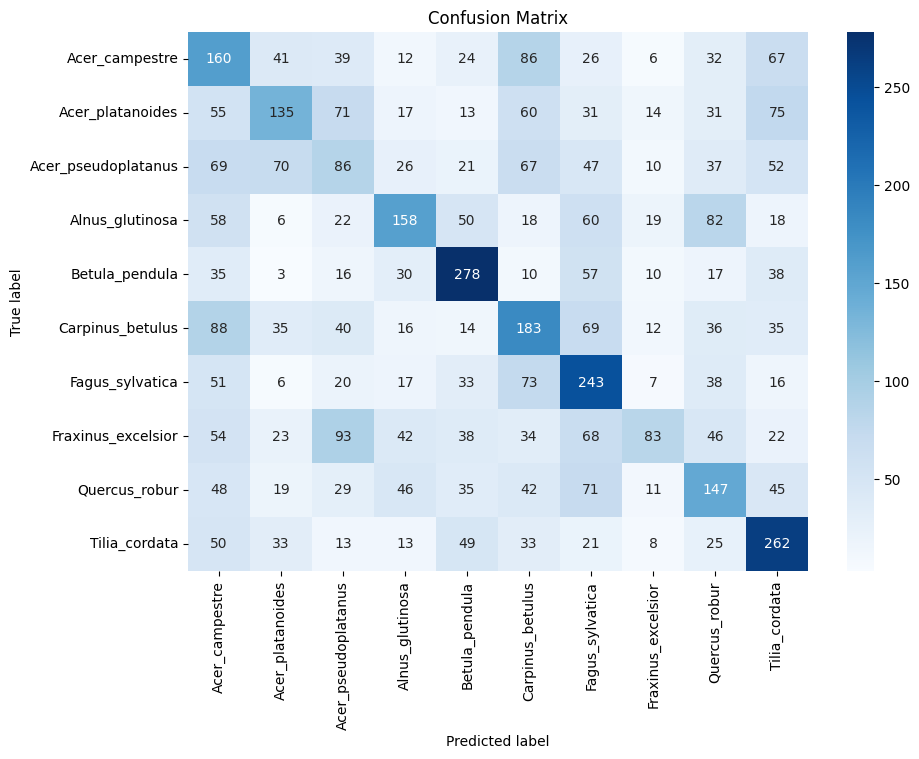

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from pathlib import Path
from tensorflow.image import resize
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Set up GPU memory growth
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

# Enable mixed precision training
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

# Define paths
base_path = "/content/drive/MyDrive/MainDataFolder/CombinedDataset"
species = ['Quercus_robur', 'Carpinus_betulus', 'Acer_campestre', 'Tilia_cordata',
           'Betula_pendula', 'Alnus_glutinosa', 'Acer_pseudoplatanus',
           'Fagus_sylvatica', 'Fraxinus_excelsior', 'Acer_platanoides']

# Load data from .npy files and downsample to 64x64
def load_data(target_size=(64, 64)):
    images = []
    chm_data = []
    labels = []
    for specie in species:
        print(f"Loading data for {specie}...")
        specie_images = np.load(Path(base_path) / f"{specie}_RGBI_combined.npy")
        specie_chm = np.load(Path(base_path) / f"{specie}_CHM_combined.npy")
        specie_labels = np.load(Path(base_path) / f"{specie}_label_combined.npy")

        indices = np.random.choice(len(specie_images), 2500, replace=False)
        specie_images_sampled = specie_images[indices]
        specie_chm_sampled = specie_chm[indices]

        specie_images_resized = np.array([resize(img[:, :, :4], target_size).numpy() / 255.0 for img in specie_images_sampled])  # Take first four bands
        specie_chm_resized = np.array([resize(chm[:, :, np.newaxis], target_size).numpy() for chm in specie_chm_sampled])  # Resize CHM and expand dims

        images.append(specie_images_resized)
        chm_data.append(specie_chm_resized)
        labels.append(specie_labels[indices])

    images = np.concatenate(images)
    chm_data = np.concatenate(chm_data)
    combined_data = np.concatenate((images, chm_data), axis=-1)  # Combine along the channel axis
    labels = np.concatenate(labels)
    return combined_data, labels

# Load combined data
print("Loading combined data...")
data, labels = load_data()

# Encode labels
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

print(f"Loaded {len(data)} images with shape {data.shape}.")

# Split data into training and testing sets
print("Splitting data into training and testing sets...")
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

print(f"Data splitting completed. Training set size: {len(X_train)}, Testing set size: {len(X_test)}")
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_test: {y_test.shape}")

# Check for NaN and Inf values
print(f"Any NaN values in X_train: {np.isnan(X_train).any()}")
print(f"Any Inf values in X_train: {np.isinf(X_train).any()}")
print(f"Any NaN values in y_train: {np.isnan(y_train).any()}")
print(f"Any Inf values in y_train: {np.isinf(y_train).any()}")

# Define a CNN model that handles 5 channels
def combined_model(input_shape=(64, 64, 5), num_classes=10):
    input_layer = Input(shape=input_shape, name='input_layer')
    x = Conv2D(32, (3, 3), activation='relu')(input_layer)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu')(x)
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=input_layer, outputs=output)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Create and train the model
model = combined_model(input_shape=X_train[0].shape, num_classes=len(np.unique(labels)))
model.summary()

checkpoint_filepath = '/content/drive/MyDrive/MainDataFolder/checkpoints/RGBI_CHM_128x128_2500/combined_model_checkpoint.h5'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True
)

early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

print("Training model...")
try:
    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=50, batch_size=32,
        callbacks=[model_checkpoint_callback, early_stopping_callback]
    )
    print("Model training completed.")
except tf.errors.InvalidArgumentError as e:
    print(f"Error during training: {e}")

# Save the model
model_save_path = "/content/drive/MyDrive/MainDataFolder/AIModels/RGBI_CHM_128x128_2500_combined_model.h5"
model.save(model_save_path)
print(f"Model saved as {model_save_path}")

# Evaluate the model
def evaluate_model(model, images, labels, batch_size=128):
    preds = model.predict(images, batch_size=batch_size)
    preds_labels = np.argmax(preds, axis=1)

    accuracy = accuracy_score(labels, preds_labels)
    cm = confusion_matrix(labels, preds_labels)
    report = classification_report(labels, preds_labels, output_dict=True)
    return accuracy, cm, report

print("Evaluating model...")
accuracy, cm, report = evaluate_model(model, X_test, y_test)

print(f"Model - Accuracy: {accuracy}")
print("Model - Classification Report:")
print(classification_report(y_test, np.argmax(model.predict(X_test), axis=1)))

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()


##Input 2500 128x128 images directly then downsizing to 64x64 before feeding to our model but for RGBI and CHM data with Data Augmentation,Learning Rate Adjustment and Early Stopping!!

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from pathlib import Path
from tensorflow.image import resize
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Set up GPU memory growth
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

# Enable mixed precision training
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

# Define paths
base_path = "/content/drive/MyDrive/MainDataFolder/CombinedDataset"
species = ['Quercus_robur', 'Carpinus_betulus', 'Acer_campestre', 'Tilia_cordata',
           'Betula_pendula', 'Alnus_glutinosa', 'Acer_pseudoplatanus',
           'Fagus_sylvatica', 'Fraxinus_excelsior', 'Acer_platanoides']

# Load data from .npy files and downsample to 64x64
def load_data(target_size=(64, 64)):
    images = []
    chm_data = []
    labels = []
    for specie in species:
        print(f"Loading data for {specie}...")
        specie_images = np.load(Path(base_path) / f"{specie}_RGBI_combined.npy")
        specie_chm = np.load(Path(base_path) / f"{specie}_CHM_combined.npy")
        specie_labels = np.load(Path(base_path) / f"{specie}_label_combined.npy")

        indices = np.random.choice(len(specie_images), 2500, replace=False)
        specie_images_sampled = specie_images[indices]
        specie_chm_sampled = specie_chm[indices]

        specie_images_resized = np.array([resize(img[:, :, :4], target_size).numpy() / 255.0 for img in specie_images_sampled])  # Take first four bands
        specie_chm_resized = np.array([resize(chm[:, :, np.newaxis], target_size).numpy() for chm in specie_chm_sampled])  # Resize CHM and expand dims

        images.append(specie_images_resized)
        chm_data.append(specie_chm_resized)
        labels.append(specie_labels[indices])

    images = np.concatenate(images)
    chm_data = np.concatenate(chm_data)
    combined_data = np.concatenate((images, chm_data), axis=-1)  # Combine along the channel axis
    labels = np.concatenate(labels)
    return combined_data, labels

# Load combined data
print("Loading combined data...")
data, labels = load_data()

# Encode labels
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

print(f"Loaded {len(data)} images with shape {data.shape}.")

# Split data into training and testing sets
print("Splitting data into training and testing sets...")
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

print(f"Data splitting completed. Training set size: {len(X_train)}, Testing set size: {len(X_test)}")
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_test: {y_test.shape}")

# Check for NaN and Inf values
print(f"Any NaN values in X_train: {np.isnan(X_train).any()}")
print(f"Any Inf values in X_train: {np.isinf(X_train).any()}")
print(f"Any NaN values in y_train: {np.isnan(y_train).any()}")
print(f"Any Inf values in y_train: {np.isinf(y_train).any()}")

# Define a CNN model that handles 5 channels
def combined_model(input_shape=(64, 64, 5), num_classes=10):
    input_layer = Input(shape=input_shape, name='input_layer')
    x = Conv2D(32, (3, 3), activation='relu')(input_layer)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu')(x)
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=input_layer, outputs=output)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Create and train the model
model = combined_model(input_shape=X_train[0].shape, num_classes=len(np.unique(labels)))
model.summary()

# Callbacks
checkpoint_filepath = '/content/drive/MyDrive/MainDataFolder/checkpoints/RGBI_CHM_128x128_2500/combined_model_checkpoint.h5'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True
)

early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

reduce_lr_callback = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=0.00001
)

# Data augmentation using ImageDataGenerator
datagen = ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=30,
    zoom_range=0.3,
    width_shift_range=0.3,
    height_shift_range=0.3,
    brightness_range=[0.8, 1.2]
)

print("Training model...")
try:
    history = model.fit(
        datagen.flow(X_train, y_train, batch_size=32),
        validation_data=(X_test, y_test),
        epochs=50,
        callbacks=[model_checkpoint_callback, early_stopping_callback, reduce_lr_callback]
    )
    print("Model training completed.")
except tf.errors.InvalidArgumentError as e:
    print(f"Error during training: {e}")

# Save the model
model_save_path = "/content/drive/MyDrive/MainDataFolder/AIModels/RGBI_CHM_128x128_2500_combined_model.h5"
model.save(model_save_path)
print(f"Model saved as {model_save_path}")

# Evaluate the model
def evaluate_model(model, images, labels, batch_size=128):
    preds = model.predict(images, batch_size=batch_size)
    preds_labels = np.argmax(preds, axis=1)

    accuracy = accuracy_score(labels, preds_labels)
    cm = confusion_matrix(labels, preds_labels)
    report = classification_report(labels, preds_labels, output_dict=True)
    return accuracy, cm, report

print("Evaluating model...")
accuracy, cm, report = evaluate_model(model, X_test, y_test)

print(f"Model - Accuracy: {accuracy}")
print("Model - Classification Report:")
print(classification_report(y_test, np.argmax(model.predict(X_test), axis=1)))

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()


1 Physical GPUs, 1 Logical GPUs
Loading combined data...
Loading data for Quercus_robur...
Loading data for Carpinus_betulus...
Loading data for Acer_campestre...
Loading data for Tilia_cordata...
Loading data for Betula_pendula...
Loading data for Alnus_glutinosa...
Loading data for Acer_pseudoplatanus...
Loading data for Fagus_sylvatica...
Loading data for Fraxinus_excelsior...
Loading data for Acer_platanoides...
Loaded 25000 images with shape (25000, 64, 64, 5).
Splitting data into training and testing sets...
Data splitting completed. Training set size: 20000, Testing set size: 5000
Shape of X_train: (20000, 64, 64, 5)
Shape of y_train: (20000,)
Shape of X_test: (5000, 64, 64, 5)
Shape of y_test: (5000,)
Any NaN values in X_train: False
Any Inf values in X_train: False
Any NaN values in y_train: False
Any Inf values in y_train: False
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   


/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:766: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (20000, 64, 64, 5) (5 channels).
  warnings.warn(


ValueError: Unsupported channel number: 5

## Input 2500 64x64 images directly feeding to our model


In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from pathlib import Path
from tensorflow.image import resize

# Set up GPU memory growth
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

# Enable mixed precision training
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

# Define paths
base_path_64 = "/content/drive/MyDrive/MainDataFolder/CombinedDataset64"
base_path = "/content/drive/MyDrive/MainDataFolder/CombinedDataset"
species = ['Quercus_robur', 'Carpinus_betulus', 'Acer_campestre', 'Tilia_cordata',
           'Betula_pendula', 'Alnus_glutinosa', 'Acer_pseudoplatanus',
           'Fagus_sylvatica', 'Fraxinus_excelsior', 'Acer_platanoides']

# Load data from .npy files
def load_data():
    images = []
    kds = []
    bhs = []
    labels = []
    for specie in species:
        print(f"Loading data for {specie}...")
        specie_images = np.load(Path(base_path_64) / f"{specie}_RGBI_combined.npy")
        specie_kds = np.load(Path(base_path) / f"{specie}_KD_combined.npy")
        specie_bhs = np.load(Path(base_path) / f"{specie}_BH_combined.npy")
        specie_labels = np.load(Path(base_path) / f"{specie}_label_combined.npy")

        # Sample 2500 instances from each species
        indices = np.random.choice(len(specie_images), 2500, replace=False)
        images.append(specie_images[indices])
        kds.append(specie_kds[indices])
        bhs.append(specie_bhs[indices])
        labels.append(specie_labels[indices])

    images = np.concatenate(images)
    kds = np.concatenate(kds)
    bhs = np.concatenate(bhs)
    labels = np.concatenate(labels)
    return images, kds, bhs, labels

# Load combined data
print("Loading combined data...")
rgb_images, kd_values, bh_values, labels = load_data()

# Encode labels
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

print(f"Loaded {len(rgb_images)} images with shape {rgb_images.shape}.")

# Split data into training and testing sets
print("Splitting data into training and testing sets...")
X_train_img, X_test_img, y_train, y_test = train_test_split(rgb_images, labels, test_size=0.2, random_state=42)
X_train_kd, X_test_kd = train_test_split(kd_values, test_size=0.2, random_state=42)
X_train_bh, X_test_bh = train_test_split(bh_values, test_size=0.2, random_state=42)

# Normalize the images
X_train_img = X_train_img.astype('float32') / 255.0
X_test_img = X_test_img.astype('float32') / 255.0

print(f"Data splitting completed. Training set size: {len(X_train_img)}, Testing set size: {len(X_test_img)}")
print(f"Shape of X_train_img: {X_train_img.shape}")
print(f"Shape of X_train_kd: {X_train_kd.shape}")
print(f"Shape of X_train_bh: {X_train_bh.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of X_test_img: {X_test_img.shape}")
print(f"Shape of X_test_kd: {X_test_kd.shape}")
print(f"Shape of X_test_bh: {X_test_bh.shape}")
print(f"Shape of y_test: {y_test.shape}")

# Check for NaN and Inf values
print(f"Any NaN values in X_train_img: {np.isnan(X_train_img).any()}")
print(f"Any Inf values in X_train_img: {np.isinf(X_train_img).any()}")
print(f"Any NaN values in X_train_kd: {np.isnan(X_train_kd).any()}")
print(f"Any Inf values in X_train_kd: {np.isinf(X_train_kd).any()}")
print(f"Any NaN values in X_train_bh: {np.isnan(X_train_bh).any()}")
print(f"Any Inf values in X_train_bh: {np.isinf(X_train_bh).any()}")
print(f"Any NaN values in y_train: {np.isnan(y_train).any()}")
print(f"Any Inf values in y_train: {np.isinf(y_train).any()}")

# Define a CNN model that also takes KD and BH as inputs
def combined_model(input_image_size=(64, 64, 4), input_kd_size=(1,), input_bh_size=(1,), num_classes=10):
    # Image input branch
    image_input = Input(shape=input_image_size, name='image_input')
    x = Conv2D(32, (3, 3), activation='relu')(image_input)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu')(x)
    x = GlobalAveragePooling2D()(x)

    # KD and BH input branches
    kd_input = Input(shape=input_kd_size, name='kd_input')
    bh_input = Input(shape=input_bh_size, name='bh_input')

    # Combine branches
    combined = Concatenate()([x, kd_input, bh_input])
    combined = Dense(128, activation='relu')(combined)
    combined = Dropout(0.5)(combined)
    output = Dense(num_classes, activation='softmax')(combined)

    # Model definition
    model = Model(inputs=[image_input, kd_input, bh_input], outputs=output)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Create and train the model
input_image_size = X_train_img.shape[1:]
input_kd_size = (1,)
input_bh_size = (1,)
num_classes = len(np.unique(y_train))
print(f"Creating model with input sizes {input_image_size}, {input_kd_size}, {input_bh_size} and {num_classes} classes...")
model = combined_model(input_image_size=input_image_size, input_kd_size=input_kd_size, input_bh_size=input_bh_size, num_classes=num_classes)
model.summary()

checkpoint_filepath = '/content/drive/MyDrive/MainDataFolder/checkpoints/64x64_2500/combined_model_checkpoint.h5'

model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True
)

early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

print("Training model...")
try:
    history = model.fit(
        [X_train_img, X_train_kd, X_train_bh], y_train,
        validation_data=([X_test_img, X_test_kd, X_test_bh], y_test),
        epochs=50, batch_size=32,
        callbacks=[model_checkpoint_callback, early_stopping_callback]
    )
    print("Model training completed.")
except tf.errors.InvalidArgumentError as e:
    print(f"Error during training: {e}")

# Save the model
model_save_path = "/content/drive/MyDrive/MainDataFolder/AIModels/64x64_2500_combined_model.h5"
model.save(model_save_path)
print(f"Model saved as {model_save_path}")


Physical devices cannot be modified after being initialized
Loading combined data...
Loading data for Quercus_robur...
Loading data for Carpinus_betulus...
Loading data for Acer_campestre...
Loading data for Tilia_cordata...
Loading data for Betula_pendula...
Loading data for Alnus_glutinosa...
Loading data for Acer_pseudoplatanus...
Loading data for Fagus_sylvatica...
Loading data for Fraxinus_excelsior...
Loading data for Acer_platanoides...
Loaded 25000 images with shape (25000, 64, 64, 4).
Splitting data into training and testing sets...
Data splitting completed. Training set size: 20000, Testing set size: 5000
Shape of X_train_img: (20000, 64, 64, 4)
Shape of X_train_kd: (20000,)
Shape of X_train_bh: (20000,)
Shape of y_train: (20000,)
Shape of X_test_img: (5000, 64, 64, 4)
Shape of X_test_kd: (5000,)
Shape of X_test_bh: (5000,)
Shape of y_test: (5000,)
Any NaN values in X_train_img: False
Any Inf values in X_train_img: False
Any NaN values in X_train_kd: False
Any Inf values in X

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Input 2500 32x32 images directly then Upsampling to 64x64 before feeding to our model


In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from pathlib import Path
from tensorflow.image import resize

# Set up GPU memory growth
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

# Enable mixed precision training
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

# Define paths
base_path_32 = "/content/drive/MyDrive/MainDataFolder/CombinedDataset32"
base_path = "/content/drive/MyDrive/MainDataFolder/CombinedDataset"
species = ['Quercus_robur', 'Carpinus_betulus', 'Acer_campestre', 'Tilia_cordata',
           'Betula_pendula', 'Alnus_glutinosa', 'Acer_pseudoplatanus',
           'Fagus_sylvatica', 'Fraxinus_excelsior', 'Acer_platanoides']

# Load data from .npy files
def load_data():
    images = []
    kds = []
    bhs = []
    labels = []
    for specie in species:
        print(f"Loading data for {specie}...")
        specie_images = np.load(Path(base_path_32) / f"{specie}_RGBI_combined.npy")
        specie_kds = np.load(Path(base_path) / f"{specie}_KD_combined.npy")
        specie_bhs = np.load(Path(base_path) / f"{specie}_BH_combined.npy")
        specie_labels = np.load(Path(base_path) / f"{specie}_label_combined.npy")

        # Sample 2500 instances from each species
        indices = np.random.choice(len(specie_images), 2500, replace=False)
        images.append(specie_images[indices])
        kds.append(specie_kds[indices])
        bhs.append(specie_bhs[indices])
        labels.append(specie_labels[indices])

    images = np.concatenate(images)
    kds = np.concatenate(kds)
    bhs = np.concatenate(bhs)
    labels = np.concatenate(labels)
    return images, kds, bhs, labels

# Load combined data
print("Loading combined data...")
rgb_images, kd_values, bh_values, labels = load_data()

# Upsample images to 64x64
print("Upsampling images to 64x64...")
rgb_images_resized = np.array([resize(img, [64, 64]).numpy() for img in rgb_images])

# Encode labels
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

print(f"Loaded {len(rgb_images_resized)} images with shape {rgb_images_resized.shape}.")

# Split data into training and testing sets
print("Splitting data into training and testing sets...")
X_train_img, X_test_img, y_train, y_test = train_test_split(rgb_images_resized, labels, test_size=0.2, random_state=42)
X_train_kd, X_test_kd = train_test_split(kd_values, test_size=0.2, random_state=42)
X_train_bh, X_test_bh = train_test_split(bh_values, test_size=0.2, random_state=42)

# Normalize the images
X_train_img = X_train_img.astype('float32') / 255.0
X_test_img = X_test_img.astype('float32') / 255.0

print(f"Data splitting completed. Training set size: {len(X_train_img)}, Testing set size: {len(X_test_img)}")
print(f"Shape of X_train_img: {X_train_img.shape}")
print(f"Shape of X_train_kd: {X_train_kd.shape}")
print(f"Shape of X_train_bh: {X_train_bh.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of X_test_img: {X_test_img.shape}")
print(f"Shape of X_test_kd: {X_test_kd.shape}")
print(f"Shape of X_test_bh: {X_test_bh.shape}")
print(f"Shape of y_test: {y_test.shape}")

# Check for NaN and Inf values
print(f"Any NaN values in X_train_img: {np.isnan(X_train_img).any()}")
print(f"Any Inf values in X_train_img: {np.isinf(X_train_img).any()}")
print(f"Any NaN values in X_train_kd: {np.isnan(X_train_kd).any()}")
print(f"Any Inf values in X_train_kd: {np.isinf(X_train_kd).any()}")
print(f"Any NaN values in X_train_bh: {np.isnan(X_train_bh).any()}")
print(f"Any Inf values in X_train_bh: {np.isinf(X_train_bh).any()}")
print(f"Any NaN values in y_train: {np.isnan(y_train).any()}")
print(f"Any Inf values in y_train: {np.isinf(y_train).any()}")

# Define a CNN model that also takes KD and BH as inputs
def combined_model(input_image_size=(64, 64, 4), input_kd_size=(1,), input_bh_size=(1,), num_classes=10):
    # Image input branch
    image_input = Input(shape=input_image_size, name='image_input')
    x = Conv2D(32, (3, 3), activation='relu')(image_input)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu')(x)
    x = GlobalAveragePooling2D()(x)

    # KD and BH input branches
    kd_input = Input(shape=input_kd_size, name='kd_input')
    bh_input = Input(shape=input_bh_size, name='bh_input')

    # Combine branches
    combined = Concatenate()([x, kd_input, bh_input])
    combined = Dense(128, activation='relu')(combined)
    combined = Dropout(0.5)(combined)
    output = Dense(num_classes, activation='softmax')(combined)

    # Model definition
    model = Model(inputs=[image_input, kd_input, bh_input], outputs=output)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Create and train the model
input_image_size = X_train_img.shape[1:]
input_kd_size = (1,)
input_bh_size = (1,)
num_classes = len(np.unique(y_train))
print(f"Creating model with input sizes {input_image_size}, {input_kd_size}, {input_bh_size} and {num_classes} classes...")
model = combined_model(input_image_size=input_image_size, input_kd_size=input_kd_size, input_bh_size=input_bh_size, num_classes=num_classes)
model.summary()

checkpoint_filepath = '/content/drive/MyDrive/MainDataFolder/checkpoints/32x32_2500/combined_model_checkpoint.h5'

model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True
)

early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

print("Training model...")
try:
    history = model.fit(
        [X_train_img, X_train_kd, X_train_bh], y_train,
        validation_data=([X_test_img, X_test_kd, X_test_bh], y_test),
        epochs=50, batch_size=32,
        callbacks=[model_checkpoint_callback, early_stopping_callback]
    )
    print("Model training completed.")
except tf.errors.InvalidArgumentError as e:
    print(f"Error during training: {e}")

# Save the model
model_save_path = "/content/drive/MyDrive/MainDataFolder/AIModels/32x32_2500_combined_model.h5"
model.save(model_save_path)
print(f"Model saved as {model_save_path}")


Physical devices cannot be modified after being initialized
Loading combined data...
Loading data for Quercus_robur...
Loading data for Carpinus_betulus...
Loading data for Acer_campestre...
Loading data for Tilia_cordata...
Loading data for Betula_pendula...
Loading data for Alnus_glutinosa...
Loading data for Acer_pseudoplatanus...
Loading data for Fagus_sylvatica...
Loading data for Fraxinus_excelsior...
Loading data for Acer_platanoides...
Upsampling images to 64x64...
Loaded 25000 images with shape (25000, 64, 64, 4).
Splitting data into training and testing sets...
Data splitting completed. Training set size: 20000, Testing set size: 5000
Shape of X_train_img: (20000, 64, 64, 4)
Shape of X_train_kd: (20000,)
Shape of X_train_bh: (20000,)
Shape of y_train: (20000,)
Shape of X_test_img: (5000, 64, 64, 4)
Shape of X_test_kd: (5000,)
Shape of X_test_bh: (5000,)
Shape of y_test: (5000,)
Any NaN values in X_train_img: False
Any Inf values in X_train_img: False
Any NaN values in X_train

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Input 2500 128x128 images directly then downsizing to 64x64 before feeding to our model and also inlcude data augmentation, regularization techniques, and adjust learning rates.


In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from pathlib import Path
from tensorflow.image import resize

# Set up GPU memory growth
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

# Enable mixed precision training
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

# Define paths
base_path = "/content/drive/MyDrive/MainDataFolder/CombinedDataset"
species = ['Quercus_robur', 'Carpinus_betulus', 'Acer_campestre', 'Tilia_cordata',
           'Betula_pendula', 'Alnus_glutinosa', 'Acer_pseudoplatanus',
           'Fagus_sylvatica', 'Fraxinus_excelsior', 'Acer_platanoides']

# Load data from .npy files and downsample to 64x64
def load_data(target_size=(64, 64)):
    images = []
    kds = []
    bhs = []
    labels = []
    for specie in species:
        print(f"Loading data for {specie}...")
        specie_images = np.load(Path(base_path) / f"{specie}_RGBI_combined.npy")
        specie_kds = np.load(Path(base_path) / f"{specie}_KD_combined.npy")
        specie_bhs = np.load(Path(base_path) / f"{specie}_BH_combined.npy")
        specie_labels = np.load(Path(base_path) / f"{specie}_label_combined.npy")

        # Sample 2500 instances from each species
        indices = np.random.choice(len(specie_images), 2500, replace=False)
        specie_images_sampled = specie_images[indices]

        # Downsample images to target size
        specie_images_resized = np.array([resize(img, target_size).numpy() / 255.0 for img in specie_images_sampled])

        images.append(specie_images_resized)
        kds.append(specie_kds[indices])
        bhs.append(specie_bhs[indices])
        labels.append(specie_labels[indices])

    images = np.concatenate(images)
    kds = np.concatenate(kds)
    bhs = np.concatenate(bhs)
    labels = np.concatenate(labels)
    return images, kds, bhs, labels

# Load combined data
print("Loading combined data...")
rgb_images, kd_values, bh_values, labels = load_data()

# Encode labels
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

print(f"Loaded {len(rgb_images)} images with shape {rgb_images.shape}.")

# Split data into training and testing sets
print("Splitting data into training and testing sets...")
X_train_img, X_test_img, y_train, y_test = train_test_split(rgb_images, labels, test_size=0.2, random_state=42)
X_train_kd, X_test_kd = train_test_split(kd_values, test_size=0.2, random_state=42)
X_train_bh, X_test_bh = train_test_split(bh_values, test_size=0.2, random_state=42)

print(f"Data splitting completed. Training set size: {len(X_train_img)}, Testing set size: {len(X_test_img)}")
print(f"Shape of X_train_img: {X_train_img.shape}")
print(f"Shape of X_train_kd: {X_train_kd.shape}")
print(f"Shape of X_train_bh: {X_train_bh.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of X_test_img: {X_test_img.shape}")
print(f"Shape of X_test_kd: {X_test_kd.shape}")
print(f"Shape of X_test_bh: {X_test_bh.shape}")
print(f"Shape of y_test: {y_test.shape}")

# Check for NaN and Inf values
print(f"Any NaN values in X_train_img: {np.isnan(X_train_img).any()}")
print(f"Any Inf values in X_train_img: {np.isinf(X_train_img).any()}")
print(f"Any NaN values in X_train_kd: {np.isnan(X_train_kd).any()}")
print(f"Any Inf values in X_train_kd: {np.isinf(X_train_kd).any()}")
print(f"Any NaN values in X_train_bh: {np.isnan(X_train_bh).any()}")
print(f"Any Inf values in X_train_bh: {np.isinf(X_train_bh).any()}")
print(f"Any NaN values in y_train: {np.isnan(y_train).any()}")
print(f"Any Inf values in y_train: {np.isinf(y_train).any()}")

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Define a CNN model that also takes KD and BH as inputs
def combined_model(input_image_size=(64, 64, 4), input_kd_size=(1,), input_bh_size=(1,), num_classes=10):
    # Image input branch
    image_input = Input(shape=input_image_size, name='image_input')
    x = Conv2D(32, (3, 3), activation='relu')(image_input)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu')(x)
    x = GlobalAveragePooling2D()(x)

    # KD and BH input branches
    kd_input = Input(shape=input_kd_size, name='kd_input')
    bh_input = Input(shape=input_bh_size, name='bh_input')

    # Combine branches
    combined = Concatenate()([x, kd_input, bh_input])
    combined = Dense(128, activation='relu')(combined)
    combined = Dropout(0.5)(combined)
    output = Dense(num_classes, activation='softmax')(combined)

    # Model definition
    model = Model(inputs=[image_input, kd_input, bh_input], outputs=output)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Create and train the model
input_image_size = X_train_img.shape[1:]
input_kd_size = (1,)
input_bh_size = (1,)
num_classes = len(np.unique(y_train))
print(f"Creating model with input sizes {input_image_size}, {input_kd_size}, {input_bh_size} and {num_classes} classes...")
model = combined_model(input_image_size=input_image_size, input_kd_size=input_kd_size, input_bh_size=input_bh_size, num_classes=num_classes)
model.summary()

checkpoint_filepath = '/content/drive/MyDrive/MainDataFolder/checkpoints/128x128_2500_Aug/combined_model_checkpoint.h5'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True
)

early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

reduce_lr_callback = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=1e-6
)

print("Training model...")
try:
    train_generator = datagen.flow(X_train_img, y_train, batch_size=32)
    history = model.fit(
        train_generator,
        validation_data=([X_test_img, X_test_kd, X_test_bh], y_test),
        epochs=50,
        callbacks=[model_checkpoint_callback, early_stopping_callback, reduce_lr_callback]
    )
    print("Model training completed.")
except tf.errors.InvalidArgumentError as e:
    print(f"Error during training: {e}")

# Save the model
model_save_path = "/content/drive/MyDrive/MainDataFolder/AIModels/128x128_2500_Aug_combined_model.h5"
model.save(model_save_path)
print(f"Model saved as {model_save_path}")


Physical devices cannot be modified after being initialized
Loading combined data...
Loading data for Quercus_robur...
Loading data for Carpinus_betulus...
Loading data for Acer_campestre...
Loading data for Tilia_cordata...
Loading data for Betula_pendula...
Loading data for Alnus_glutinosa...
Loading data for Acer_pseudoplatanus...
Loading data for Fagus_sylvatica...
Loading data for Fraxinus_excelsior...
Loading data for Acer_platanoides...
Loaded 25000 images with shape (25000, 64, 64, 4).
Splitting data into training and testing sets...
Data splitting completed. Training set size: 20000, Testing set size: 5000
Shape of X_train_img: (20000, 64, 64, 4)
Shape of X_train_kd: (20000,)
Shape of X_train_bh: (20000,)
Shape of y_train: (20000,)
Shape of X_test_img: (5000, 64, 64, 4)
Shape of X_test_kd: (5000,)
Shape of X_test_bh: (5000,)
Shape of y_test: (5000,)
Any NaN values in X_train_img: False
Any Inf values in X_train_img: False
Any NaN values in X_train_kd: False
Any Inf values in X

ValueError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/input_spec.py", line 219, in assert_input_compatibility
        raise ValueError(

    ValueError: Layer "model_3" expects 3 input(s), but it received 1 input tensors. Inputs received: [<tf.Tensor 'IteratorGetNext:0' shape=(None, None, None, None) dtype=float32>]


##Results Comparision for 2500 samples

In [ ]:
#128x128
Epoch 50/50
625/625 [==============================] - 4s 7ms/step - loss: 1.4756 - accuracy: 0.4999 - val_loss: 1.4139 - val_accuracy: 0.5210
#64x64
Epoch 50/50
625/625 [==============================] - 3s 5ms/step - loss: 1.5204 - accuracy: 0.4931 - val_loss: 1.4465 - val_accuracy: 0.5176
#32x32
Epoch 50/50
625/625 [==============================] - 4s 7ms/step - loss: 1.6518 - accuracy: 0.4399 - val_loss: 1.5909 - val_accuracy: 0.4600

#  *NOT INCLUDED IN THESIS REPORT*

## Models with Backbones

##Resnet50 Models

 ### Resnet50 with 2500 sample from each species for RGB bands

Loading and preprocessing data...
Loading data for Quercus_robur...
Loading data for Carpinus_betulus...
Loading data for Acer_campestre...
Loading data for Tilia_cordata...
Loading data for Betula_pendula...
Loading data for Alnus_glutinosa...
Loading data for Acer_pseudoplatanus...
Loading data for Fagus_sylvatica...
Loading data for Fraxinus_excelsior...
Loading data for Acer_platanoides...
Loaded 25000 images with shape (25000, 64, 64, 3).
Splitting data into training and testing sets...
Data splitting completed. Training set size: 20000, Testing set size: 5000
Creating ResNet-50 model with input sizes (64, 64, 3), (1,), (1,), and 10 classes...
Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                             

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved as /content/drive/MyDrive/MainDataFolder/AIModels/resnet50_2500_combined_model.h5
Evaluating ResNet-50 model...
40/40 [==============================] - 2s 15ms/step
ResNet-50 Model - Accuracy: 0.4466
ResNet-50 Model - Classification Report:
157/157 [==============================] - 1s 7ms/step
              precision    recall  f1-score   support

           0       0.22      0.24      0.23       493
           1       0.45      0.32      0.38       502
           2       0.33      0.23      0.27       485
           3       0.55      0.62      0.58       491
           4       0.44      0.84      0.58       494
           5       0.55      0.22      0.31       528
           6       0.41      0.56      0.47       504
           7       0.47      0.31      0.37       503
           8       0.49      0.63      0.55       493
           9       0.62      0.53      0.57       507

    accuracy                           0.45      5000
   macro avg       0.45      0.45      0.

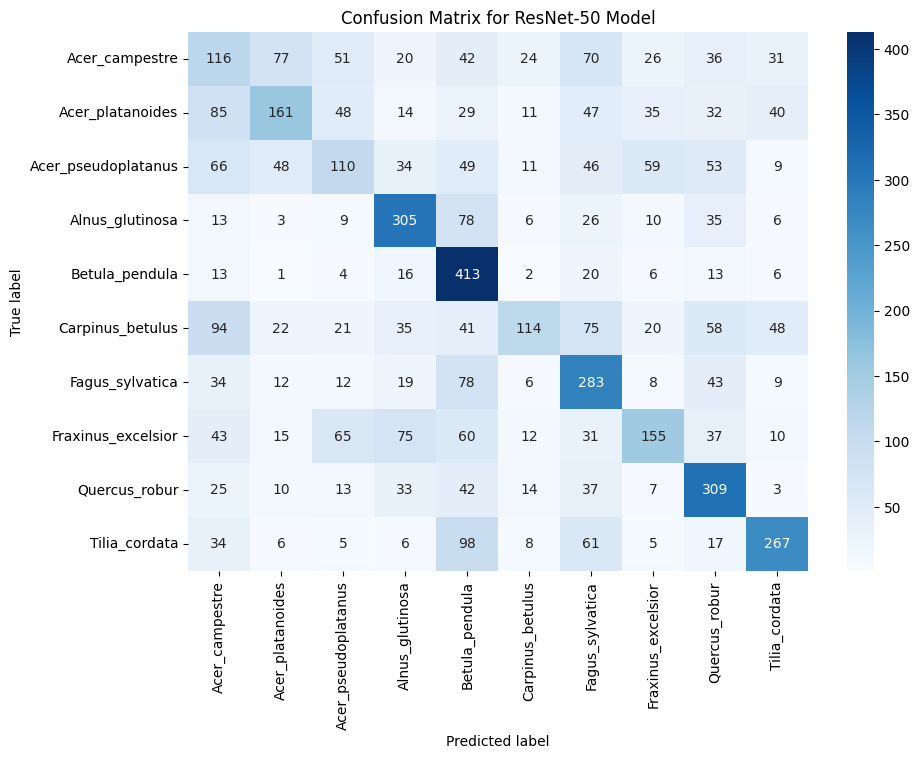

In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Concatenate, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.image import resize
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping  # Importing ModelCheckpoint and EarlyStopping
from sklearn.model_selection import train_test_split  # Importing train_test_split

# Define paths
base_path = "/content/drive/MyDrive/MainDataFolder/CombinedDataset"
species = ['Quercus_robur', 'Carpinus_betulus', 'Acer_campestre', 'Tilia_cordata',
           'Betula_pendula', 'Alnus_glutinosa', 'Acer_pseudoplatanus',
           'Fagus_sylvatica', 'Fraxinus_excelsior', 'Acer_platanoides']

# Load data from .npy files and downsample to 64x64
def load_data(target_size=(64, 64)):
    images = []
    kds = []
    bhs = []
    labels = []
    for specie in species:
        print(f"Loading data for {specie}...")
        specie_images = np.load(Path(base_path) / f"{specie}_RGBI_combined.npy")
        specie_kds = np.load(Path(base_path) / f"{specie}_KD_combined.npy")
        specie_bhs = np.load(Path(base_path) / f"{specie}_BH_combined.npy")
        specie_labels = np.load(Path(base_path) / f"{specie}_label_combined.npy")

        # Use only the first 3 channels (RGB)
        specie_images = specie_images[..., :3]

        # Sample 2500 instances from each species
        indices = np.random.choice(len(specie_images), 2500, replace=False)
        specie_images_sampled = specie_images[indices]

        # Downsample images to target size
        specie_images_resized = np.array([resize(img, target_size).numpy() / 255.0 for img in specie_images_sampled])

        images.append(specie_images_resized)
        kds.append(specie_kds[indices])
        bhs.append(specie_bhs[indices])
        labels.append(specie_labels[indices])

    images = np.concatenate(images)
    kds = np.concatenate(kds)
    bhs = np.concatenate(bhs)
    labels = np.concatenate(labels)
    return images, kds, bhs, labels

# Load and preprocess data
print("Loading and preprocessing data...")
rgb_images, kd_values, bh_values, labels = load_data()

# Encode labels
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

print(f"Loaded {len(rgb_images)} images with shape {rgb_images.shape}.")

# Split data into training and testing sets
print("Splitting data into training and testing sets...")
X_train_img, X_test_img, y_train, y_test = train_test_split(rgb_images, labels_encoded, test_size=0.2, random_state=42)
X_train_kd, X_test_kd = train_test_split(kd_values, test_size=0.2, random_state=42)
X_train_bh, X_test_bh = train_test_split(bh_values, test_size=0.2, random_state=42)

print(f"Data splitting completed. Training set size: {len(X_train_img)}, Testing set size: {len(X_test_img)}")

# Define the ResNet-50 based model
def create_resnet_model(input_image_size=(64, 64, 3), input_kd_size=(1,), input_bh_size=(1,), num_classes=10):
    base_model = ResNet50(include_top=False, weights='imagenet', input_shape=input_image_size)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)

    # KD and BH input branches
    kd_input = Input(shape=input_kd_size, name='kd_input')
    bh_input = Input(shape=input_bh_size, name='bh_input')

    # Combine branches
    combined = Concatenate()([x, kd_input, bh_input])
    combined = Dense(128, activation='relu')(combined)
    combined = Dropout(0.5)(combined)
    output = Dense(num_classes, activation='softmax')(combined)

    model = Model(inputs=[base_model.input, kd_input, bh_input], outputs=output)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Create and train the ResNet-50 model
input_image_size = X_train_img.shape[1:]
input_kd_size = (1,)
input_bh_size = (1,)
num_classes = len(np.unique(y_train))

print(f"Creating ResNet-50 model with input sizes {input_image_size}, {input_kd_size}, {input_bh_size}, and {num_classes} classes...")
model = create_resnet_model(input_image_size=input_image_size, input_kd_size=input_kd_size, input_bh_size=input_bh_size, num_classes=num_classes)
model.summary()

checkpoint_filepath = '/content/drive/MyDrive/MainDataFolder/checkpoints/resnet50_2500_RGB/combined_model_checkpoint.h5'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True
)

early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

print("Training ResNet-50 model...")
history = model.fit(
    [X_train_img, X_train_kd, X_train_bh], y_train,
    validation_data=([X_test_img, X_test_kd, X_test_bh], y_test),
    epochs=50, batch_size=32,
    callbacks=[model_checkpoint_callback, early_stopping_callback]
)
print("Model training completed.")

# Save the model
model_save_path = "/content/drive/MyDrive/MainDataFolder/AIModels/resnet50_2500_RGB_combined_model.h5"
model.save(model_save_path)
print(f"Model saved as {model_save_path}")

# Evaluate the model
def evaluate_model(model, images, kds, bhs, labels, batch_size=128):
    preds = model.predict([images, kds, bhs], batch_size=batch_size)
    preds_labels = np.argmax(preds, axis=1)

    accuracy = accuracy_score(labels, preds_labels)
    cm = confusion_matrix(labels, preds_labels)
    report = classification_report(labels, preds_labels, output_dict=True)
    return accuracy, cm, report

print("Evaluating ResNet-50 model...")
accuracy, cm, report = evaluate_model(model, X_test_img, X_test_kd, X_test_bh, y_test)

print(f"ResNet-50 Model - Accuracy: {accuracy}")
print("ResNet-50 Model - Classification Report:")
print(classification_report(y_test, np.argmax(model.predict([X_test_img, X_test_kd, X_test_bh]), axis=1)))

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix for ResNet-50 Model')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()


### Resnet50 with 2500 sample from each species for 'RGB' bands with Data Augmentation,Learning Rate Adjustment and Early Stopping

Loading and preprocessing data...
Loading data for Quercus_robur...
Loading data for Carpinus_betulus...
Loading data for Acer_campestre...
Loading data for Tilia_cordata...
Loading data for Betula_pendula...
Loading data for Alnus_glutinosa...
Loading data for Acer_pseudoplatanus...
Loading data for Fagus_sylvatica...
Loading data for Fraxinus_excelsior...
Loading data for Acer_platanoides...
Loaded 25000 images with shape (25000, 64, 64, 3).
Splitting data into training and testing sets...
Data splitting completed. Training set size: 20000, Testing set size: 5000
Creating ResNet-50 model with input sizes (64, 64, 3), (1,), (1,), and 10 classes...
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                             

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved as /content/drive/MyDrive/MainDataFolder/AIModels/resnet50_2500_RGB_Aug_combined_model.h5
Evaluating ResNet-50 model...
40/40 [==============================] - 2s 36ms/step
ResNet-50 Model - Accuracy: 0.5028
ResNet-50 Model - Classification Report:
157/157 [==============================] - 2s 12ms/step
              precision    recall  f1-score   support

           0       0.27      0.37      0.31       493
           1       0.47      0.52      0.49       502
           2       0.36      0.14      0.20       485
           3       0.62      0.68      0.65       491
           4       0.74      0.72      0.73       494
           5       0.41      0.48      0.44       528
           6       0.47      0.56      0.51       504
           7       0.44      0.30      0.36       503
           8       0.54      0.57      0.55       493
           9       0.72      0.67      0.70       507

    accuracy                           0.50      5000
   macro avg       0.50      0.5

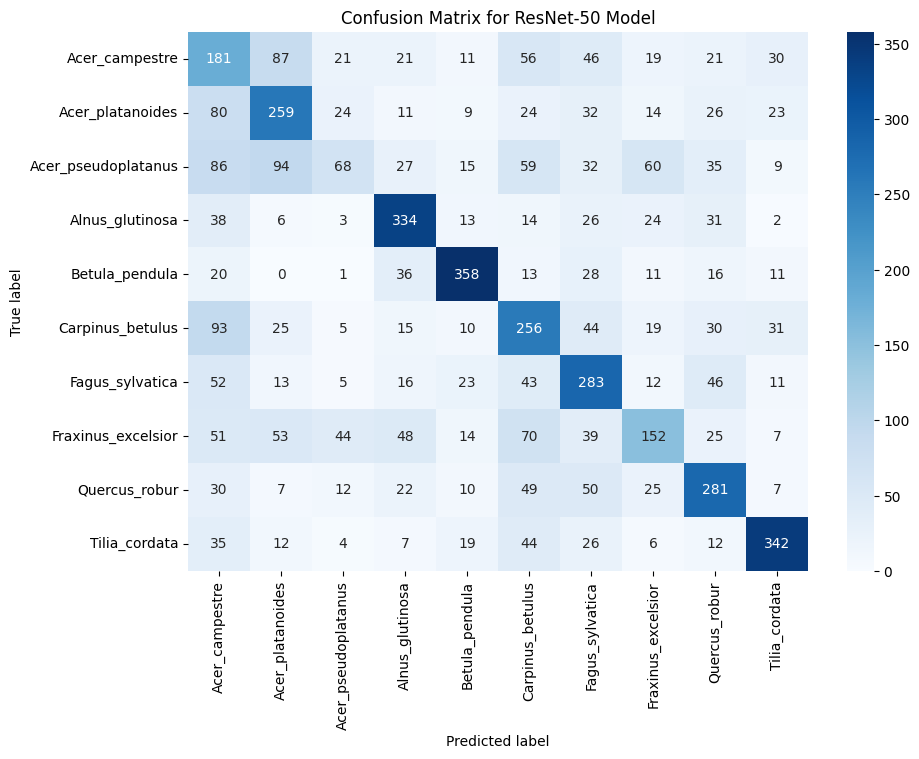

In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Concatenate, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.image import resize
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define paths
base_path = "/content/drive/MyDrive/MainDataFolder/CombinedDataset"
species = ['Quercus_robur', 'Carpinus_betulus', 'Acer_campestre', 'Tilia_cordata',
           'Betula_pendula', 'Alnus_glutinosa', 'Acer_pseudoplatanus',
           'Fagus_sylvatica', 'Fraxinus_excelsior', 'Acer_platanoides']

# Load data from .npy files and downsample to 64x64
def load_data(target_size=(64, 64)):
    images = []
    kds = []
    bhs = []
    labels = []
    for specie in species:
        print(f"Loading data for {specie}...")
        specie_images = np.load(Path(base_path) / f"{specie}_RGBI_combined.npy")
        specie_kds = np.load(Path(base_path) / f"{specie}_KD_combined.npy")
        specie_bhs = np.load(Path(base_path) / f"{specie}_BH_combined.npy")
        specie_labels = np.load(Path(base_path) / f"{specie}_label_combined.npy")

        # Use only the first 3 channels (RGB)
        specie_images = specie_images[..., :3]

        # Sample 2500 instances from each species
        indices = np.random.choice(len(specie_images), 2500, replace=False)
        specie_images_sampled = specie_images[indices]

        # Downsample images to target size
        specie_images_resized = np.array([resize(img, target_size).numpy() / 255.0 for img in specie_images_sampled])

        images.append(specie_images_resized)
        kds.append(specie_kds[indices])
        bhs.append(specie_bhs[indices])
        labels.append(specie_labels[indices])

    images = np.concatenate(images)
    kds = np.concatenate(kds)
    bhs = np.concatenate(bhs)
    labels = np.concatenate(labels)
    return images, kds, bhs, labels

# Load and preprocess data
print("Loading and preprocessing data...")
rgb_images, kd_values, bh_values, labels = load_data()

# Encode labels
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

print(f"Loaded {len(rgb_images)} images with shape {rgb_images.shape}.")

# Split data into training and testing sets
print("Splitting data into training and testing sets...")
X_train_img, X_test_img, y_train, y_test = train_test_split(rgb_images, labels_encoded, test_size=0.2, random_state=42)
X_train_kd, X_test_kd = train_test_split(kd_values, test_size=0.2, random_state=42)
X_train_bh, X_test_bh = train_test_split(bh_values, test_size=0.2, random_state=42)

print(f"Data splitting completed. Training set size: {len(X_train_img)}, Testing set size: {len(X_test_img)}")

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

class CustomDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, image_data, kd_data, bh_data, labels, batch_size, datagen):
        self.image_data = image_data
        self.kd_data = kd_data
        self.bh_data = bh_data
        self.labels = labels
        self.batch_size = batch_size
        self.datagen = datagen
        self.indices = np.arange(len(self.image_data))

    def __len__(self):
        return len(self.image_data) // self.batch_size

    def __getitem__(self, index):
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        batch_images = self.image_data[batch_indices]
        batch_kd = self.kd_data[batch_indices]
        batch_bh = self.bh_data[batch_indices]
        batch_labels = self.labels[batch_indices]

        augmented_images = next(self.datagen.flow(batch_images, batch_size=self.batch_size, shuffle=False))
        return [augmented_images, batch_kd, batch_bh], batch_labels

    def on_epoch_end(self):
        np.random.shuffle(self.indices)

# Define the ResNet-50 based model
def create_resnet_model(input_image_size=(64, 64, 3), input_kd_size=(1,), input_bh_size=(1,), num_classes=10):
    base_model = ResNet50(include_top=False, weights='imagenet', input_shape=input_image_size)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)

    # KD and BH input branches
    kd_input = Input(shape=input_kd_size, name='kd_input')
    bh_input = Input(shape=input_bh_size, name='bh_input')

    # Combine branches
    combined = Concatenate()([x, kd_input, bh_input])
    combined = Dense(128, activation='relu')(combined)
    combined = Dropout(0.5)(combined)
    output = Dense(num_classes, activation='softmax')(combined)

    model = Model(inputs=[base_model.input, kd_input, bh_input], outputs=output)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Create and train the ResNet-50 model
input_image_size = X_train_img.shape[1:]
input_kd_size = (1,)
input_bh_size = (1,)
num_classes = len(np.unique(y_train))

print(f"Creating ResNet-50 model with input sizes {input_image_size}, {input_kd_size}, {input_bh_size}, and {num_classes} classes...")
model = create_resnet_model(input_image_size=input_image_size, input_kd_size=input_kd_size, input_bh_size=input_bh_size, num_classes=num_classes)
model.summary()

checkpoint_filepath = '/content/drive/MyDrive/MainDataFolder/checkpoints/resnet50_RGB_Aug_2500/combined_model_checkpoint.h5'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True
)

early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

reduce_lr_callback = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=5,
    min_lr=1e-6
)

train_generator = CustomDataGenerator(X_train_img, X_train_kd, X_train_bh, y_train, batch_size=32, datagen=datagen)
validation_data = ([X_test_img, X_test_kd, X_test_bh], y_test)

print("Training ResNet-50 model...")
history = model.fit(
    train_generator,
    validation_data=validation_data,
    epochs=50,
    callbacks=[model_checkpoint_callback, early_stopping_callback, reduce_lr_callback]
)
print("Model training completed.")

# Save the model
model_save_path = "/content/drive/MyDrive/MainDataFolder/AIModels/resnet50_2500_RGB_Aug_combined_model.h5"
model.save(model_save_path)
print(f"Model saved as {model_save_path}")

# Evaluate the model
def evaluate_model(model, images, kds, bhs, labels, batch_size=128):
    preds = model.predict([images, kds, bhs], batch_size=batch_size)
    preds_labels = np.argmax(preds, axis=1)

    accuracy = accuracy_score(labels, preds_labels)
    cm = confusion_matrix(labels, preds_labels)
    report = classification_report(labels, preds_labels, output_dict=True)
    return accuracy, cm, report

print("Evaluating ResNet-50 model...")
accuracy, cm, report = evaluate_model(model, X_test_img, X_test_kd, X_test_bh, y_test)

print(f"ResNet-50 Model - Accuracy: {accuracy}")
print("ResNet-50 Model - Classification Report:")
print(classification_report(y_test, np.argmax(model.predict([X_test_img, X_test_kd, X_test_bh]), axis=1)))

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix for ResNet-50 Model')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()


### Resnet50 with 2500 sample from each species for 'IRG' bands with Data Augmentation,Learning Rate Adjustment and Early Stopping --> specie_images = specie_images[..., [3, 0, 1]] --> [I,R,G]

Loading and preprocessing data...
Loading data for Quercus_robur...
Loading data for Carpinus_betulus...
Loading data for Acer_campestre...
Loading data for Tilia_cordata...
Loading data for Betula_pendula...
Loading data for Alnus_glutinosa...
Loading data for Acer_pseudoplatanus...
Loading data for Fagus_sylvatica...
Loading data for Fraxinus_excelsior...
Loading data for Acer_platanoides...
Loaded 25000 images with shape (25000, 64, 64, 3).
Splitting data into training and testing sets...
Data splitting completed. Training set size: 20000, Testing set size: 5000
Creating ResNet-50 model with input sizes (64, 64, 3), (1,), (1,), and 10 classes...
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                             

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved as /content/drive/MyDrive/MainDataFolder/AIModels/resnet50_2500_IRG_Aug_combined_model.h5
Evaluating ResNet-50 model...
40/40 [==============================] - 2s 36ms/step
ResNet-50 Model - Accuracy: 0.4436
ResNet-50 Model - Classification Report:
157/157 [==============================] - 2s 12ms/step
              precision    recall  f1-score   support

           0       0.19      0.24      0.21       493
           1       0.31      0.68      0.42       502
           2       0.23      0.12      0.16       485
           3       0.61      0.64      0.63       491
           4       0.74      0.70      0.72       494
           5       0.26      0.10      0.14       528
           6       0.55      0.47      0.51       504
           7       0.34      0.37      0.35       503
           8       0.67      0.42      0.51       493
           9       0.66      0.71      0.68       507

    accuracy                           0.44      5000
   macro avg       0.46      0.4

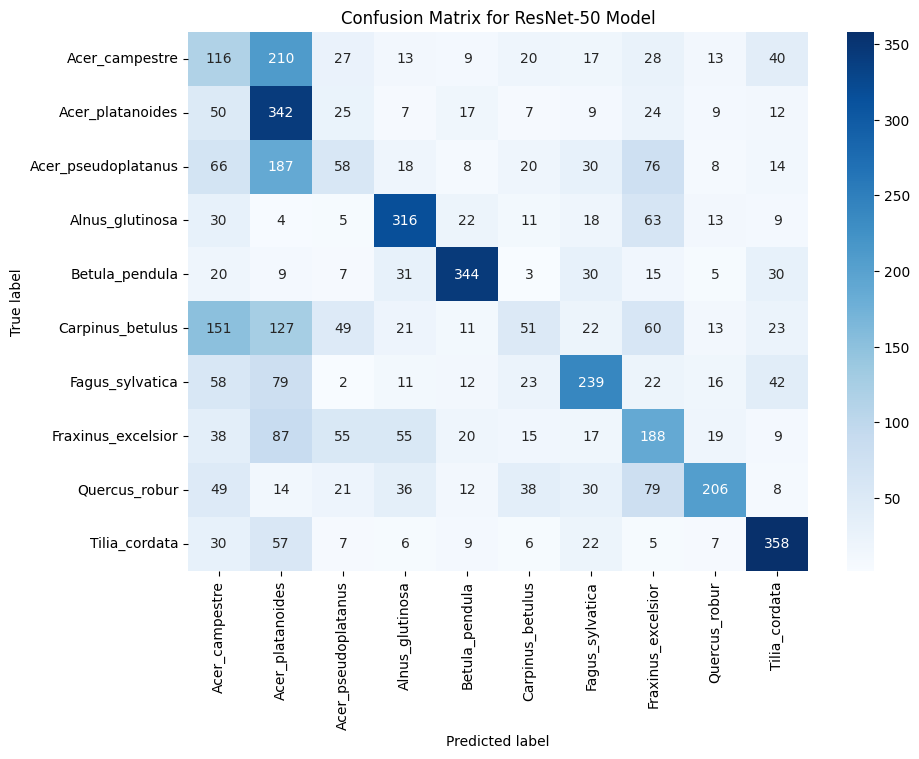

In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Concatenate, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.image import resize
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define paths
base_path = "/content/drive/MyDrive/MainDataFolder/CombinedDataset"
species = ['Quercus_robur', 'Carpinus_betulus', 'Acer_campestre', 'Tilia_cordata',
           'Betula_pendula', 'Alnus_glutinosa', 'Acer_pseudoplatanus',
           'Fagus_sylvatica', 'Fraxinus_excelsior', 'Acer_platanoides']

# Load data from .npy files and downsample to 64x64
def load_data(target_size=(64, 64)):
    images = []
    kds = []
    bhs = []
    labels = []
    for specie in species:
        print(f"Loading data for {specie}...")
        specie_images = np.load(Path(base_path) / f"{specie}_RGBI_combined.npy")
        specie_kds = np.load(Path(base_path) / f"{specie}_KD_combined.npy")
        specie_bhs = np.load(Path(base_path) / f"{specie}_BH_combined.npy")
        specie_labels = np.load(Path(base_path) / f"{specie}_label_combined.npy")

        # Use only the first 3 channels (RGB)
        specie_images = specie_images[..., [3, 0, 1]]

        # Sample 2500 instances from each species
        indices = np.random.choice(len(specie_images), 2500, replace=False)
        specie_images_sampled = specie_images[indices]

        # Downsample images to target size
        specie_images_resized = np.array([resize(img, target_size).numpy() / 255.0 for img in specie_images_sampled])

        images.append(specie_images_resized)
        kds.append(specie_kds[indices])
        bhs.append(specie_bhs[indices])
        labels.append(specie_labels[indices])

    images = np.concatenate(images)
    kds = np.concatenate(kds)
    bhs = np.concatenate(bhs)
    labels = np.concatenate(labels)
    return images, kds, bhs, labels

# Load and preprocess data
print("Loading and preprocessing data...")
rgb_images, kd_values, bh_values, labels = load_data()

# Encode labels
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

print(f"Loaded {len(rgb_images)} images with shape {rgb_images.shape}.")

# Split data into training and testing sets
print("Splitting data into training and testing sets...")
X_train_img, X_test_img, y_train, y_test = train_test_split(rgb_images, labels_encoded, test_size=0.2, random_state=42)
X_train_kd, X_test_kd = train_test_split(kd_values, test_size=0.2, random_state=42)
X_train_bh, X_test_bh = train_test_split(bh_values, test_size=0.2, random_state=42)

print(f"Data splitting completed. Training set size: {len(X_train_img)}, Testing set size: {len(X_test_img)}")

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

class CustomDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, image_data, kd_data, bh_data, labels, batch_size, datagen):
        self.image_data = image_data
        self.kd_data = kd_data
        self.bh_data = bh_data
        self.labels = labels
        self.batch_size = batch_size
        self.datagen = datagen
        self.indices = np.arange(len(self.image_data))

    def __len__(self):
        return len(self.image_data) // self.batch_size

    def __getitem__(self, index):
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        batch_images = self.image_data[batch_indices]
        batch_kd = self.kd_data[batch_indices]
        batch_bh = self.bh_data[batch_indices]
        batch_labels = self.labels[batch_indices]

        augmented_images = next(self.datagen.flow(batch_images, batch_size=self.batch_size, shuffle=False))
        return [augmented_images, batch_kd, batch_bh], batch_labels

    def on_epoch_end(self):
        np.random.shuffle(self.indices)

# Define the ResNet-50 based model
def create_resnet_model(input_image_size=(64, 64, 3), input_kd_size=(1,), input_bh_size=(1,), num_classes=10):
    base_model = ResNet50(include_top=False, weights='imagenet', input_shape=input_image_size)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)

    # KD and BH input branches
    kd_input = Input(shape=input_kd_size, name='kd_input')
    bh_input = Input(shape=input_bh_size, name='bh_input')

    # Combine branches
    combined = Concatenate()([x, kd_input, bh_input])
    combined = Dense(128, activation='relu')(combined)
    combined = Dropout(0.5)(combined)
    output = Dense(num_classes, activation='softmax')(combined)

    model = Model(inputs=[base_model.input, kd_input, bh_input], outputs=output)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Create and train the ResNet-50 model
input_image_size = X_train_img.shape[1:]
input_kd_size = (1,)
input_bh_size = (1,)
num_classes = len(np.unique(y_train))

print(f"Creating ResNet-50 model with input sizes {input_image_size}, {input_kd_size}, {input_bh_size}, and {num_classes} classes...")
model = create_resnet_model(input_image_size=input_image_size, input_kd_size=input_kd_size, input_bh_size=input_bh_size, num_classes=num_classes)
model.summary()

checkpoint_filepath = '/content/drive/MyDrive/MainDataFolder/checkpoints/resnet50_IRG_Aug_2500/combined_model_checkpoint.h5'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True
)

early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

reduce_lr_callback = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=5,
    min_lr=1e-6
)

train_generator = CustomDataGenerator(X_train_img, X_train_kd, X_train_bh, y_train, batch_size=32, datagen=datagen)
validation_data = ([X_test_img, X_test_kd, X_test_bh], y_test)

print("Training ResNet-50 model...")
history = model.fit(
    train_generator,
    validation_data=validation_data,
    epochs=50,
    callbacks=[model_checkpoint_callback, early_stopping_callback, reduce_lr_callback]
)
print("Model training completed.")

# Save the model
model_save_path = "/content/drive/MyDrive/MainDataFolder/AIModels/resnet50_2500_IRG_Aug_combined_model.h5"
model.save(model_save_path)
print(f"Model saved as {model_save_path}")

# Evaluate the model
def evaluate_model(model, images, kds, bhs, labels, batch_size=128):
    preds = model.predict([images, kds, bhs], batch_size=batch_size)
    preds_labels = np.argmax(preds, axis=1)

    accuracy = accuracy_score(labels, preds_labels)
    cm = confusion_matrix(labels, preds_labels)
    report = classification_report(labels, preds_labels, output_dict=True)
    return accuracy, cm, report

print("Evaluating ResNet-50 model...")
accuracy, cm, report = evaluate_model(model, X_test_img, X_test_kd, X_test_bh, y_test)

print(f"ResNet-50 Model - Accuracy: {accuracy}")
print("ResNet-50 Model - Classification Report:")
print(classification_report(y_test, np.argmax(model.predict([X_test_img, X_test_kd, X_test_bh]), axis=1)))

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix for ResNet-50 Model')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()


### Resnet50 with 2500 sample from each species for 'IGB' bands with Data Augmentation,Learning Rate Adjustment and Early Stopping --> specie_images = specie_images[..., [3, 1, 2]] --> [I,G,B]

Loading and preprocessing data...
Loading data for Quercus_robur...
Loading data for Carpinus_betulus...
Loading data for Acer_campestre...
Loading data for Tilia_cordata...
Loading data for Betula_pendula...
Loading data for Alnus_glutinosa...
Loading data for Acer_pseudoplatanus...
Loading data for Fagus_sylvatica...
Loading data for Fraxinus_excelsior...
Loading data for Acer_platanoides...
Loaded 25000 images with shape (25000, 64, 64, 3).
Splitting data into training and testing sets...
Data splitting completed. Training set size: 20000, Testing set size: 5000
Creating ResNet-50 model with input sizes (64, 64, 3), (1,), (1,), and 10 classes...
94765736/94765736 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 64, 64, 3)]          0      

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved as /content/drive/MyDrive/MainDataFolder/AIModels/resnet50_2500_IGB_Aug_combined_model.h5
Evaluating ResNet-50 model...
40/40 [==============================] - 4s 33ms/step
ResNet-50 Model - Accuracy: 0.3916
ResNet-50 Model - Classification Report:
157/157 [==============================] - 2s 12ms/step
              precision    recall  f1-score   support

           0       0.20      0.23      0.21       493
           1       0.29      0.68      0.40       502
           2       0.23      0.11      0.15       485
           3       0.65      0.50      0.57       491
           4       0.63      0.66      0.64       494
           5       0.41      0.23      0.30       528
           6       0.40      0.39      0.39       504
           7       0.28      0.10      0.15       503
           8       0.54      0.30      0.39       493
           9       0.42      0.70      0.52       507

    accuracy                           0.39      5000
   macro avg       0.40      0.3

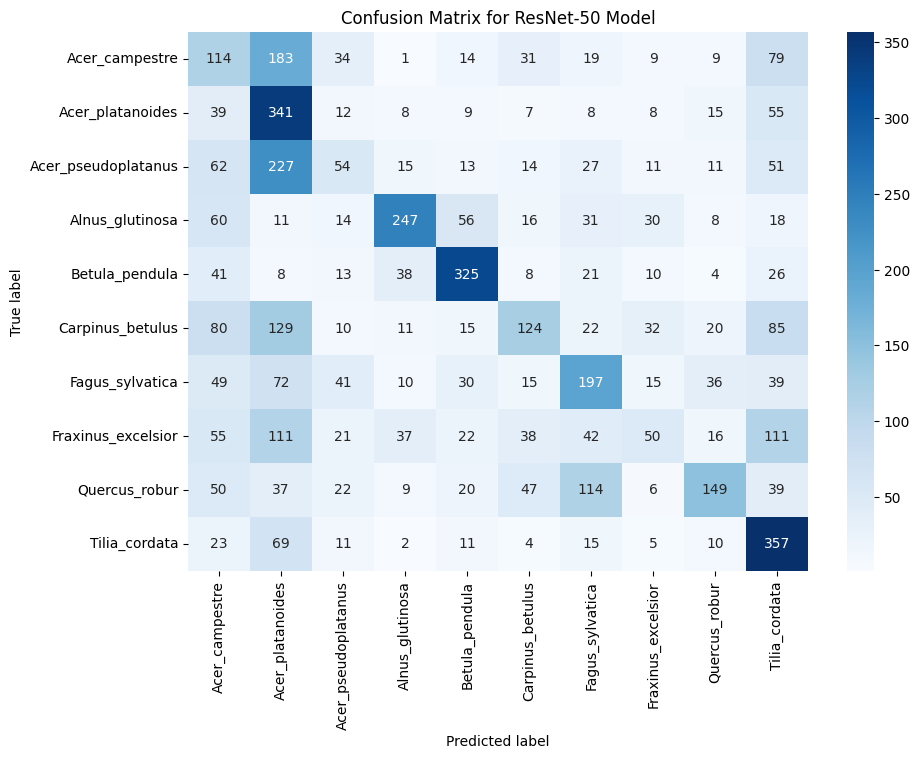

In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Concatenate, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.image import resize
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define paths
base_path = "/content/drive/MyDrive/MainDataFolder/CombinedDataset"
species = ['Quercus_robur', 'Carpinus_betulus', 'Acer_campestre', 'Tilia_cordata',
           'Betula_pendula', 'Alnus_glutinosa', 'Acer_pseudoplatanus',
           'Fagus_sylvatica', 'Fraxinus_excelsior', 'Acer_platanoides']

# Load data from .npy files and downsample to 64x64
def load_data(target_size=(64, 64)):
    images = []
    kds = []
    bhs = []
    labels = []
    for specie in species:
        print(f"Loading data for {specie}...")
        specie_images = np.load(Path(base_path) / f"{specie}_RGBI_combined.npy")
        specie_kds = np.load(Path(base_path) / f"{specie}_KD_combined.npy")
        specie_bhs = np.load(Path(base_path) / f"{specie}_BH_combined.npy")
        specie_labels = np.load(Path(base_path) / f"{specie}_label_combined.npy")

        # Use only the first 3 channels (RGB)
        specie_images = specie_images[..., [3, 1, 2]]

        # Sample 2500 instances from each species
        indices = np.random.choice(len(specie_images), 2500, replace=False)
        specie_images_sampled = specie_images[indices]

        # Downsample images to target size
        specie_images_resized = np.array([resize(img, target_size).numpy() / 255.0 for img in specie_images_sampled])

        images.append(specie_images_resized)
        kds.append(specie_kds[indices])
        bhs.append(specie_bhs[indices])
        labels.append(specie_labels[indices])

    images = np.concatenate(images)
    kds = np.concatenate(kds)
    bhs = np.concatenate(bhs)
    labels = np.concatenate(labels)
    return images, kds, bhs, labels

# Load and preprocess data
print("Loading and preprocessing data...")
rgb_images, kd_values, bh_values, labels = load_data()

# Encode labels
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

print(f"Loaded {len(rgb_images)} images with shape {rgb_images.shape}.")

# Split data into training and testing sets
print("Splitting data into training and testing sets...")
X_train_img, X_test_img, y_train, y_test = train_test_split(rgb_images, labels_encoded, test_size=0.2, random_state=42)
X_train_kd, X_test_kd = train_test_split(kd_values, test_size=0.2, random_state=42)
X_train_bh, X_test_bh = train_test_split(bh_values, test_size=0.2, random_state=42)

print(f"Data splitting completed. Training set size: {len(X_train_img)}, Testing set size: {len(X_test_img)}")

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

class CustomDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, image_data, kd_data, bh_data, labels, batch_size, datagen):
        self.image_data = image_data
        self.kd_data = kd_data
        self.bh_data = bh_data
        self.labels = labels
        self.batch_size = batch_size
        self.datagen = datagen
        self.indices = np.arange(len(self.image_data))

    def __len__(self):
        return len(self.image_data) // self.batch_size

    def __getitem__(self, index):
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        batch_images = self.image_data[batch_indices]
        batch_kd = self.kd_data[batch_indices]
        batch_bh = self.bh_data[batch_indices]
        batch_labels = self.labels[batch_indices]

        augmented_images = next(self.datagen.flow(batch_images, batch_size=self.batch_size, shuffle=False))
        return [augmented_images, batch_kd, batch_bh], batch_labels

    def on_epoch_end(self):
        np.random.shuffle(self.indices)

# Define the ResNet-50 based model
def create_resnet_model(input_image_size=(64, 64, 3), input_kd_size=(1,), input_bh_size=(1,), num_classes=10):
    base_model = ResNet50(include_top=False, weights='imagenet', input_shape=input_image_size)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)

    # KD and BH input branches
    kd_input = Input(shape=input_kd_size, name='kd_input')
    bh_input = Input(shape=input_bh_size, name='bh_input')

    # Combine branches
    combined = Concatenate()([x, kd_input, bh_input])
    combined = Dense(128, activation='relu')(combined)
    combined = Dropout(0.5)(combined)
    output = Dense(num_classes, activation='softmax')(combined)

    model = Model(inputs=[base_model.input, kd_input, bh_input], outputs=output)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Create and train the ResNet-50 model
input_image_size = X_train_img.shape[1:]
input_kd_size = (1,)
input_bh_size = (1,)
num_classes = len(np.unique(y_train))

print(f"Creating ResNet-50 model with input sizes {input_image_size}, {input_kd_size}, {input_bh_size}, and {num_classes} classes...")
model = create_resnet_model(input_image_size=input_image_size, input_kd_size=input_kd_size, input_bh_size=input_bh_size, num_classes=num_classes)
model.summary()

checkpoint_filepath = '/content/drive/MyDrive/MainDataFolder/checkpoints/resnet50_IGB_Aug_2500/combined_model_checkpoint.h5'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True
)

early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

reduce_lr_callback = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=5,
    min_lr=1e-6
)

train_generator = CustomDataGenerator(X_train_img, X_train_kd, X_train_bh, y_train, batch_size=32, datagen=datagen)
validation_data = ([X_test_img, X_test_kd, X_test_bh], y_test)

print("Training ResNet-50 model...")
history = model.fit(
    train_generator,
    validation_data=validation_data,
    epochs=50,
    callbacks=[model_checkpoint_callback, early_stopping_callback, reduce_lr_callback]
)
print("Model training completed.")

# Save the model
model_save_path = "/content/drive/MyDrive/MainDataFolder/AIModels/resnet50_2500_IGB_Aug_combined_model.h5"
model.save(model_save_path)
print(f"Model saved as {model_save_path}")

# Evaluate the model
def evaluate_model(model, images, kds, bhs, labels, batch_size=128):
    preds = model.predict([images, kds, bhs], batch_size=batch_size)
    preds_labels = np.argmax(preds, axis=1)

    accuracy = accuracy_score(labels, preds_labels)
    cm = confusion_matrix(labels, preds_labels)
    report = classification_report(labels, preds_labels, output_dict=True)
    return accuracy, cm, report

print("Evaluating ResNet-50 model...")
accuracy, cm, report = evaluate_model(model, X_test_img, X_test_kd, X_test_bh, y_test)

print(f"ResNet-50 Model - Accuracy: {accuracy}")
print("ResNet-50 Model - Classification Report:")
print(classification_report(y_test, np.argmax(model.predict([X_test_img, X_test_kd, X_test_bh]), axis=1)))

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix for ResNet-50 Model')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()


###Resnet 50 with RGB bands Ignoring KH and BD value

Loading and preprocessing data...
Loading data for Quercus_robur...
Loading data for Carpinus_betulus...
Loading data for Acer_campestre...
Loading data for Tilia_cordata...
Loading data for Betula_pendula...
Loading data for Alnus_glutinosa...
Loading data for Acer_pseudoplatanus...
Loading data for Fagus_sylvatica...
Loading data for Fraxinus_excelsior...
Loading data for Acer_platanoides...
Loaded 25000 images with shape (25000, 64, 64, 3).
Splitting data into training and testing sets...
Data splitting completed. Training set size: 20000, Testing set size: 5000
Creating ResNet-50 model with input size (64, 64, 3) and 10 classes...
94765736/94765736 [==============================] - 5s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 64, 64, 3)]          0         []         

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved as /content/drive/MyDrive/MainDataFolder/AIModels/resnet50_2500NO_KH_BD_combined_model.h5
Evaluating ResNet-50 model...
40/40 [==============================] - 4s 34ms/step
ResNet-50 Model - Accuracy: 0.4438
ResNet-50 Model - Classification Report:
157/157 [==============================] - 2s 12ms/step
              precision    recall  f1-score   support

           0       0.17      0.13      0.15       493
           1       0.30      0.67      0.42       502
           2       0.25      0.15      0.19       485
           3       0.62      0.64      0.63       491
           4       0.65      0.72      0.68       494
           5       0.67      0.14      0.23       528
           6       0.39      0.70      0.50       504
           7       0.44      0.17      0.25       503
           8       0.54      0.45      0.49       493
           9       0.62      0.67      0.64       507

    accuracy                           0.44      5000
   macro avg       0.46      0.4

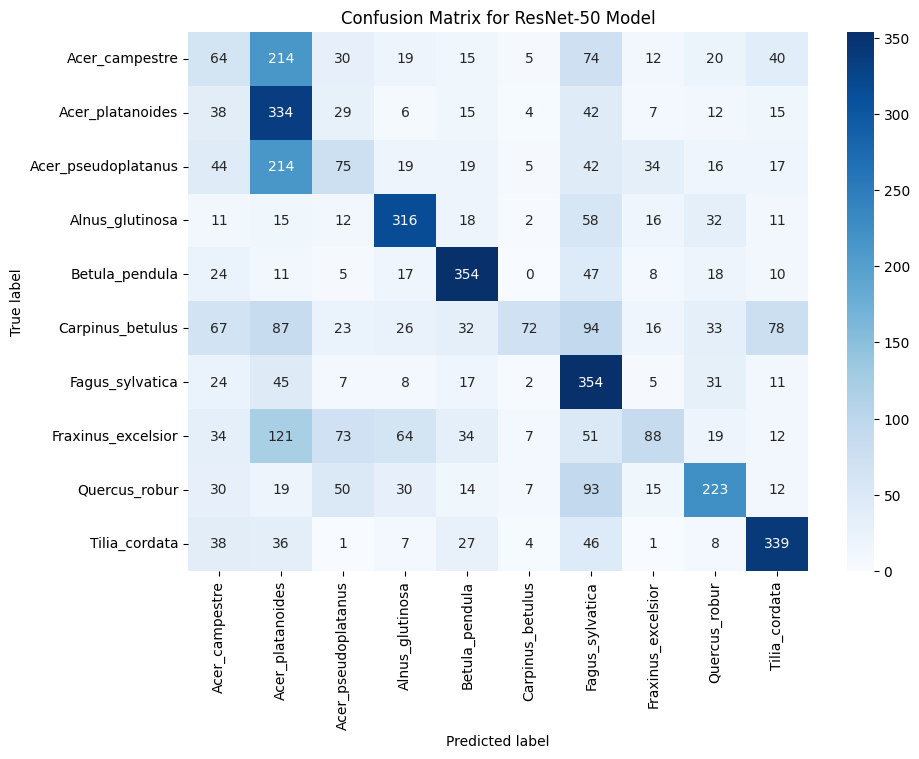

In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.image import resize
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define paths
base_path = "/content/drive/MyDrive/MainDataFolder/CombinedDataset"
species = ['Quercus_robur', 'Carpinus_betulus', 'Acer_campestre', 'Tilia_cordata',
           'Betula_pendula', 'Alnus_glutinosa', 'Acer_pseudoplatanus',
           'Fagus_sylvatica', 'Fraxinus_excelsior', 'Acer_platanoides']

# Load data from .npy files and downsample to 64x64
def load_data(target_size=(64, 64)):
    images = []
    labels = []
    for specie in species:
        print(f"Loading data for {specie}...")
        specie_images = np.load(Path(base_path) / f"{specie}_RGBI_combined.npy")
        specie_labels = np.load(Path(base_path) / f"{specie}_label_combined.npy")

        # Use only the first 3 channels (RGB)
        specie_images = specie_images[..., :3]

        # Sample 2500 instances from each species
        indices = np.random.choice(len(specie_images), 2500, replace=False)
        specie_images_sampled = specie_images[indices]

        # Downsample images to target size
        specie_images_resized = np.array([resize(img, target_size).numpy() / 255.0 for img in specie_images_sampled])

        images.append(specie_images_resized)
        labels.append(specie_labels[indices])

    images = np.concatenate(images)
    labels = np.concatenate(labels)
    return images, labels

# Load and preprocess data
print("Loading and preprocessing data...")
rgb_images, labels = load_data()

# Encode labels
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

print(f"Loaded {len(rgb_images)} images with shape {rgb_images.shape}.")

# Split data into training and testing sets
print("Splitting data into training and testing sets...")
X_train_img, X_test_img, y_train, y_test = train_test_split(rgb_images, labels_encoded, test_size=0.2, random_state=42)

print(f"Data splitting completed. Training set size: {len(X_train_img)}, Testing set size: {len(X_test_img)}")

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Define the ResNet-50 based model
def create_resnet_model(input_image_size=(64, 64, 3), num_classes=10):
    base_model = ResNet50(include_top=False, weights='imagenet', input_shape=input_image_size)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=output)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Create and train the ResNet-50 model
input_image_size = X_train_img.shape[1:]
num_classes = len(np.unique(y_train))

print(f"Creating ResNet-50 model with input size {input_image_size} and {num_classes} classes...")
model = create_resnet_model(input_image_size=input_image_size, num_classes=num_classes)
model.summary()

checkpoint_filepath = '/content/drive/MyDrive/MainDataFolder/checkpoints/resnet50_2500_NO_KH_BD/combined_model_checkpoint.h5'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True
)

early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

reduce_lr_callback = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=5,
    min_lr=1e-6
)

print("Training ResNet-50 model...")
history = model.fit(
    datagen.flow(X_train_img, y_train, batch_size=32),
    validation_data=(X_test_img, y_test),
    epochs=100,
    callbacks=[model_checkpoint_callback, early_stopping_callback, reduce_lr_callback]
)
print("Model training completed.")

# Save the model
model_save_path = "/content/drive/MyDrive/MainDataFolder/AIModels/resnet50_2500NO_KH_BD_combined_model.h5"
model.save(model_save_path)
print(f"Model saved as {model_save_path}")

# Evaluate the model
def evaluate_model(model, images, labels, batch_size=128):
    preds = model.predict(images, batch_size=batch_size)
    preds_labels = np.argmax(preds, axis=1)

    accuracy = accuracy_score(labels, preds_labels)
    cm = confusion_matrix(labels, preds_labels)
    report = classification_report(labels, preds_labels, output_dict=True)
    return accuracy, cm, report

print("Evaluating ResNet-50 model...")
accuracy, cm, report = evaluate_model(model, X_test_img, y_test)

print(f"ResNet-50 Model - Accuracy: {accuracy}")
print("ResNet-50 Model - Classification Report:")
print(classification_report(y_test, np.argmax(model.predict(X_test_img), axis=1)))

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix for ResNet-50 Model')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()


###Resnet 50 with RGB bands Ignoring KH and BD value but with with data augmentation, learning rate adjustment, and early stopping


Physical devices cannot be modified after being initialized
Loading combined data...
Loading data for Quercus_robur...
Loading data for Carpinus_betulus...
Loading data for Acer_campestre...
Loading data for Tilia_cordata...
Loading data for Betula_pendula...
Loading data for Alnus_glutinosa...
Loading data for Acer_pseudoplatanus...
Loading data for Fagus_sylvatica...
Loading data for Fraxinus_excelsior...
Loading data for Acer_platanoides...
Loaded 25000 images with shape (25000, 64, 64, 3).
Splitting data into training and testing sets...
Data splitting completed. Training set size: 20000, Testing set size: 5000
Shape of X_train_img: (20000, 64, 64, 3)
Shape of y_train: (20000,)
Shape of X_test_img: (5000, 64, 64, 3)
Shape of y_test: (5000,)
Any NaN values in X_train_img: False
Any Inf values in X_train_img: False
Any NaN values in y_train: False
Any Inf values in y_train: False
Creating model with input sizes (64, 64, 3) and 10 classes...
Model: "model_1"
__________________________

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


40/40 [==============================] - 1s 4ms/step
Model - Accuracy: 0.3016
Model - Classification Report:
157/157 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.13      0.03      0.04       493
           1       0.19      0.70      0.30       502
           2       0.11      0.09      0.10       485
           3       0.68      0.20      0.30       491
           4       0.67      0.45      0.54       494
           5       0.24      0.08      0.12       528
           6       0.30      0.34      0.32       504
           7       0.23      0.12      0.16       503
           8       0.50      0.31      0.39       493
           9       0.39      0.69      0.50       507

    accuracy                           0.30      5000
   macro avg       0.35      0.30      0.28      5000
weighted avg       0.34      0.30      0.28      5000



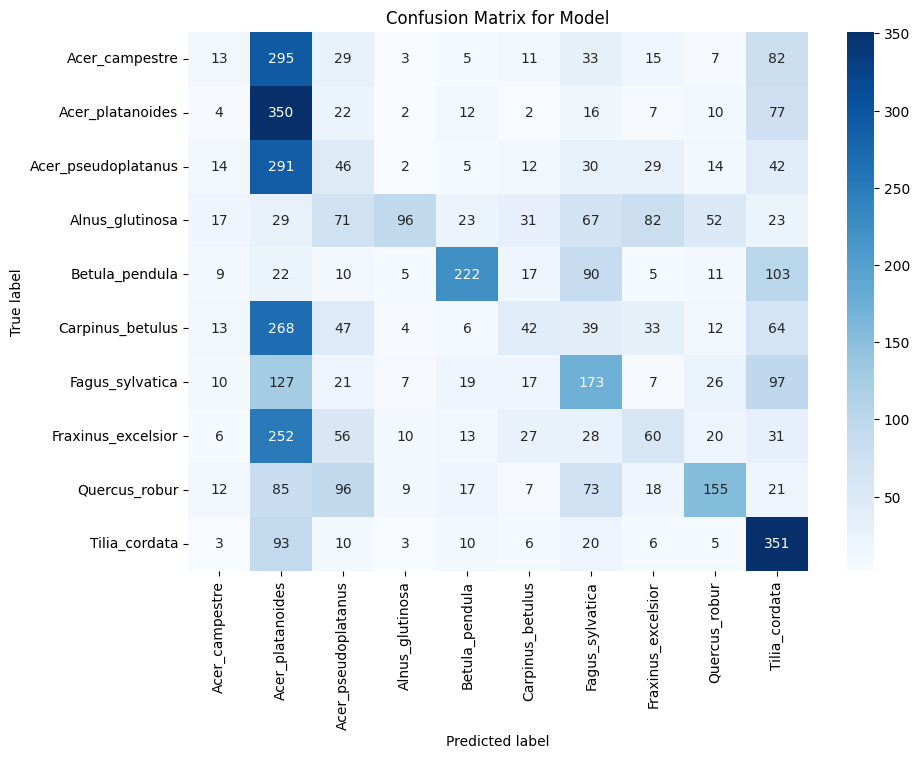

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, Flatten, Dropout, Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.image import resize
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd

# Set up GPU memory growth
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

# Enable mixed precision training
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

# Define paths
base_path = "/content/drive/MyDrive/MainDataFolder/CombinedDataset"
species = ['Quercus_robur', 'Carpinus_betulus', 'Acer_campestre', 'Tilia_cordata',
           'Betula_pendula', 'Alnus_glutinosa', 'Acer_pseudoplatanus',
           'Fagus_sylvatica', 'Fraxinus_excelsior', 'Acer_platanoides']

# Load data from .npy files and downsample to 64x64
def load_data(target_size=(64, 64)):
    images = []
    labels = []
    for specie in species:
        print(f"Loading data for {specie}...")
        specie_images = np.load(Path(base_path) / f"{specie}_RGBI_combined.npy")
        specie_labels = np.load(Path(base_path) / f"{specie}_label_combined.npy")

        # Sample 2500 instances from each species
        indices = np.random.choice(len(specie_images), 2500, replace=False)
        specie_images_sampled = specie_images[indices]

        # Downsample images to target size
        specie_images_resized = np.array([resize(img[:, :, :3], target_size).numpy() / 255.0 for img in specie_images_sampled])

        images.append(specie_images_resized)
        labels.append(specie_labels[indices])

    images = np.concatenate(images)
    labels = np.concatenate(labels)
    return images, labels

# Load combined data
print("Loading combined data...")
rgb_images, labels = load_data()

# Encode labels
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

print(f"Loaded {len(rgb_images)} images with shape {rgb_images.shape}.")

# Split data into training and testing sets
print("Splitting data into training and testing sets...")
X_train_img, X_test_img, y_train, y_test = train_test_split(rgb_images, labels, test_size=0.2, random_state=42)

print(f"Data splitting completed. Training set size: {len(X_train_img)}, Testing set size: {len(X_test_img)}")
print(f"Shape of X_train_img: {X_train_img.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of X_test_img: {X_test_img.shape}")
print(f"Shape of y_test: {y_test.shape}")

# Check for NaN and Inf values
print(f"Any NaN values in X_train_img: {np.isnan(X_train_img).any()}")
print(f"Any Inf values in X_train_img: {np.isinf(X_train_img).any()}")
print(f"Any NaN values in y_train: {np.isnan(y_train).any()}")
print(f"Any Inf values in y_train: {np.isinf(y_train).any()}")

# Define a CNN model
def combined_model(input_image_size=(64, 64, 3), num_classes=10):
    # Image input branch
    image_input = Input(shape=input_image_size, name='image_input')
    x = Conv2D(32, (3, 3), activation='relu')(image_input)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu')(x)
    x = GlobalAveragePooling2D()(x)

    combined = Dense(128, activation='relu')(x)
    combined = Dropout(0.5)(combined)
    output = Dense(num_classes, activation='softmax')(combined)

    # Model definition
    model = Model(inputs=image_input, outputs=output)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Create and train the model
input_image_size = X_train_img.shape[1:]
num_classes = len(np.unique(y_train))
print(f"Creating model with input sizes {input_image_size} and {num_classes} classes...")
model = combined_model(input_image_size=input_image_size, num_classes=num_classes)
model.summary()

checkpoint_filepath = '/content/drive/MyDrive/MainDataFolder/checkpoints/resnet50_2500_NO_KH_BD_WITH_DAUG/combined_model_checkpoint.h5'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True
)

early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

reduce_lr_callback = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=0.0001
)

# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

print("Training model...")
try:
    history = model.fit(
        datagen.flow(X_train_img, y_train, batch_size=32),
        validation_data=(X_test_img, y_test),
        epochs=50, batch_size=32,
        callbacks=[model_checkpoint_callback, early_stopping_callback, reduce_lr_callback]
    )
    print("Model training completed.")
except tf.errors.InvalidArgumentError as e:
    print(f"Error during training: {e}")

# Save the model
model_save_path = "/content/drive/MyDrive/MainDataFolder/AIModels/resnet50_2500_NO_KH_BD_WITH_DAUG_combined_model.h5"
model.save(model_save_path)
print(f"Model saved as {model_save_path}")

# Evaluate the model
def evaluate_model(model, images, labels, batch_size=128):
    preds = model.predict(images, batch_size=batch_size)
    preds_labels = np.argmax(preds, axis=1)

    accuracy = accuracy_score(labels, preds_labels)
    cm = confusion_matrix(labels, preds_labels)
    report = classification_report(labels, preds_labels, output_dict=True)
    return accuracy, cm, report

print("Evaluating model...")
accuracy, cm, report = evaluate_model(model, X_test_img, y_test)

print(f"Model - Accuracy: {accuracy}")
print("Model - Classification Report:")
print(classification_report(y_test, np.argmax(model.predict(X_test_img), axis=1)))

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix for Model')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()


##ResNet 101 Models

###ResNet 101 with 2500 sample from each species for RGB bands

Loading and preprocessing data...
Loading data for Quercus_robur...
Loading data for Carpinus_betulus...
Loading data for Acer_campestre...
Loading data for Tilia_cordata...
Loading data for Betula_pendula...
Loading data for Alnus_glutinosa...
Loading data for Acer_pseudoplatanus...
Loading data for Fagus_sylvatica...
Loading data for Fraxinus_excelsior...
Loading data for Acer_platanoides...
Loaded 25000 images with shape (25000, 64, 64, 3).
Splitting data into training and testing sets...
Data splitting completed. Training set size: 20000, Testing set size: 5000
Creating ResNet-101 model with input sizes (64, 64, 3), (1,), (1,), and 10 classes...
171446536/171446536 [==============================] - 8s 0us/step
Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 64, 64, 3)]          0 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved as /content/drive/MyDrive/MainDataFolder/AIModels/resnet101_2500_combined_model.h5
Evaluating ResNet-101 model...
40/40 [==============================] - 3s 26ms/step
ResNet-101 Model - Accuracy: 0.4562
ResNet-101 Model - Classification Report:
157/157 [==============================] - 2s 11ms/step
              precision    recall  f1-score   support

           0       0.26      0.18      0.21       493
           1       0.53      0.41      0.47       502
           2       0.29      0.09      0.14       485
           3       0.55      0.59      0.57       491
           4       0.87      0.50      0.63       494
           5       0.40      0.48      0.44       528
           6       0.42      0.52      0.47       504
           7       0.37      0.35      0.36       503
           8       0.33      0.72      0.45       493
           9       0.70      0.70      0.70       507

    accuracy                           0.46      5000
   macro avg       0.47      0.45   

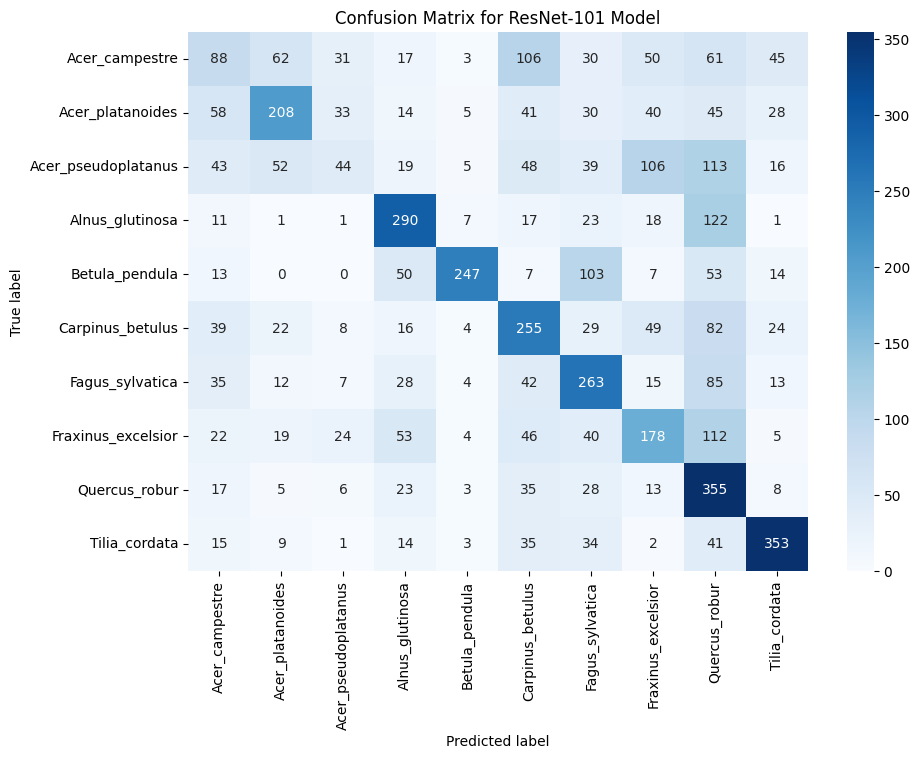

In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Concatenate, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.image import resize
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Define paths
base_path = "/content/drive/MyDrive/MainDataFolder/CombinedDataset"
species = ['Quercus_robur', 'Carpinus_betulus', 'Acer_campestre', 'Tilia_cordata',
           'Betula_pendula', 'Alnus_glutinosa', 'Acer_pseudoplatanus',
           'Fagus_sylvatica', 'Fraxinus_excelsior', 'Acer_platanoides']

# Load data from .npy files and downsample to 64x64
def load_data(target_size=(64, 64)):
    images = []
    kds = []
    bhs = []
    labels = []
    for specie in species:
        print(f"Loading data for {specie}...")
        specie_images = np.load(Path(base_path) / f"{specie}_RGBI_combined.npy")
        specie_kds = np.load(Path(base_path) / f"{specie}_KD_combined.npy")
        specie_bhs = np.load(Path(base_path) / f"{specie}_BH_combined.npy")
        specie_labels = np.load(Path(base_path) / f"{specie}_label_combined.npy")

        # Use only the first 3 channels (RGB)
        specie_images = specie_images[..., :3]

        # Sample 2500 instances from each species
        indices = np.random.choice(len(specie_images), 2500, replace=False)
        specie_images_sampled = specie_images[indices]

        # Downsample images to target size
        specie_images_resized = np.array([resize(img, target_size).numpy() / 255.0 for img in specie_images_sampled])

        images.append(specie_images_resized)
        kds.append(specie_kds[indices])
        bhs.append(specie_bhs[indices])
        labels.append(specie_labels[indices])

    images = np.concatenate(images)
    kds = np.concatenate(kds)
    bhs = np.concatenate(bhs)
    labels = np.concatenate(labels)
    return images, kds, bhs, labels

# Load and preprocess data
print("Loading and preprocessing data...")
rgb_images, kd_values, bh_values, labels = load_data()

# Encode labels
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

print(f"Loaded {len(rgb_images)} images with shape {rgb_images.shape}.")

# Split data into training and testing sets
print("Splitting data into training and testing sets...")
X_train_img, X_test_img, y_train, y_test = train_test_split(rgb_images, labels_encoded, test_size=0.2, random_state=42)
X_train_kd, X_test_kd = train_test_split(kd_values, test_size=0.2, random_state=42)
X_train_bh, X_test_bh = train_test_split(bh_values, test_size=0.2, random_state=42)

print(f"Data splitting completed. Training set size: {len(X_train_img)}, Testing set size: {len(X_test_img)}")

# Define the ResNet-101 based model
def create_resnet101_model(input_image_size=(64, 64, 3), input_kd_size=(1,), input_bh_size=(1,), num_classes=10):
    base_model = ResNet101(include_top=False, weights='imagenet', input_shape=input_image_size)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)

    # KD and BH input branches
    kd_input = Input(shape=input_kd_size, name='kd_input')
    bh_input = Input(shape=input_bh_size, name='bh_input')

    # Combine branches
    combined = Concatenate()([x, kd_input, bh_input])
    combined = Dense(128, activation='relu')(combined)
    combined = Dropout(0.5)(combined)
    output = Dense(num_classes, activation='softmax')(combined)

    model = Model(inputs=[base_model.input, kd_input, bh_input], outputs=output)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Create and train the ResNet-101 model
input_image_size = (64, 64, 3)
input_kd_size = (1,)
input_bh_size = (1,)
num_classes = len(np.unique(y_train))

print(f"Creating ResNet-101 model with input sizes {input_image_size}, {input_kd_size}, {input_bh_size}, and {num_classes} classes...")
model = create_resnet101_model(input_image_size=input_image_size, input_kd_size=input_kd_size, input_bh_size=input_bh_size, num_classes=num_classes)
model.summary()

checkpoint_filepath = '/content/drive/MyDrive/MainDataFolder/checkpoints/resnet101_2500_RGB/combined_model_checkpoint.h5'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True
)

early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

print("Training ResNet-101 model...")
history = model.fit(
    [X_train_img, X_train_kd, X_train_bh], y_train,
    validation_data=([X_test_img, X_test_kd, X_test_bh], y_test),
    epochs=50, batch_size=32,
    callbacks=[model_checkpoint_callback, early_stopping_callback]
)
print("Model training completed.")

# Save the model
model_save_path = "/content/drive/MyDrive/MainDataFolder/AIModels/resnet101_2500_RGB_combined_model.h5"
model.save(model_save_path)
print(f"Model saved as {model_save_path}")

# Evaluate the model
def evaluate_model(model, images, kds, bhs, labels, batch_size=128):
    preds = model.predict([images, kds, bhs], batch_size=batch_size)
    preds_labels = np.argmax(preds, axis=1)

    accuracy = accuracy_score(labels, preds_labels)
    cm = confusion_matrix(labels, preds_labels)
    report = classification_report(labels, preds_labels, output_dict=True)
    return accuracy, cm, report

print("Evaluating ResNet-101 model...")
accuracy, cm, report = evaluate_model(model, X_test_img, X_test_kd, X_test_bh, y_test)

print(f"ResNet-101 Model - Accuracy: {accuracy}")
print("ResNet-101 Model - Classification Report:")
print(classification_report(y_test, np.argmax(model.predict([X_test_img, X_test_kd, X_test_bh]), axis=1)))

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix for ResNet-101 Model')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()


###ResNet 101 with 2500 sample from each species for RGB bands with Data Augmentation,Learning Rate Adjustment and Early Stopping

Loading and preprocessing data...
Loading data for Quercus_robur...
Loading data for Carpinus_betulus...
Loading data for Acer_campestre...
Loading data for Tilia_cordata...
Loading data for Betula_pendula...
Loading data for Alnus_glutinosa...
Loading data for Acer_pseudoplatanus...
Loading data for Fagus_sylvatica...
Loading data for Fraxinus_excelsior...
Loading data for Acer_platanoides...
Loaded 25000 images with shape (25000, 64, 64, 3).
Splitting data into training and testing sets...
Data splitting completed. Training set size: 20000, Testing set size: 5000
Creating ResNet-101 model with input sizes (64, 64, 3), (1,), (1,), and 10 classes...
Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_8 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                            

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved as /content/drive/MyDrive/MainDataFolder/AIModels/resnet101_2500_combined_model.h5
Evaluating ResNet-101 model...
40/40 [==============================] - 3s 26ms/step
ResNet-101 Model - Accuracy: 0.4738
ResNet-101 Model - Classification Report:
157/157 [==============================] - 2s 11ms/step
              precision    recall  f1-score   support

           0       0.24      0.33      0.28       493
           1       0.38      0.56      0.45       502
           2       0.32      0.16      0.21       485
           3       0.55      0.63      0.59       491
           4       0.73      0.69      0.71       494
           5       0.71      0.23      0.34       528
           6       0.46      0.51      0.49       504
           7       0.36      0.46      0.41       503
           8       0.52      0.45      0.48       493
           9       0.69      0.72      0.71       507

    accuracy                           0.47      5000
   macro avg       0.50      0.47   

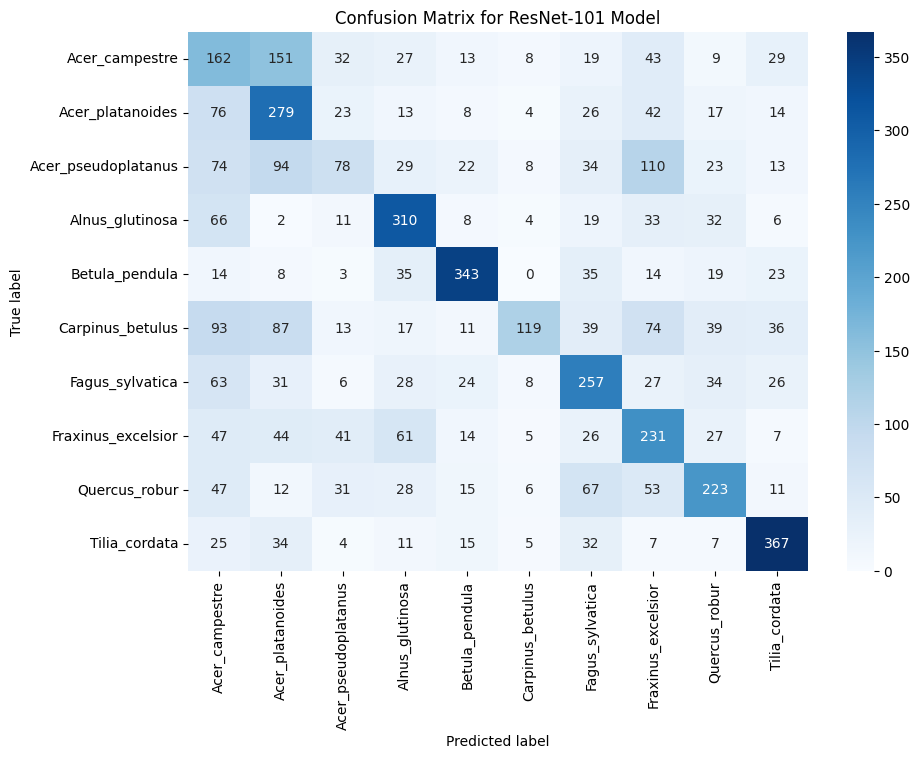

In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Concatenate, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.image import resize
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

# Define paths
base_path = "/content/drive/MyDrive/MainDataFolder/CombinedDataset"
species = ['Quercus_robur', 'Carpinus_betulus', 'Acer_campestre', 'Tilia_cordata',
           'Betula_pendula', 'Alnus_glutinosa', 'Acer_pseudoplatanus',
           'Fagus_sylvatica', 'Fraxinus_excelsior', 'Acer_platanoides']

# Load data from .npy files and downsample to 64x64
def load_data(target_size=(64, 64)):
    images = []
    kds = []
    bhs = []
    labels = []
    for specie in species:
        print(f"Loading data for {specie}...")
        specie_images = np.load(Path(base_path) / f"{specie}_RGBI_combined.npy")
        specie_kds = np.load(Path(base_path) / f"{specie}_KD_combined.npy")
        specie_bhs = np.load(Path(base_path) / f"{specie}_BH_combined.npy")
        specie_labels = np.load(Path(base_path) / f"{specie}_label_combined.npy")

        # Sample 2500 instances from each species
        indices = np.random.choice(len(specie_images), 2500, replace=False)
        specie_images_sampled = specie_images[indices]

        # Downsample images to target size
        specie_images_resized = np.array([resize(img[:, :, :3], target_size).numpy() / 255.0 for img in specie_images_sampled])

        images.append(specie_images_resized)
        kds.append(specie_kds[indices])
        bhs.append(specie_bhs[indices])
        labels.append(specie_labels[indices])

    images = np.concatenate(images)
    kds = np.concatenate(kds)
    bhs = np.concatenate(bhs)
    labels = np.concatenate(labels)
    return images, kds, bhs, labels

# Load and preprocess data
print("Loading and preprocessing data...")
rgb_images, kd_values, bh_values, labels = load_data()

# Encode labels
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

print(f"Loaded {len(rgb_images)} images with shape {rgb_images.shape}.")

# Split data into training and testing sets
print("Splitting data into training and testing sets...")
X_train_img, X_test_img, y_train, y_test = train_test_split(rgb_images, labels_encoded, test_size=0.2, random_state=42)
X_train_kd, X_test_kd = train_test_split(kd_values, test_size=0.2, random_state=42)
X_train_bh, X_test_bh = train_test_split(bh_values, test_size=0.2, random_state=42)

print(f"Data splitting completed. Training set size: {len(X_train_img)}, Testing set size: {len(X_test_img)}")

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Custom data generator for multiple inputs
def custom_data_generator(datagen, X_img, X_kd, X_bh, y, batch_size):
    genX1 = datagen.flow(X_img, y, batch_size=batch_size, seed=7)
    genX2 = datagen.flow(X_img, X_kd, batch_size=batch_size, seed=7)
    genX3 = datagen.flow(X_img, X_bh, batch_size=batch_size, seed=7)
    while True:
        X1i = genX1.next()
        X2i = genX2.next()
        X3i = genX3.next()
        yield [X1i[0], X2i[1], X3i[1]], X1i[1]

# Define the ResNet-101 based model
def create_resnet_model(input_image_size=(64, 64, 3), input_kd_size=(1,), input_bh_size=(1,), num_classes=10):
    base_model = ResNet101(include_top=False, weights='imagenet', input_shape=input_image_size)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)

    # KD and BH input branches
    kd_input = Input(shape=input_kd_size, name='kd_input')
    bh_input = Input(shape=input_bh_size, name='bh_input')

    # Combine branches
    combined = Concatenate()([x, kd_input, bh_input])
    combined = Dense(128, activation='relu')(combined)
    combined = Dropout(0.5)(combined)
    output = Dense(num_classes, activation='softmax')(combined)

    model = Model(inputs=[base_model.input, kd_input, bh_input], outputs=output)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Create and train the ResNet-101 model
input_image_size = X_train_img.shape[1:]
input_kd_size = (1,)
input_bh_size = (1,)
num_classes = len(np.unique(y_train))

print(f"Creating ResNet-101 model with input sizes {input_image_size}, {input_kd_size}, {input_bh_size}, and {num_classes} classes...")
model = create_resnet_model(input_image_size=input_image_size, input_kd_size=input_kd_size, input_bh_size=input_bh_size, num_classes=num_classes)
model.summary()

checkpoint_filepath = '/content/drive/MyDrive/MainDataFolder/checkpoints/resnet101_2500/combined_model_checkpoint.h5'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True
)

early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

reduce_lr_callback = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

batch_size = 32
train_generator = custom_data_generator(datagen, X_train_img, X_train_kd, X_train_bh, y_train, batch_size)

print("Training ResNet-101 model...")
history = model.fit(
    train_generator,
    validation_data=([X_test_img, X_test_kd, X_test_bh], y_test),
    epochs=50,
    steps_per_epoch=len(X_train_img) // batch_size,
    callbacks=[model_checkpoint_callback, early_stopping_callback, reduce_lr_callback]
)
print("Model training completed.")

# Save the model
model_save_path = "/content/drive/MyDrive/MainDataFolder/AIModels/resnet101_2500_combined_model.h5"
model.save(model_save_path)
print(f"Model saved as {model_save_path}")

# Evaluate the model
def evaluate_model(model, images, kds, bhs, labels, batch_size=128):
    preds = model.predict([images, kds, bhs], batch_size=batch_size)
    preds_labels = np.argmax(preds, axis=1)

    accuracy = accuracy_score(labels, preds_labels)
    cm = confusion_matrix(labels, preds_labels)
    report = classification_report(labels, preds_labels, output_dict=True)
    return accuracy, cm, report

print("Evaluating ResNet-101 model...")
accuracy, cm, report = evaluate_model(model, X_test_img, X_test_kd, X_test_bh, y_test)

print(f"ResNet-101 Model - Accuracy: {accuracy}")
print("ResNet-101 Model - Classification Report:")
print(classification_report(y_test, np.argmax(model.predict([X_test_img, X_test_kd, X_test_bh]), axis=1)))

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix for ResNet-101 Model')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()


##ResNet 101 with 2500 sample from each species for RGB bands with Data Augmentation,Learning Rate Adjustment and Early Stopping and no KD and BH values

In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.image import resize
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

# Define paths
base_path = "/content/drive/MyDrive/MainDataFolder/CombinedDataset"
species = ['Quercus_robur', 'Carpinus_betulus', 'Acer_campestre', 'Tilia_cordata',
           'Betula_pendula', 'Alnus_glutinosa', 'Acer_pseudoplatanus',
           'Fagus_sylvatica', 'Fraxinus_excelsior', 'Acer_platanoides']

# Load data from .npy files and downsample to 64x64
def load_data(target_size=(64, 64)):
    images = []
    labels = []
    for specie in species:
        print(f"Loading data for {specie}...")
        specie_images = np.load(Path(base_path) / f"{specie}_RGBI_combined.npy")
        specie_labels = np.load(Path(base_path) / f"{specie}_label_combined.npy")

        # Sample 2500 instances from each species
        indices = np.random.choice(len(specie_images), 2500, replace=False)
        specie_images_sampled = specie_images[indices]

        # Downsample images to target size
        specie_images_resized = np.array([resize(img[:, :, :3], target_size).numpy() / 255.0 for img in specie_images_sampled])

        images.append(specie_images_resized)
        labels.append(specie_labels[indices])

    images = np.concatenate(images)
    labels = np.concatenate(labels)
    return images, labels

# Load and preprocess data
print("Loading and preprocessing data...")
rgb_images, labels = load_data()

# Encode labels
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

print(f"Loaded {len(rgb_images)} images with shape {rgb_images.shape}.")

# Split data into training and testing sets
print("Splitting data into training and testing sets...")
X_train_img, X_test_img, y_train, y_test = train_test_split(rgb_images, labels_encoded, test_size=0.2, random_state=42)

print(f"Data splitting completed. Training set size: {len(X_train_img)}, Testing set size: {len(X_test_img)}")

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Define the ResNet-101 based model
def create_resnet_model(input_image_size=(64, 64, 3), num_classes=10):
    base_model = ResNet101(include_top=False, weights='imagenet', input_shape=input_image_size)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=output)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Create and train the ResNet-101 model
input_image_size = X_train_img.shape[1:]
num_classes = len(np.unique(y_train))

print(f"Creating ResNet-101 model with input size {input_image_size} and {num_classes} classes...")
model = create_resnet_model(input_image_size=input_image_size, num_classes=num_classes)
model.summary()

checkpoint_filepath = '/content/drive/MyDrive/MainDataFolder/checkpoints/resnet101_RGB_2500/combined_model_checkpoint.h5'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True
)

early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

reduce_lr_callback = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

batch_size = 32

print("Training ResNet-101 model...")
history = model.fit(
    datagen.flow(X_train_img, y_train, batch_size=batch_size),
    validation_data=(X_test_img, y_test),
    epochs=50,
    steps_per_epoch=len(X_train_img) // batch_size,
    callbacks=[model_checkpoint_callback, early_stopping_callback, reduce_lr_callback]
)
print("Model training completed.")

# Save the model
model_save_path = "/content/drive/MyDrive/MainDataFolder/AIModels/resnet101_RGB_2500_combined_model.h5"
model.save(model_save_path)
print(f"Model saved as {model_save_path}")

# Evaluate the model
def evaluate_model(model, images, labels, batch_size=128):
    preds = model.predict(images, batch_size=batch_size)
    preds_labels = np.argmax(preds, axis=1)

    accuracy = accuracy_score(labels, preds_labels)
    cm = confusion_matrix(labels, preds_labels)
    report = classification_report(labels, preds_labels, output_dict=True)
    return accuracy, cm, report

print("Evaluating ResNet-101 model...")
accuracy, cm, report = evaluate_model(model, X_test_img, y_test)

print(f"ResNet-101 Model - Accuracy: {accuracy}")
print("ResNet-101 Model - Classification Report:")
print(classification_report(y_test, np.argmax(model.predict(X_test_img), axis=1)))

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix for ResNet-101 Model')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()


##EfficientNet Models

###EfficientNet-B3

In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Concatenate, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.image import resize
from sklearn.model_selection import train_test_split

# Define paths
base_path = "/content/drive/MyDrive/MainDataFolder/CombinedDataset"
species = ['Quercus_robur', 'Carpinus_betulus', 'Acer_campestre', 'Tilia_cordata',
           'Betula_pendula', 'Alnus_glutinosa', 'Acer_pseudoplatanus',
           'Fagus_sylvatica', 'Fraxinus_excelsior', 'Acer_platanoides']

# Load data from .npy files and downsample to 64x64
def load_data(target_size=(64, 64)):
    images = []
    kds = []
    bhs = []
    labels = []
    for specie in species:
        print(f"Loading data for {specie}...")
        specie_images = np.load(Path(base_path) / f"{specie}_RGBI_combined.npy")
        specie_kds = np.load(Path(base_path) / f"{specie}_KD_combined.npy")
        specie_bhs = np.load(Path(base_path) / f"{specie}_BH_combined.npy")
        specie_labels = np.load(Path(base_path) / f"{specie}_label_combined.npy")

        # Sample 2500 instances from each species
        indices = np.random.choice(len(specie_images), 2500, replace=False)
        specie_images_sampled = specie_images[indices]

        # Downsample images to target size
        specie_images_resized = np.array([resize(img[:, :, :3], target_size).numpy() / 255.0 for img in specie_images_sampled])

        images.append(specie_images_resized)
        kds.append(specie_kds[indices])
        bhs.append(specie_bhs[indices])
        labels.append(specie_labels[indices])

    images = np.concatenate(images)
    kds = np.concatenate(kds)
    bhs = np.concatenate(bhs)
    labels = np.concatenate(labels)
    return images, kds, bhs, labels

# Load and preprocess data
print("Loading and preprocessing data...")
rgb_images, kd_values, bh_values, labels = load_data()

# Encode labels
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

print(f"Loaded {len(rgb_images)} images with shape {rgb_images.shape}.")

# Split data into training and testing sets
print("Splitting data into training and testing sets...")
X_train_img, X_test_img, y_train, y_test = train_test_split(rgb_images, labels_encoded, test_size=0.2, random_state=42)
X_train_kd, X_test_kd = train_test_split(kd_values, test_size=0.2, random_state=42)
X_train_bh, X_test_bh = train_test_split(bh_values, test_size=0.2, random_state=42)

print(f"Data splitting completed. Training set size: {len(X_train_img)}, Testing set size: {len(X_test_img)}")

# Define the EfficientNet-B3 based model
def create_efficientnet_model(input_image_size=(64, 64, 3), input_kd_size=(1,), input_bh_size=(1,), num_classes=10):
    base_model = EfficientNetB3(include_top=False, weights='imagenet', input_shape=input_image_size)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)

    # KD and BH input branches
    kd_input = Input(shape=input_kd_size, name='kd_input')
    bh_input = Input(shape=input_bh_size, name='bh_input')

    # Combine branches
    combined = Concatenate()([x, kd_input, bh_input])
    combined = Dense(128, activation='relu')(combined)
    combined = Dropout(0.5)(combined)
    output = Dense(num_classes, activation='softmax')(combined)

    model = Model(inputs=[base_model.input, kd_input, bh_input], outputs=output)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Create and train the EfficientNet-B3 model
input_image_size = X_train_img.shape[1:]
input_kd_size = (1,)
input_bh_size = (1,)
num_classes = len(np.unique(y_train))

print(f"Creating EfficientNet-B3 model with input sizes {input_image_size}, {input_kd_size}, {input_bh_size}, and {num_classes} classes...")
model = create_efficientnet_model(input_image_size=input_image_size, input_kd_size=input_kd_size, input_bh_size=input_bh_size, num_classes=num_classes)
model.summary()

print("Training EfficientNet-B3 model...")
history = model.fit(
    [X_train_img, X_train_kd, X_train_bh], y_train,
    validation_data=([X_test_img, X_test_kd, X_test_bh], y_test),
    epochs=50, batch_size=32
)
print("Model training completed.")

# Save the model
model_save_path = "/content/drive/MyDrive/MainDataFolder/AIModels/efficientnetb3_2500_combined_model.h5"
model.save(model_save_path)
print(f"Model saved as {model_save_path}")

# Evaluate the model
def evaluate_model(model, images, kds, bhs, labels, batch_size=128):
    preds = model.predict([images, kds, bhs], batch_size=batch_size)
    preds_labels = np.argmax(preds, axis=1)

    accuracy = accuracy_score(labels, preds_labels)
    cm = confusion_matrix(labels, preds_labels)
    report = classification_report(labels, preds_labels, output_dict=True)
    return accuracy, cm, report

print("Evaluating EfficientNet-B3 model...")
accuracy, cm, report = evaluate_model(model, X_test_img, X_test_kd, X_test_bh, y_test)

print(f"EfficientNet-B3 Model - Accuracy: {accuracy}")
print("EfficientNet-B3 Model - Classification Report:")
print(classification_report(y_test, np.argmax(model.predict([X_test_img, X_test_kd, X_test_bh]), axis=1)))

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix for EfficientNet-B3 Model')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()


Loading and preprocessing data...
Loading data for Quercus_robur...
Loading data for Carpinus_betulus...
Loading data for Acer_campestre...
Loading data for Tilia_cordata...
Loading data for Betula_pendula...
Loading data for Alnus_glutinosa...
Loading data for Acer_pseudoplatanus...
Loading data for Fagus_sylvatica...
Loading data for Fraxinus_excelsior...
Loading data for Acer_platanoides...
Loaded 25000 images with shape (25000, 64, 64, 3).
Splitting data into training and testing sets...
Data splitting completed. Training set size: 20000, Testing set size: 5000
Creating EfficientNet-B3 model with input sizes (64, 64, 3), (1,), (1,), and 10 classes...
43941136/43941136 [==============================] - 3s 0us/step
Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_9 (InputLayer)        [(None, 64, 64, 3)]        

KeyboardInterrupt: 

###EfficientNet-B3 Data Augmentation,Learning Rate Adjustment and Early Stopping

Loading and preprocessing data...
Loading data for Quercus_robur...
Loading data for Carpinus_betulus...
Loading data for Acer_campestre...
Loading data for Tilia_cordata...
Loading data for Betula_pendula...
Loading data for Alnus_glutinosa...
Loading data for Acer_pseudoplatanus...
Loading data for Fagus_sylvatica...
Loading data for Fraxinus_excelsior...
Loading data for Acer_platanoides...
Loaded 25000 images with shape (25000, 64, 64, 3).
Splitting data into training and testing sets...
Data splitting completed. Training set size: 20000, Testing set size: 5000
Creating EfficientNet-B3 model with input sizes (64, 64, 3), (1,), (1,), and 10 classes...
Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_11 (InputLayer)       [(None, 64, 64, 3)]          0         []                            
                      

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved as /content/drive/MyDrive/MainDataFolder/AIModels/efficientnetb3_Aug_2500_combined_model.h5
Evaluating EfficientNet-B3 model...
40/40 [==============================] - 4s 22ms/step
EfficientNet-B3 Model - Accuracy: 0.1696
EfficientNet-B3 Model - Classification Report:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


157/157 [==============================] - 2s 13ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       493
           1       0.34      0.02      0.04       502
           2       0.15      0.23      0.18       485
           3       0.17      0.82      0.28       491
           4       0.00      0.00      0.00       494
           5       0.15      0.07      0.10       528
           6       0.00      0.00      0.00       504
           7       0.13      0.28      0.18       503
           8       0.27      0.29      0.28       493
           9       0.00      0.00      0.00       507

    accuracy                           0.17      5000
   macro avg       0.12      0.17      0.11      5000
weighted avg       0.12      0.17      0.11      5000



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


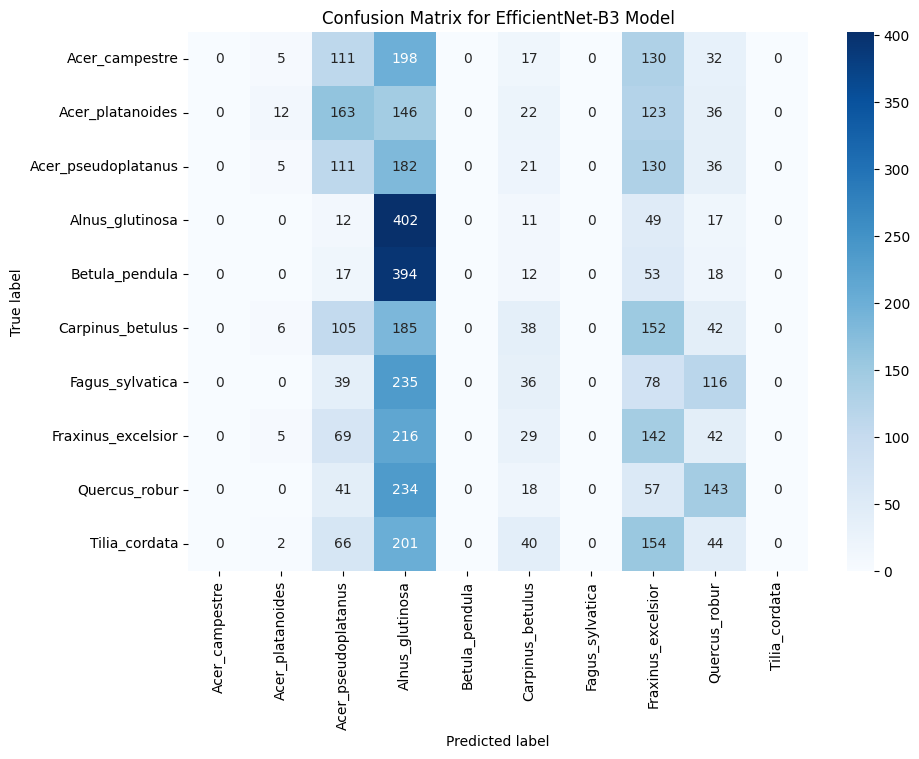

In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Concatenate, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.image import resize
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define paths
base_path = "/content/drive/MyDrive/MainDataFolder/CombinedDataset"
species = ['Quercus_robur', 'Carpinus_betulus', 'Acer_campestre', 'Tilia_cordata',
           'Betula_pendula', 'Alnus_glutinosa', 'Acer_pseudoplatanus',
           'Fagus_sylvatica', 'Fraxinus_excelsior', 'Acer_platanoides']

# Load data from .npy files and downsample to 64x64
def load_data(target_size=(64, 64)):
    images = []
    kds = []
    bhs = []
    labels = []
    for specie in species:
        print(f"Loading data for {specie}...")
        specie_images = np.load(Path(base_path) / f"{specie}_RGBI_combined.npy")
        specie_kds = np.load(Path(base_path) / f"{specie}_KD_combined.npy")
        specie_bhs = np.load(Path(base_path) / f"{specie}_BH_combined.npy")
        specie_labels = np.load(Path(base_path) / f"{specie}_label_combined.npy")

        # Sample 2500 instances from each species
        indices = np.random.choice(len(specie_images), 2500, replace=False)
        specie_images_sampled = specie_images[indices]

        # Downsample images to target size
        specie_images_resized = np.array([resize(img[:, :, :3], target_size).numpy() / 255.0 for img in specie_images_sampled])

        images.append(specie_images_resized)
        kds.append(specie_kds[indices])
        bhs.append(specie_bhs[indices])
        labels.append(specie_labels[indices])

    images = np.concatenate(images)
    kds = np.concatenate(kds)
    bhs = np.concatenate(bhs)
    labels = np.concatenate(labels)
    return images, kds, bhs, labels

# Load and preprocess data
print("Loading and preprocessing data...")
rgb_images, kd_values, bh_values, labels = load_data()

# Encode labels
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

print(f"Loaded {len(rgb_images)} images with shape {rgb_images.shape}.")

# Split data into training and testing sets
print("Splitting data into training and testing sets...")
X_train_img, X_test_img, y_train, y_test = train_test_split(rgb_images, labels_encoded, test_size=0.2, random_state=42)
X_train_kd, X_test_kd = train_test_split(kd_values, test_size=0.2, random_state=42)
X_train_bh, X_test_bh = train_test_split(bh_values, test_size=0.2, random_state=42)

print(f"Data splitting completed. Training set size: {len(X_train_img)}, Testing set size: {len(X_test_img)}")

# Define the EfficientNet-B3 based model
def create_efficientnet_model(input_image_size=(64, 64, 3), input_kd_size=(1,), input_bh_size=(1,), num_classes=10):
    base_model = EfficientNetB3(include_top=False, weights='imagenet', input_shape=input_image_size)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)

    # KD and BH input branches
    kd_input = Input(shape=input_kd_size, name='kd_input')
    bh_input = Input(shape=input_bh_size, name='bh_input')

    # Combine branches
    combined = Concatenate()([x, kd_input, bh_input])
    combined = Dense(128, activation='relu')(combined)
    combined = Dropout(0.5)(combined)
    output = Dense(num_classes, activation='softmax')(combined)

    model = Model(inputs=[base_model.input, kd_input, bh_input], outputs=output)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Custom data generator
class CustomDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, images, kds, bhs, labels, batch_size, datagen):
        self.images = images
        self.kds = kds
        self.bhs = bhs
        self.labels = labels
        self.batch_size = batch_size
        self.datagen = datagen
        self.indexes = np.arange(len(images))

    def __len__(self):
        return len(self.images) // self.batch_size

    def __getitem__(self, index):
        batch_indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        batch_images = self.images[batch_indexes]
        batch_kds = self.kds[batch_indexes]
        batch_bhs = self.bhs[batch_indexes]
        batch_labels = self.labels[batch_indexes]

        # Apply data augmentation to images only
        augmented_images = next(self.datagen.flow(batch_images, batch_size=self.batch_size, shuffle=False))

        return [augmented_images, batch_kds, batch_bhs], batch_labels

# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

# Create and train the EfficientNet-B3 model
input_image_size = X_train_img.shape[1:]
input_kd_size = (1,)
input_bh_size = (1,)
num_classes = len(np.unique(y_train))

print(f"Creating EfficientNet-B3 model with input sizes {input_image_size}, {input_kd_size}, {input_bh_size}, and {num_classes} classes...")
model = create_efficientnet_model(input_image_size=input_image_size, input_kd_size=input_kd_size, input_bh_size=input_bh_size, num_classes=num_classes)
model.summary()

checkpoint_filepath = '/content/drive/MyDrive/MainDataFolder/checkpoints/efficientnetb3_2500_Aug/combined_model_checkpoint.h5'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True
)

early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

reduce_lr_callback = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=0.0001
)

print("Training EfficientNet-B3 model...")
train_generator = CustomDataGenerator(X_train_img, X_train_kd, X_train_bh, y_train, batch_size=32, datagen=datagen)
history = model.fit(
    train_generator,
    validation_data=([X_test_img, X_test_kd, X_test_bh], y_test),
    epochs=50,
    callbacks=[model_checkpoint_callback, early_stopping_callback, reduce_lr_callback]
)
print("Model training completed.")

# Save the model
model_save_path = "/content/drive/MyDrive/MainDataFolder/AIModels/efficientnetb3_Aug_2500_combined_model.h5"
model.save(model_save_path)
print(f"Model saved as {model_save_path}")

# Evaluate the model
def evaluate_model(model, images, kds, bhs, labels, batch_size=128):
    preds = model.predict([images, kds, bhs], batch_size=batch_size)
    preds_labels = np.argmax(preds, axis=1)

    accuracy = accuracy_score(labels, preds_labels)
    cm = confusion_matrix(labels, preds_labels)
    report = classification_report(labels, preds_labels, output_dict=True)
    return accuracy, cm, report

print("Evaluating EfficientNet-B3 model...")
accuracy, cm, report = evaluate_model(model, X_test_img, X_test_kd, X_test_bh, y_test)

print(f"EfficientNet-B3 Model - Accuracy: {accuracy}")
print("EfficientNet-B3 Model - Classification Report:")
print(classification_report(y_test, np.argmax(model.predict([X_test_img, X_test_kd, X_test_bh]), axis=1)))

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix for EfficientNet-B3 Model')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()


##DenseNet-121 (Densely Connected Convolutional Networks)

DenseNet-121 might be too complex for the given dataset size. Consider using a less complex model like EfficientNet-B0 or ResNet-50, or apply regularization techniques to the existing model.

Loading and preprocessing data...
Loading data for Quercus_robur...
Loading data for Carpinus_betulus...
Loading data for Acer_campestre...
Loading data for Tilia_cordata...
Loading data for Betula_pendula...
Loading data for Alnus_glutinosa...
Loading data for Acer_pseudoplatanus...
Loading data for Fagus_sylvatica...
Loading data for Fraxinus_excelsior...
Loading data for Acer_platanoides...
Loaded 25000 images with shape (25000, 64, 64, 3).
Splitting data into training and testing sets...
Data splitting completed. Training set size: 20000, Testing set size: 5000
Creating DenseNet-121 model with input sizes (64, 64, 3), (1,), (1,), and 10 classes...
29084464/29084464 [==============================] - 2s 0us/step
Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_12 (InputLayer)       [(None, 64, 64, 3)]          0

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved as /content/drive/MyDrive/MainDataFolder/AIModels/densenet121_2500_combined_model.h5
Evaluating DenseNet-121 model...
40/40 [==============================] - 3s 17ms/step
DenseNet-121 Model - Accuracy: 0.3894
DenseNet-121 Model - Classification Report:
157/157 [==============================] - 2s 10ms/step
              precision    recall  f1-score   support

           0       0.18      0.10      0.13       493
           1       0.22      0.78      0.35       502
           2       0.18      0.16      0.17       485
           3       0.75      0.43      0.55       491
           4       0.89      0.34      0.49       494
           5       0.64      0.27      0.38       528
           6       0.38      0.42      0.40       504
           7       0.42      0.45      0.43       503
           8       0.65      0.27      0.38       493
           9       0.64      0.64      0.64       507

    accuracy                           0.39      5000
   macro avg       0.49     

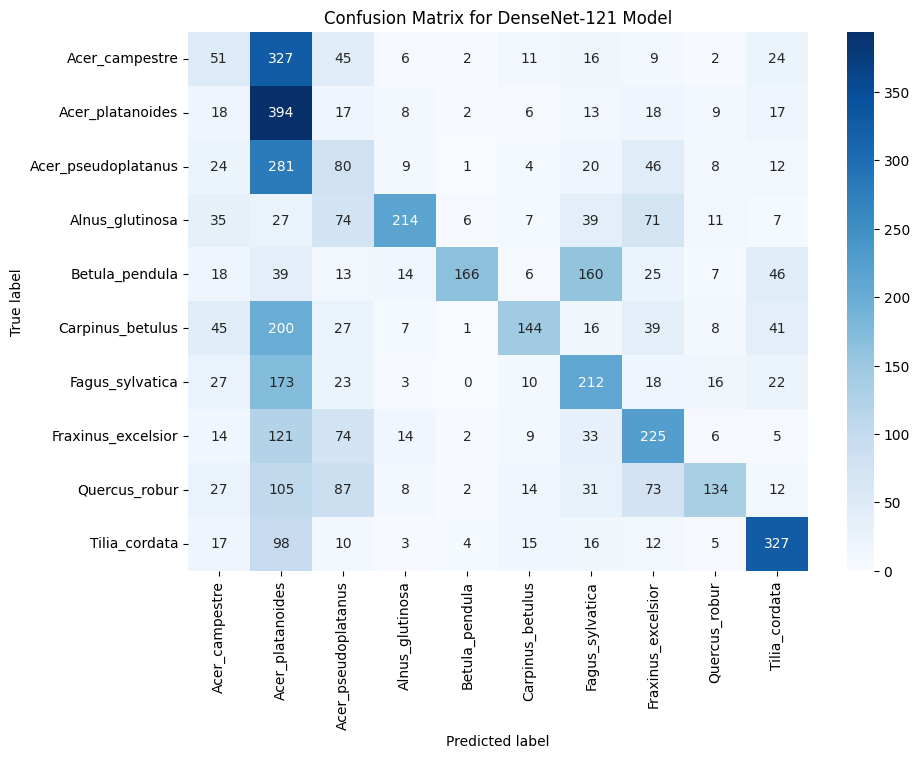

In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Concatenate, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.image import resize
from sklearn.model_selection import train_test_split

# Define paths
base_path = "/content/drive/MyDrive/MainDataFolder/CombinedDataset"
species = ['Quercus_robur', 'Carpinus_betulus', 'Acer_campestre', 'Tilia_cordata',
           'Betula_pendula', 'Alnus_glutinosa', 'Acer_pseudoplatanus',
           'Fagus_sylvatica', 'Fraxinus_excelsior', 'Acer_platanoides']

# Load data from .npy files and downsample to 64x64
def load_data(target_size=(64, 64)):
    images = []
    kds = []
    bhs = []
    labels = []
    for specie in species:
        print(f"Loading data for {specie}...")
        specie_images = np.load(Path(base_path) / f"{specie}_RGBI_combined.npy")
        specie_kds = np.load(Path(base_path) / f"{specie}_KD_combined.npy")
        specie_bhs = np.load(Path(base_path) / f"{specie}_BH_combined.npy")
        specie_labels = np.load(Path(base_path) / f"{specie}_label_combined.npy")

        # Sample 2500 instances from each species
        indices = np.random.choice(len(specie_images), 2500, replace=False)
        specie_images_sampled = specie_images[indices]

        # Downsample images to target size
        specie_images_resized = np.array([resize(img[:, :, :3], target_size).numpy() / 255.0 for img in specie_images_sampled])

        images.append(specie_images_resized)
        kds.append(specie_kds[indices])
        bhs.append(specie_bhs[indices])
        labels.append(specie_labels[indices])

    images = np.concatenate(images)
    kds = np.concatenate(kds)
    bhs = np.concatenate(bhs)
    labels = np.concatenate(labels)
    return images, kds, bhs, labels

# Load and preprocess data
print("Loading and preprocessing data...")
rgb_images, kd_values, bh_values, labels = load_data()

# Encode labels
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

print(f"Loaded {len(rgb_images)} images with shape {rgb_images.shape}.")

# Split data into training and testing sets
print("Splitting data into training and testing sets...")
X_train_img, X_test_img, y_train, y_test = train_test_split(rgb_images, labels_encoded, test_size=0.2, random_state=42)
X_train_kd, X_test_kd = train_test_split(kd_values, test_size=0.2, random_state=42)
X_train_bh, X_test_bh = train_test_split(bh_values, test_size=0.2, random_state=42)

print(f"Data splitting completed. Training set size: {len(X_train_img)}, Testing set size: {len(X_test_img)}")

# Define the DenseNet-121 based model
def create_densenet_model(input_image_size=(64, 64, 3), input_kd_size=(1,), input_bh_size=(1,), num_classes=10):
    base_model = DenseNet121(include_top=False, weights='imagenet', input_shape=input_image_size)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)

    # KD and BH input branches
    kd_input = Input(shape=input_kd_size, name='kd_input')
    bh_input = Input(shape=input_bh_size, name='bh_input')

    # Combine branches
    combined = Concatenate()([x, kd_input, bh_input])
    combined = Dense(128, activation='relu')(combined)
    combined = Dropout(0.5)(combined)
    output = Dense(num_classes, activation='softmax')(combined)

    model = Model(inputs=[base_model.input, kd_input, bh_input], outputs=output)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Create and train the DenseNet-121 model
input_image_size = X_train_img.shape[1:]
input_kd_size = (1,)
input_bh_size = (1,)
num_classes = len(np.unique(y_train))

print(f"Creating DenseNet-121 model with input sizes {input_image_size}, {input_kd_size}, {input_bh_size}, and {num_classes} classes...")
model = create_densenet_model(input_image_size=input_image_size, input_kd_size=input_kd_size, input_bh_size=input_bh_size, num_classes=num_classes)
model.summary()

checkpoint_filepath = '/content/drive/MyDrive/MainDataFolder/checkpoints/densenet121_2500/combined_model_checkpoint.h5'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True
)

print("Training DenseNet-121 model...")
history = model.fit(
    [X_train_img, X_train_kd, X_train_bh], y_train,
    validation_data=([X_test_img, X_test_kd, X_test_bh], y_test),
    epochs=50,
    batch_size=32,
    callbacks=[model_checkpoint_callback]
)
print("Model training completed.")

# Save the model
model_save_path = "/content/drive/MyDrive/MainDataFolder/AIModels/densenet121_2500_combined_model.h5"
model.save(model_save_path)
print(f"Model saved as {model_save_path}")

# Evaluate the model
def evaluate_model(model, images, kds, bhs, labels, batch_size=128):
    preds = model.predict([images, kds, bhs], batch_size=batch_size)
    preds_labels = np.argmax(preds, axis=1)

    accuracy = accuracy_score(labels, preds_labels)
    cm = confusion_matrix(labels, preds_labels)
    report = classification_report(labels, preds_labels, output_dict=True)
    return accuracy, cm, report

print("Evaluating DenseNet-121 model...")
accuracy, cm, report = evaluate_model(model, X_test_img, X_test_kd, X_test_bh, y_test)

print(f"DenseNet-121 Model - Accuracy: {accuracy}")
print("DenseNet-121 Model - Classification Report:")
print(classification_report(y_test, np.argmax(model.predict([X_test_img, X_test_kd, X_test_bh]), axis=1)))

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix for DenseNet-121 Model')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()


#  *NOT INCLUDED IN THESIS REPORT*

##EValuation

##Evaluation with script for model comparison that includes displaying the confusion matrix as color gradient pixel map

Loading and preprocessing data...
Loading data for Quercus_robur from /content/drive/MyDrive/MainDataFolder/CombinedDataset32...
Loading data for Carpinus_betulus from /content/drive/MyDrive/MainDataFolder/CombinedDataset32...
Loading data for Acer_campestre from /content/drive/MyDrive/MainDataFolder/CombinedDataset32...
Loading data for Tilia_cordata from /content/drive/MyDrive/MainDataFolder/CombinedDataset32...
Loading data for Betula_pendula from /content/drive/MyDrive/MainDataFolder/CombinedDataset32...
Loading data for Alnus_glutinosa from /content/drive/MyDrive/MainDataFolder/CombinedDataset32...
Loading data for Acer_pseudoplatanus from /content/drive/MyDrive/MainDataFolder/CombinedDataset32...
Loading data for Fagus_sylvatica from /content/drive/MyDrive/MainDataFolder/CombinedDataset32...
Loading data for Fraxinus_excelsior from /content/drive/MyDrive/MainDataFolder/CombinedDataset32...
Loading data for Acer_platanoides from /content/drive/MyDrive/MainDataFolder/CombinedDatase

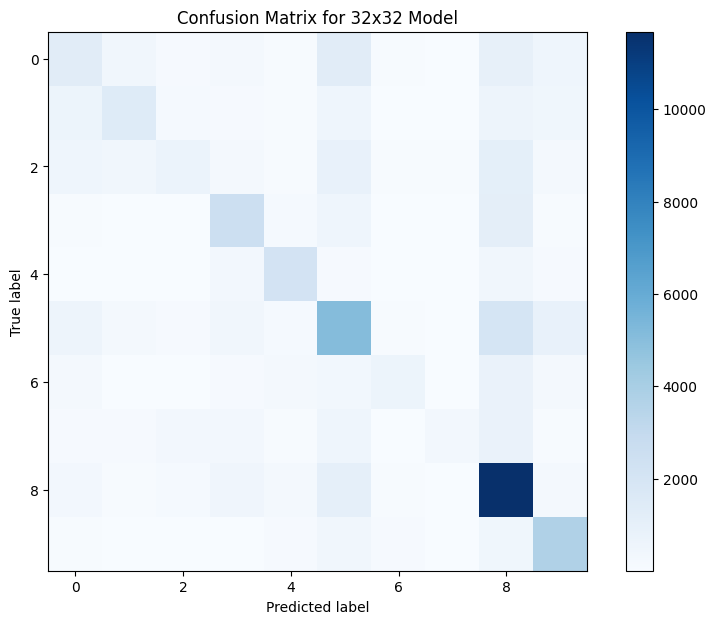

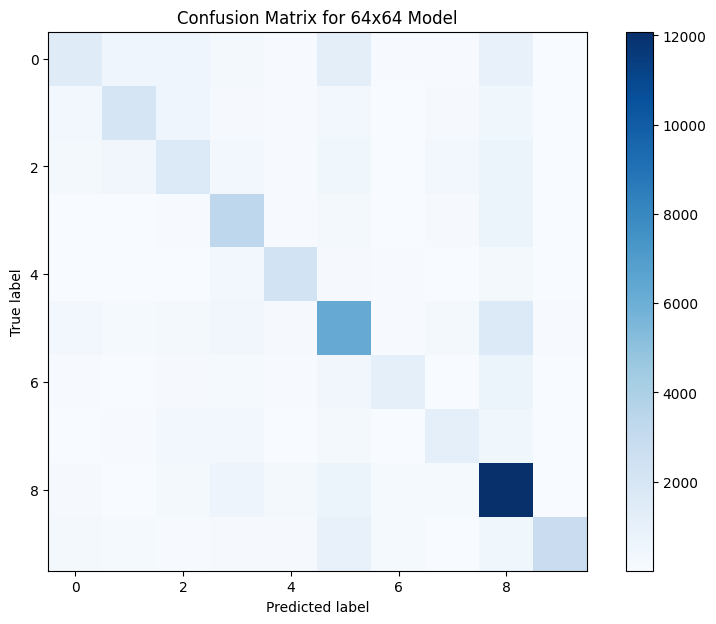

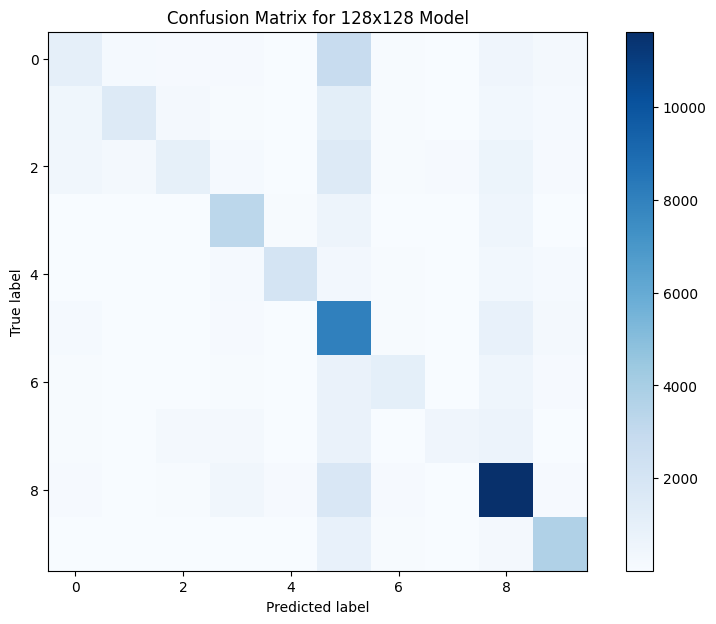

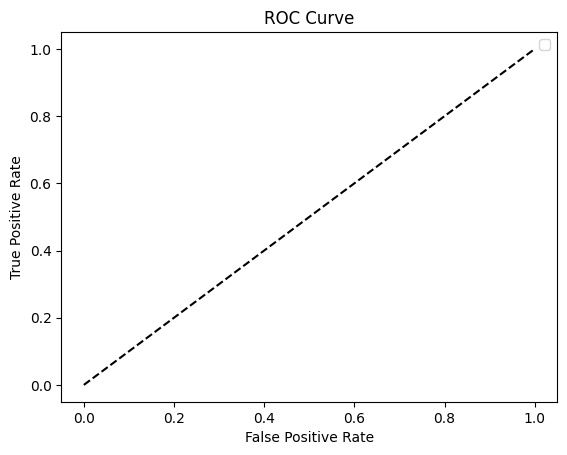

32x32 Model - Accuracy: 0.5329937318231904, Loss: [1.3934218883514404, 0.532993733882904]
64x64 Model - Accuracy: 0.6121497859426651, Loss: [1.1791348457336426, 0.6121497750282288]
128x128 Model - Accuracy: 0.6087176430210083, Loss: [1.1547433137893677, 0.6086995601654053]
32x32 Model - Classification Report:
1730/1730 [==============================] - 4s 2ms/step
              precision    recall  f1-score   support

           0       0.34      0.26      0.30      5006
           1       0.52      0.36      0.42      4034
           2       0.40      0.16      0.23      4262
           3       0.53      0.55      0.54      4609
           4       0.64      0.66      0.65      3171
           5       0.47      0.53      0.50      9613
           6       0.53      0.23      0.32      2690
           7       0.56      0.11      0.18      2647
           8       0.59      0.81      0.68     14356
           9       0.57      0.75      0.64      4971

    accuracy                        

In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, accuracy_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from tensorflow.image import resize
from pathlib import Path

# Load models
model_32 = tf.keras.models.load_model('/content/drive/MyDrive/MainDataFolder/AIModels/32x32combined_model.h5')
model_64 = tf.keras.models.load_model('/content/drive/MyDrive/MainDataFolder/AIModels/64x64combined_model.h5')
model_128 = tf.keras.models.load_model('/content/drive/MyDrive/MainDataFolder/AIModels/128x128combined_model.h5')

# Define paths
base_path_32 = "/content/drive/MyDrive/MainDataFolder/CombinedDataset32"
base_path_64 = "/content/drive/MyDrive/MainDataFolder/CombinedDataset64"
base_path_128 = "/content/drive/MyDrive/MainDataFolder/CombinedDataset"
kd_bh_path = "/content/drive/MyDrive/MainDataFolder/CombinedDataset"

species = ['Quercus_robur', 'Carpinus_betulus', 'Acer_campestre', 'Tilia_cordata',
           'Betula_pendula', 'Alnus_glutinosa', 'Acer_pseudoplatanus',
           'Fagus_sylvatica', 'Fraxinus_excelsior', 'Acer_platanoides']

# Load and preprocess data
def load_and_preprocess_data(base_path, kd_bh_path, species, target_size):
    images = []
    kds = []
    bhs = []
    labels = []
    for specie in species:
        print(f"Loading data for {specie} from {base_path}...")
        images.append(np.load(Path(base_path) / f"{specie}_RGBI_combined.npy"))
        kds.append(np.load(Path(kd_bh_path) / f"{specie}_KD_combined.npy"))
        bhs.append(np.load(Path(kd_bh_path) / f"{specie}_BH_combined.npy"))
        labels.append(np.load(Path(base_path) / f"{specie}_label_combined.npy"))
    images = np.concatenate(images)
    kds = np.concatenate(kds)
    bhs = np.concatenate(bhs)
    labels = np.concatenate(labels)
    images_resized = np.array([resize(img, target_size).numpy() / 255.0 for img in images])
    return images_resized, kds, bhs, labels

# Load and preprocess data for each resolution
print("Loading and preprocessing data...")
images_32, kds_32, bhs_32, labels = load_and_preprocess_data(base_path_32, kd_bh_path, species, (64, 64))  # Upsample 32x32 to 64x64
images_64, kds_64, bhs_64, _ = load_and_preprocess_data(base_path_64, kd_bh_path, species, (64, 64))  # Use 64x64 as they are
images_128, kds_128, bhs_128, _ = load_and_preprocess_data(base_path_128, kd_bh_path, species, (64, 64))  # Downsample 128x128 to 64x64

# Encode labels
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

print(f"Data loaded and preprocessed. Image shapes: 32x32 - {images_32.shape}, 64x64 - {images_64.shape}, 128x128 - {images_128.shape}")

# Evaluate models
def evaluate_model(model, images, kds, bhs, labels, batch_size=128):
    print(f"Evaluating model...")
    preds = []
    for i in range(0, len(images), batch_size):
        batch_preds = model.predict([images[i:i+batch_size], kds[i:i+batch_size], bhs[i:i+batch_size]])
        preds.append(batch_preds)
    preds = np.concatenate(preds)
    preds_labels = np.argmax(preds, axis=1)

    accuracy = accuracy_score(labels, preds_labels)
    loss = model.evaluate([images, kds, bhs], labels, batch_size=batch_size, verbose=0)
    cm = confusion_matrix(labels, preds_labels)
    report = classification_report(labels, preds_labels, output_dict=True)

    try:
        preds_norm = preds / np.sum(preds, axis=1, keepdims=True)
        roc_auc = roc_auc_score(labels, preds_norm, multi_class='ovr')
        fpr, tpr, _ = roc_curve(labels, preds_norm[:, 1], pos_label=1)
    except ValueError as e:
        print(f"ROC AUC calculation error: {e}")
        roc_auc = None
        fpr, tpr = None, None

    return accuracy, loss, cm, report, roc_auc, fpr, tpr

# Evaluate each model
print("Evaluating 32x32 model...")
accuracy_32, loss_32, cm_32, report_32, roc_auc_32, fpr_32, tpr_32 = evaluate_model(model_32, images_32, kds_32, bhs_32, labels_encoded)
print("Evaluating 64x64 model...")
accuracy_64, loss_64, cm_64, report_64, roc_auc_64, fpr_64, tpr_64 = evaluate_model(model_64, images_64, kds_64, bhs_64, labels_encoded)
print("Evaluating 128x128 model...")
accuracy_128, loss_128, cm_128, report_128, roc_auc_128, fpr_128, tpr_128 = evaluate_model(model_128, images_128, kds_128, bhs_128, labels_encoded)

# Visualize results
def plot_confusion_matrix(cm, title='Confusion Matrix'):
    plt.figure(figsize=(10, 7))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.show()

plot_confusion_matrix(cm_32, title='Confusion Matrix for 32x32 Model')
plot_confusion_matrix(cm_64, title='Confusion Matrix for 64x64 Model')
plot_confusion_matrix(cm_128, title='Confusion Matrix for 128x128 Model')

# Plot ROC curve
plt.figure()
if fpr_32 is not None and tpr_32 is not None:
    plt.plot(fpr_32, tpr_32, label=f'32x32 model (area = {roc_auc_32:.2f})')
if fpr_64 is not None and tpr_64 is not None:
    plt.plot(fpr_64, tpr_64, label=f'64x64 model (area = {roc_auc_64:.2f})')
if fpr_128 is not None and tpr_128 is not None:
    plt.plot(fpr_128, tpr_128, label=f'128x128 model (area = {roc_auc_128:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()

# Print evaluation metrics
print(f"32x32 Model - Accuracy: {accuracy_32}, Loss: {loss_32}")
print(f"64x64 Model - Accuracy: {accuracy_64}, Loss: {loss_64}")
print(f"128x128 Model - Accuracy: {accuracy_128}, Loss: {loss_128}")

print("32x32 Model - Classification Report:")
print(classification_report(labels_encoded, np.argmax(model_32.predict([images_32, kds_32, bhs_32]), axis=1)))

print("64x64 Model - Classification Report:")
print(classification_report(labels_encoded, np.argmax(model_64.predict([images_64, kds_64, bhs_64]), axis=1)))

print("128x128 Model - Classification Report:")
print(classification_report(labels_encoded, np.argmax(model_128.predict([images_128, kds_128, bhs_128]), axis=1)))

print("Evaluation complete.")


##Evaluation with updated script for model comparison for models trained with a fixed sample size of **2500** samples that includes displaying the confusion matrix as a table

Loading and preprocessing data...
Loading data for Quercus_robur from /content/drive/MyDrive/MainDataFolder/CombinedDataset32...
Loading data for Carpinus_betulus from /content/drive/MyDrive/MainDataFolder/CombinedDataset32...
Loading data for Acer_campestre from /content/drive/MyDrive/MainDataFolder/CombinedDataset32...
Loading data for Tilia_cordata from /content/drive/MyDrive/MainDataFolder/CombinedDataset32...
Loading data for Betula_pendula from /content/drive/MyDrive/MainDataFolder/CombinedDataset32...
Loading data for Alnus_glutinosa from /content/drive/MyDrive/MainDataFolder/CombinedDataset32...
Loading data for Acer_pseudoplatanus from /content/drive/MyDrive/MainDataFolder/CombinedDataset32...
Loading data for Fagus_sylvatica from /content/drive/MyDrive/MainDataFolder/CombinedDataset32...
Loading data for Fraxinus_excelsior from /content/drive/MyDrive/MainDataFolder/CombinedDataset32...
Loading data for Acer_platanoides from /content/drive/MyDrive/MainDataFolder/CombinedDatase

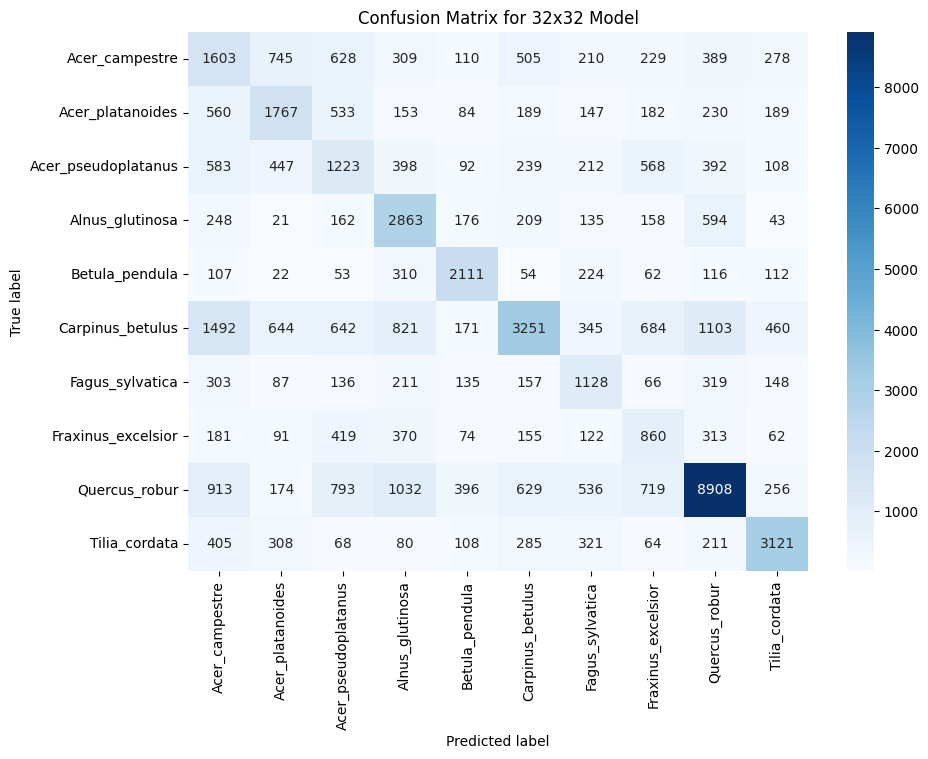

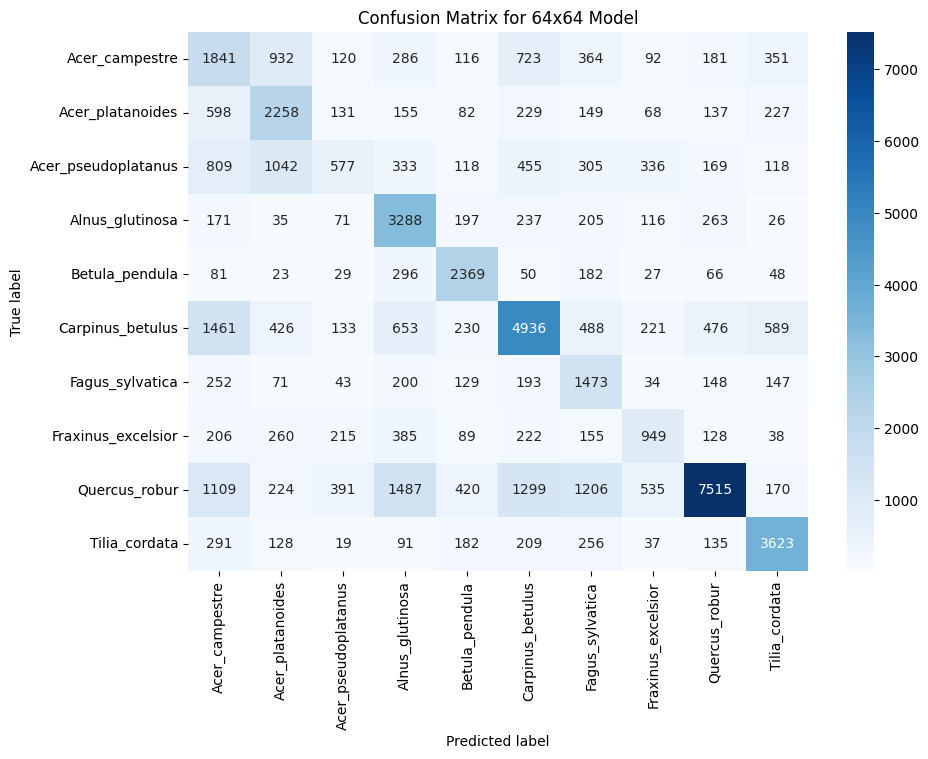

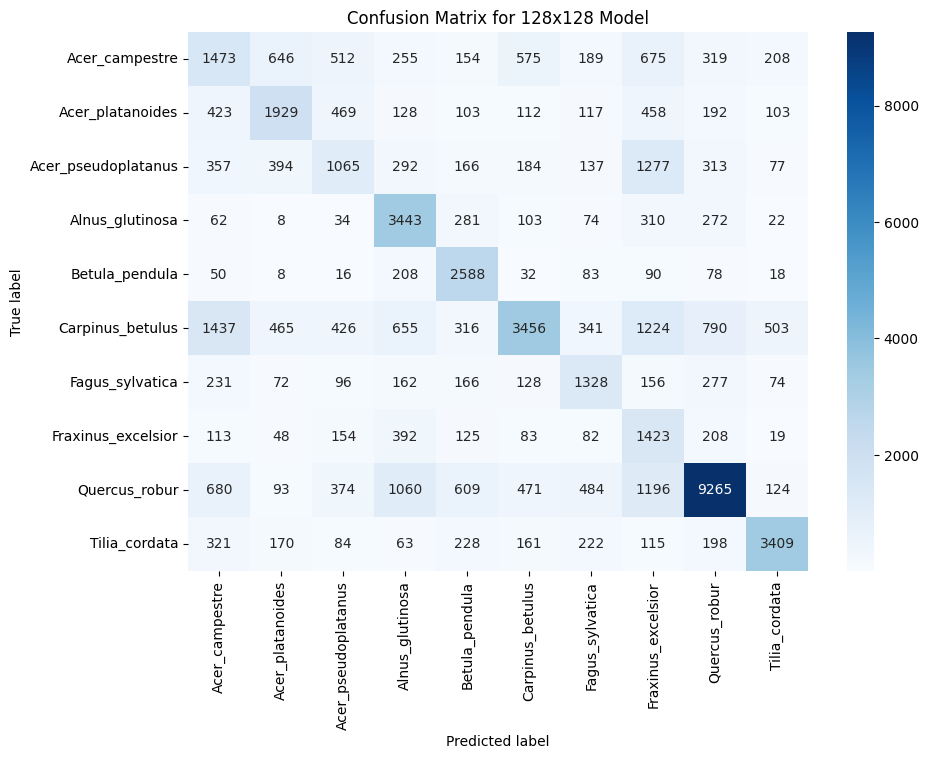

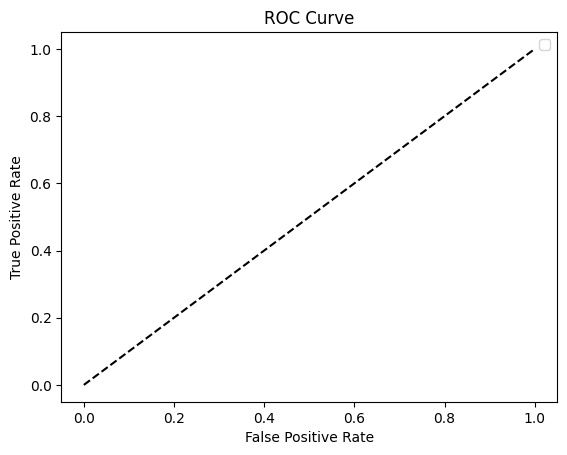

32x32 Model - Accuracy: 0.48474502790874113, Loss: [1.5588107109069824, 0.4847450256347656]
64x64 Model - Accuracy: 0.5207644646760238, Loss: [1.4668238162994385, 0.5207644701004028]
128x128 Model - Accuracy: 0.5306996152387146, Loss: [1.3962846994400024, 0.530699610710144]
32x32 Model - Classification Report:
1730/1730 [==============================] - 4s 2ms/step
              precision    recall  f1-score   support

           0       0.25      0.32      0.28      5006
           1       0.41      0.44      0.42      4034
           2       0.26      0.29      0.27      4262
           3       0.44      0.62      0.51      4609
           4       0.61      0.67      0.64      3171
           5       0.57      0.34      0.43      9613
           6       0.33      0.42      0.37      2690
           7       0.24      0.32      0.28      2647
           8       0.71      0.62      0.66     14356
           9       0.65      0.63      0.64      4971

    accuracy                       

In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, accuracy_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.image import resize
from pathlib import Path

# Load models
model_32 = tf.keras.models.load_model('/content/drive/MyDrive/MainDataFolder/AIModels/32x32_2500_combined_model.h5')
model_64 = tf.keras.models.load_model('/content/drive/MyDrive/MainDataFolder/AIModels/64x64_2500_combined_model.h5')
model_128 = tf.keras.models.load_model('/content/drive/MyDrive/MainDataFolder/AIModels/128x128_2500_combined_model.h5')

# Define paths
base_path_32 = "/content/drive/MyDrive/MainDataFolder/CombinedDataset32"
base_path_64 = "/content/drive/MyDrive/MainDataFolder/CombinedDataset64"
base_path_128 = "/content/drive/MyDrive/MainDataFolder/CombinedDataset"
kd_bh_path = "/content/drive/MyDrive/MainDataFolder/CombinedDataset"

species = ['Quercus_robur', 'Carpinus_betulus', 'Acer_campestre', 'Tilia_cordata',
           'Betula_pendula', 'Alnus_glutinosa', 'Acer_pseudoplatanus',
           'Fagus_sylvatica', 'Fraxinus_excelsior', 'Acer_platanoides']

def load_and_preprocess_data(base_path, kd_bh_path, species, target_size):
    images = []
    kds = []
    bhs = []
    labels = []
    for specie in species:
        print(f"Loading data for {specie} from {base_path}...")
        specie_images = np.load(Path(base_path) / f"{specie}_RGBI_combined.npy")
        specie_kds = np.load(Path(kd_bh_path) / f"{specie}_KD_combined.npy")
        specie_bhs = np.load(Path(kd_bh_path) / f"{specie}_BH_combined.npy")
        specie_labels = np.load(Path(base_path) / f"{specie}_label_combined.npy")

        # Append all instances
        images.append(specie_images)
        kds.append(specie_kds)
        bhs.append(specie_bhs)
        labels.append(specie_labels)

    images = np.concatenate(images)
    kds = np.concatenate(kds)
    bhs = np.concatenate(bhs)
    labels = np.concatenate(labels)
    images_resized = np.array([resize(img, target_size).numpy() / 255.0 for img in images])
    return images_resized, kds, bhs, labels

# Load and preprocess data for each resolution
print("Loading and preprocessing data...")
images_32, kds_32, bhs_32, labels = load_and_preprocess_data(base_path_32, kd_bh_path, species, (64, 64))  # Upsample 32x32 to 64x64
images_64, kds_64, bhs_64, _ = load_and_preprocess_data(base_path_64, kd_bh_path, species, (64, 64))  # Use 64x64 as they are
images_128, kds_128, bhs_128, _ = load_and_preprocess_data(base_path_128, kd_bh_path, species, (64, 64))  # Downsample 128x128 to 64x64

# Encode labels
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

# Print unique species and their counts
unique_species, counts = np.unique(labels_encoded, return_counts=True)
print(f"Number of unique species discovered: {len(unique_species)}")
for specie, count in zip(unique_species, counts):
    print(f"Species {label_encoder.inverse_transform([specie])[0]}: {count} samples")

print(f"Data loaded and preprocessed. Image shapes: 32x32 - {images_32.shape}, 64x64 - {images_64.shape}, 128x128 - {images_128.shape}")

# Evaluate models
def evaluate_model(model, images, kds, bhs, labels, batch_size=128):
    print(f"Evaluating model...")
    preds = []
    for i in range(0, len(images), batch_size):
        batch_preds = model.predict([images[i:i+batch_size], kds[i:i+batch_size], bhs[i:i+batch_size]])
        preds.append(batch_preds)
    preds = np.concatenate(preds)
    preds_labels = np.argmax(preds, axis=1)

    accuracy = accuracy_score(labels, preds_labels)
    loss = model.evaluate([images, kds, bhs], labels, batch_size=batch_size, verbose=0)
    cm = confusion_matrix(labels, preds_labels)
    report = classification_report(labels, preds_labels, output_dict=True)

    try:
        preds_norm = preds / np.sum(preds, axis=1, keepdims=True)
        roc_auc = roc_auc_score(labels, preds_norm, multi_class='ovr')
        fpr, tpr, _ = roc_curve(labels, preds_norm[:, 1], pos_label=1)
    except ValueError as e:
        print(f"ROC AUC calculation error: {e}")
        roc_auc = None
        fpr, tpr = None, None

    return accuracy, loss, cm, report, roc_auc, fpr, tpr

# Evaluate each model
print("Evaluating 32x32 model...")
accuracy_32, loss_32, cm_32, report_32, roc_auc_32, fpr_32, tpr_32 = evaluate_model(model_32, images_32, kds_32, bhs_32, labels_encoded)
print("Evaluating 64x64 model...")
accuracy_64, loss_64, cm_64, report_64, roc_auc_64, fpr_64, tpr_64 = evaluate_model(model_64, images_64, kds_64, bhs_64, labels_encoded)
print("Evaluating 128x128 model...")
accuracy_128, loss_128, cm_128, report_128, roc_auc_128, fpr_128, tpr_128 = evaluate_model(model_128, images_128, kds_128, bhs_128, labels_encoded)

# Visualize results
def plot_confusion_matrix(cm, title='Confusion Matrix'):
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.title(title)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.show()

plot_confusion_matrix(cm_32, title='Confusion Matrix for 32x32 Model')
plot_confusion_matrix(cm_64, title='Confusion Matrix for 64x64 Model')
plot_confusion_matrix(cm_128, title='Confusion Matrix for 128x128 Model')

# Plot ROC curve
plt.figure()
if fpr_32 is not None and tpr_32 is not None:
    plt.plot(fpr_32, tpr_32, label=f'32x32 model (area = {roc_auc_32:.2f})')
if fpr_64 is not None and tpr_64 is not None:
    plt.plot(fpr_64, tpr_64, label=f'64x64 model (area = {roc_auc_64:.2f})')
if fpr_128 is not None and tpr_128 is not None:
    plt.plot(fpr_128, tpr_128, label=f'128x128 model (area = {roc_auc_128:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()

# Print evaluation metrics
print(f"32x32 Model - Accuracy: {accuracy_32}, Loss: {loss_32}")
print(f"64x64 Model - Accuracy: {accuracy_64}, Loss: {loss_64}")
print(f"128x128 Model - Accuracy: {accuracy_128}, Loss: {loss_128}")

print("32x32 Model - Classification Report:")
print(classification_report(labels_encoded, np.argmax(model_32.predict([images_32, kds_32, bhs_32]), axis=1)))

print("64x64 Model - Classification Report:")
print(classification_report(labels_encoded, np.argmax(model_64.predict([images_64, kds_64, bhs_64]), axis=1)))

print("128x128 Model - Classification Report:")
print(classification_report(labels_encoded, np.argmax(model_128.predict([images_128, kds_128, bhs_128]), axis=1)))

print("Evaluation complete.")


##Evaluation with updated script for model comparison by taking only 2500 samples from each species that includes displaying the confusion matrix as a table

Loading and preprocessing data...
Loading data for Quercus_robur from /content/drive/MyDrive/MainDataFolder/CombinedDataset32...
Loading data for Carpinus_betulus from /content/drive/MyDrive/MainDataFolder/CombinedDataset32...
Loading data for Acer_campestre from /content/drive/MyDrive/MainDataFolder/CombinedDataset32...
Loading data for Tilia_cordata from /content/drive/MyDrive/MainDataFolder/CombinedDataset32...
Loading data for Betula_pendula from /content/drive/MyDrive/MainDataFolder/CombinedDataset32...
Loading data for Alnus_glutinosa from /content/drive/MyDrive/MainDataFolder/CombinedDataset32...
Loading data for Acer_pseudoplatanus from /content/drive/MyDrive/MainDataFolder/CombinedDataset32...
Loading data for Fagus_sylvatica from /content/drive/MyDrive/MainDataFolder/CombinedDataset32...
Loading data for Fraxinus_excelsior from /content/drive/MyDrive/MainDataFolder/CombinedDataset32...
Loading data for Acer_platanoides from /content/drive/MyDrive/MainDataFolder/CombinedDatase

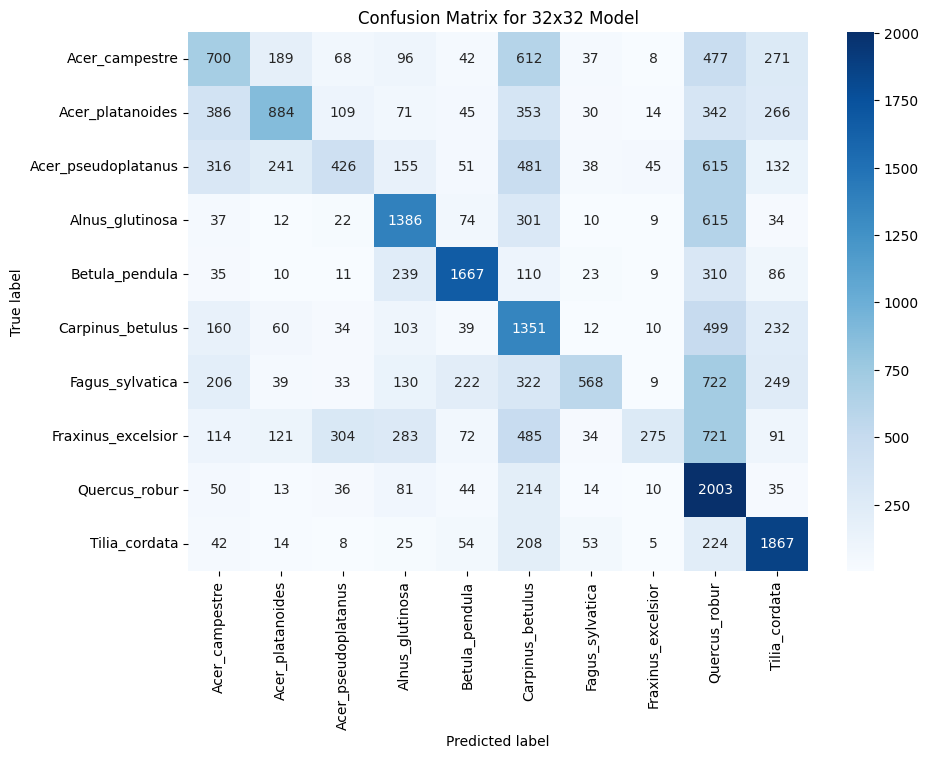

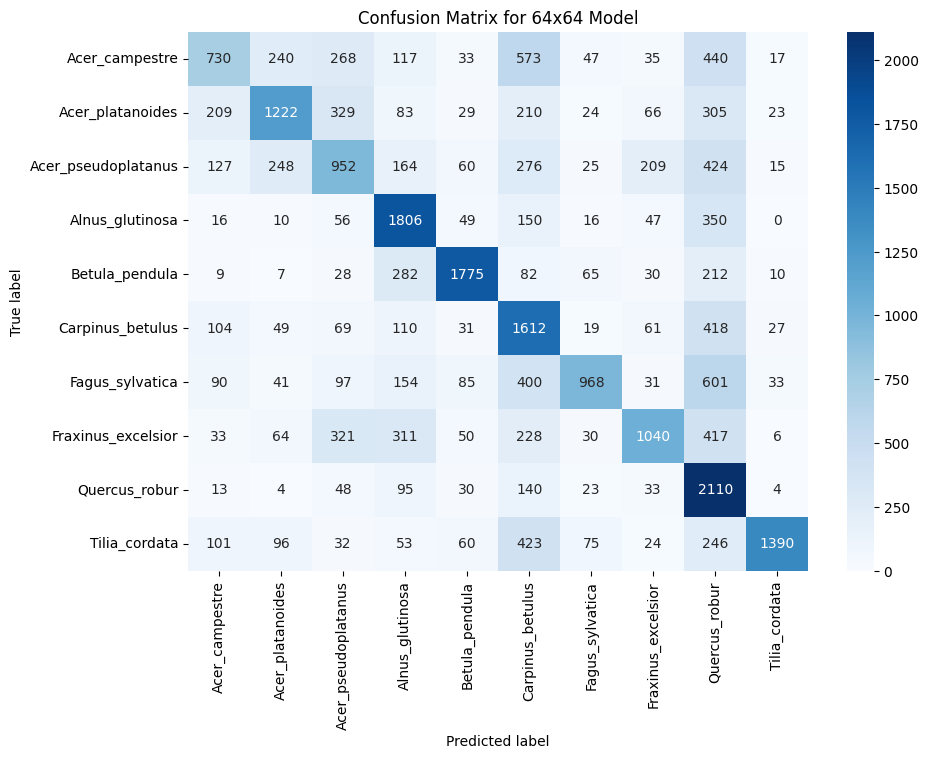

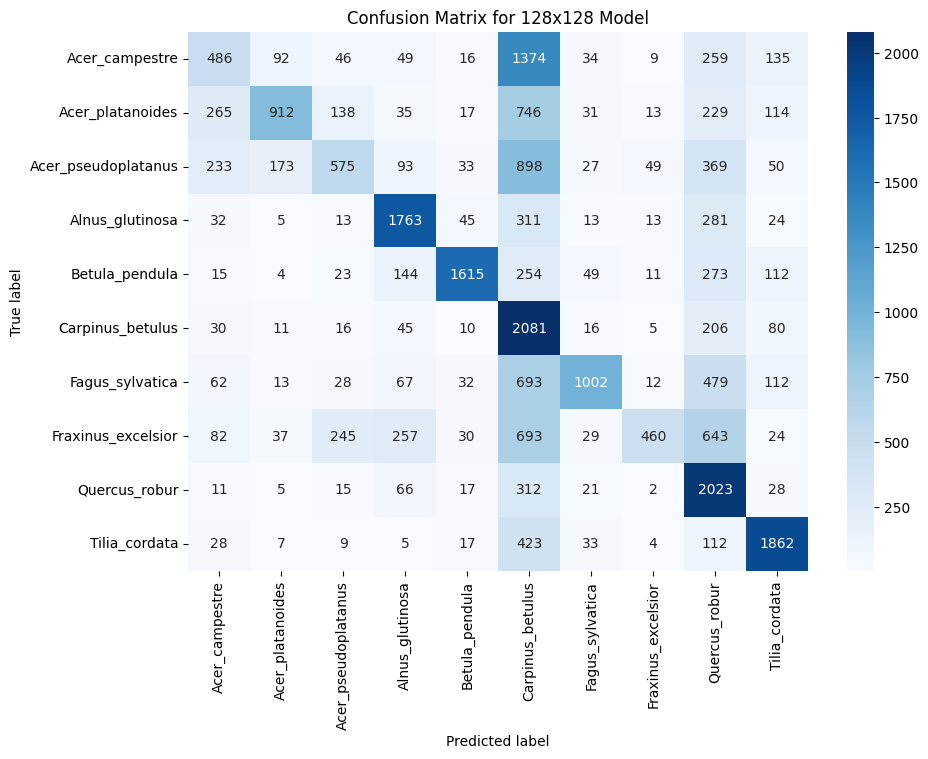

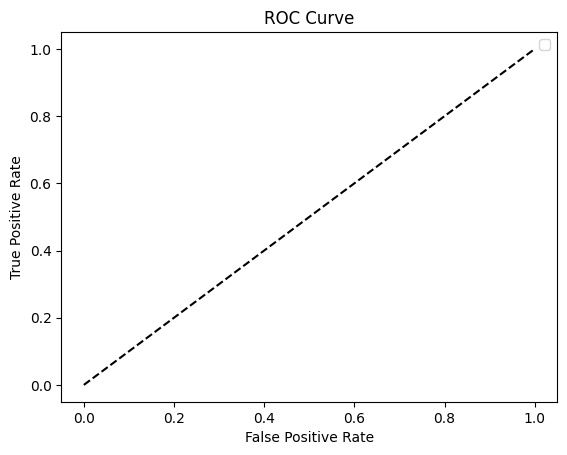

32x32 Model - Accuracy: 0.44508, Loss: [1.6212221384048462, 0.4450800120830536]
64x64 Model - Accuracy: 0.5442, Loss: [1.3747155666351318, 0.5442000031471252]
128x128 Model - Accuracy: 0.51116, Loss: [1.421398401260376, 0.5111600160598755]
32x32 Model - Classification Report:
782/782 [==============================] - 2s 2ms/step
              precision    recall  f1-score   support

           0       0.34      0.28      0.31      2500
           1       0.56      0.35      0.43      2500
           2       0.41      0.17      0.24      2500
           3       0.54      0.55      0.55      2500
           4       0.72      0.67      0.69      2500
           5       0.30      0.54      0.39      2500
           6       0.69      0.23      0.34      2500
           7       0.70      0.11      0.19      2500
           8       0.31      0.80      0.44      2500
           9       0.57      0.75      0.65      2500

    accuracy                           0.45     25000
   macro avg      

In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, accuracy_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.image import resize
from pathlib import Path

# Load models
model_32 = tf.keras.models.load_model('/content/drive/MyDrive/MainDataFolder/AIModels/32x32combined_model.h5')
model_64 = tf.keras.models.load_model('/content/drive/MyDrive/MainDataFolder/AIModels/64x64combined_model.h5')
model_128 = tf.keras.models.load_model('/content/drive/MyDrive/MainDataFolder/AIModels/128x128combined_model.h5')

# Define paths
base_path_32 = "/content/drive/MyDrive/MainDataFolder/CombinedDataset32"
base_path_64 = "/content/drive/MyDrive/MainDataFolder/CombinedDataset64"
base_path_128 = "/content/drive/MyDrive/MainDataFolder/CombinedDataset"
kd_bh_path = "/content/drive/MyDrive/MainDataFolder/CombinedDataset"

species = ['Quercus_robur', 'Carpinus_betulus', 'Acer_campestre', 'Tilia_cordata',
           'Betula_pendula', 'Alnus_glutinosa', 'Acer_pseudoplatanus',
           'Fagus_sylvatica', 'Fraxinus_excelsior', 'Acer_platanoides']

def load_and_preprocess_data(base_path, kd_bh_path, species, target_size, samples_per_class=2500):
    images = []
    kds = []
    bhs = []
    labels = []
    for specie in species:
        print(f"Loading data for {specie} from {base_path}...")
        specie_images = np.load(Path(base_path) / f"{specie}_RGBI_combined.npy")
        specie_kds = np.load(Path(kd_bh_path) / f"{specie}_KD_combined.npy")
        specie_bhs = np.load(Path(kd_bh_path) / f"{specie}_BH_combined.npy")
        specie_labels = np.load(Path(base_path) / f"{specie}_label_combined.npy")

        # Randomly sample 2500 instances
        indices = np.random.choice(len(specie_images), samples_per_class, replace=False)
        images.append(specie_images[indices])
        kds.append(specie_kds[indices])
        bhs.append(specie_bhs[indices])
        labels.append(specie_labels[indices])

    images = np.concatenate(images)
    kds = np.concatenate(kds)
    bhs = np.concatenate(bhs)
    labels = np.concatenate(labels)
    images_resized = np.array([resize(img, target_size).numpy() / 255.0 for img in images])
    return images_resized, kds, bhs, labels

# Load and preprocess data for each resolution
print("Loading and preprocessing data...")
images_32, kds_32, bhs_32, labels = load_and_preprocess_data(base_path_32, kd_bh_path, species, (64, 64))  # Upsample 32x32 to 64x64
images_64, kds_64, bhs_64, _ = load_and_preprocess_data(base_path_64, kd_bh_path, species, (64, 64))  # Use 64x64 as they are
images_128, kds_128, bhs_128, _ = load_and_preprocess_data(base_path_128, kd_bh_path, species, (64, 64))  # Downsample 128x128 to 64x64

# Encode labels
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

# Print unique species and their counts
unique_species, counts = np.unique(labels_encoded, return_counts=True)
print(f"Number of unique species discovered: {len(unique_species)}")
for specie, count in zip(unique_species, counts):
    print(f"Species {label_encoder.inverse_transform([specie])[0]}: {count} samples")

print(f"Data loaded and preprocessed. Image shapes: 32x32 - {images_32.shape}, 64x64 - {images_64.shape}, 128x128 - {images_128.shape}")

# Evaluate models
def evaluate_model(model, images, kds, bhs, labels, batch_size=128):
    print(f"Evaluating model...")
    preds = []
    for i in range(0, len(images), batch_size):
        batch_preds = model.predict([images[i:i+batch_size], kds[i:i+batch_size], bhs[i:i+batch_size]])
        preds.append(batch_preds)
    preds = np.concatenate(preds)
    preds_labels = np.argmax(preds, axis=1)

    accuracy = accuracy_score(labels, preds_labels)
    loss = model.evaluate([images, kds, bhs], labels, batch_size=batch_size, verbose=0)
    cm = confusion_matrix(labels, preds_labels)
    report = classification_report(labels, preds_labels, output_dict=True)

    try:
        preds_norm = preds / np.sum(preds, axis=1, keepdims=True)
        roc_auc = roc_auc_score(labels, preds_norm, multi_class='ovr')
        fpr, tpr, _ = roc_curve(labels, preds_norm[:, 1], pos_label=1)
    except ValueError as e:
        print(f"ROC AUC calculation error: {e}")
        roc_auc = None
        fpr, tpr = None, None

    return accuracy, loss, cm, report, roc_auc, fpr, tpr

# Evaluate each model
print("Evaluating 32x32 model...")
accuracy_32, loss_32, cm_32, report_32, roc_auc_32, fpr_32, tpr_32 = evaluate_model(model_32, images_32, kds_32, bhs_32, labels_encoded)
print("Evaluating 64x64 model...")
accuracy_64, loss_64, cm_64, report_64, roc_auc_64, fpr_64, tpr_64 = evaluate_model(model_64, images_64, kds_64, bhs_64, labels_encoded)
print("Evaluating 128x128 model...")
accuracy_128, loss_128, cm_128, report_128, roc_auc_128, fpr_128, tpr_128 = evaluate_model(model_128, images_128, kds_128, bhs_128, labels_encoded)

# Visualize results
def plot_confusion_matrix(cm, title='Confusion Matrix'):
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.title(title)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.show()

plot_confusion_matrix(cm_32, title='Confusion Matrix for 32x32 Model')
plot_confusion_matrix(cm_64, title='Confusion Matrix for 64x64 Model')
plot_confusion_matrix(cm_128, title='Confusion Matrix for 128x128 Model')

# Plot ROC curve
plt.figure()
if fpr_32 is not None and tpr_32 is not None:
    plt.plot(fpr_32, tpr_32, label=f'32x32 model (area = {roc_auc_32:.2f})')
if fpr_64 is not None and tpr_64 is not None:
    plt.plot(fpr_64, tpr_64, label=f'64x64 model (area = {roc_auc_64:.2f})')
if fpr_128 is not None and tpr_128 is not None:
    plt.plot(fpr_128, tpr_128, label=f'128x128 model (area = {roc_auc_128:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()

# Print evaluation metrics
print(f"32x32 Model - Accuracy: {accuracy_32}, Loss: {loss_32}")
print(f"64x64 Model - Accuracy: {accuracy_64}, Loss: {loss_64}")
print(f"128x128 Model - Accuracy: {accuracy_128}, Loss: {loss_128}")

print("32x32 Model - Classification Report:")
print(classification_report(labels_encoded, np.argmax(model_32.predict([images_32, kds_32, bhs_32]), axis=1)))

print("64x64 Model - Classification Report:")
print(classification_report(labels_encoded, np.argmax(model_64.predict([images_64, kds_64, bhs_64]), axis=1)))

print("128x128 Model - Classification Report:")
print(classification_report(labels_encoded, np.argmax(model_128.predict([images_128, kds_128, bhs_128]), axis=1)))

print("Evaluation complete.")


##Evaluation with updated script for model comparison for models trained with a fixed sample size of 2500 by taking only 2500 samples from each species that includes displaying the confusion matrix as a table

Loading and preprocessing data...
Loading data for Quercus_robur from /content/drive/MyDrive/MainDataFolder/CombinedDataset32...
Loading data for Carpinus_betulus from /content/drive/MyDrive/MainDataFolder/CombinedDataset32...
Loading data for Acer_campestre from /content/drive/MyDrive/MainDataFolder/CombinedDataset32...
Loading data for Tilia_cordata from /content/drive/MyDrive/MainDataFolder/CombinedDataset32...
Loading data for Betula_pendula from /content/drive/MyDrive/MainDataFolder/CombinedDataset32...
Loading data for Alnus_glutinosa from /content/drive/MyDrive/MainDataFolder/CombinedDataset32...
Loading data for Acer_pseudoplatanus from /content/drive/MyDrive/MainDataFolder/CombinedDataset32...
Loading data for Fagus_sylvatica from /content/drive/MyDrive/MainDataFolder/CombinedDataset32...
Loading data for Fraxinus_excelsior from /content/drive/MyDrive/MainDataFolder/CombinedDataset32...
Loading data for Acer_platanoides from /content/drive/MyDrive/MainDataFolder/CombinedDatase

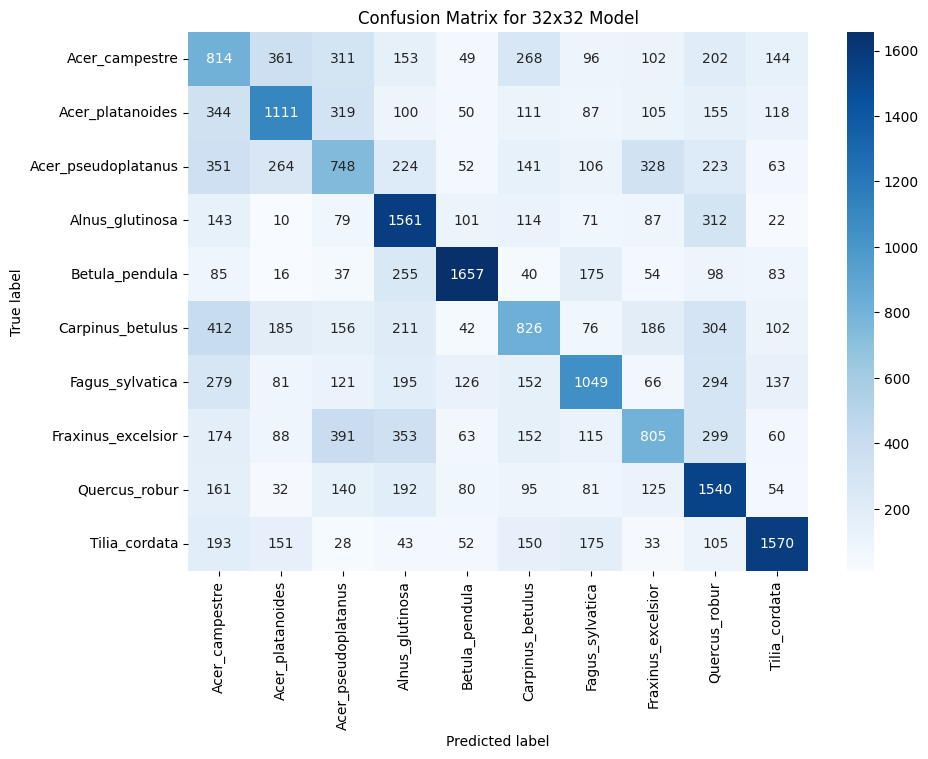

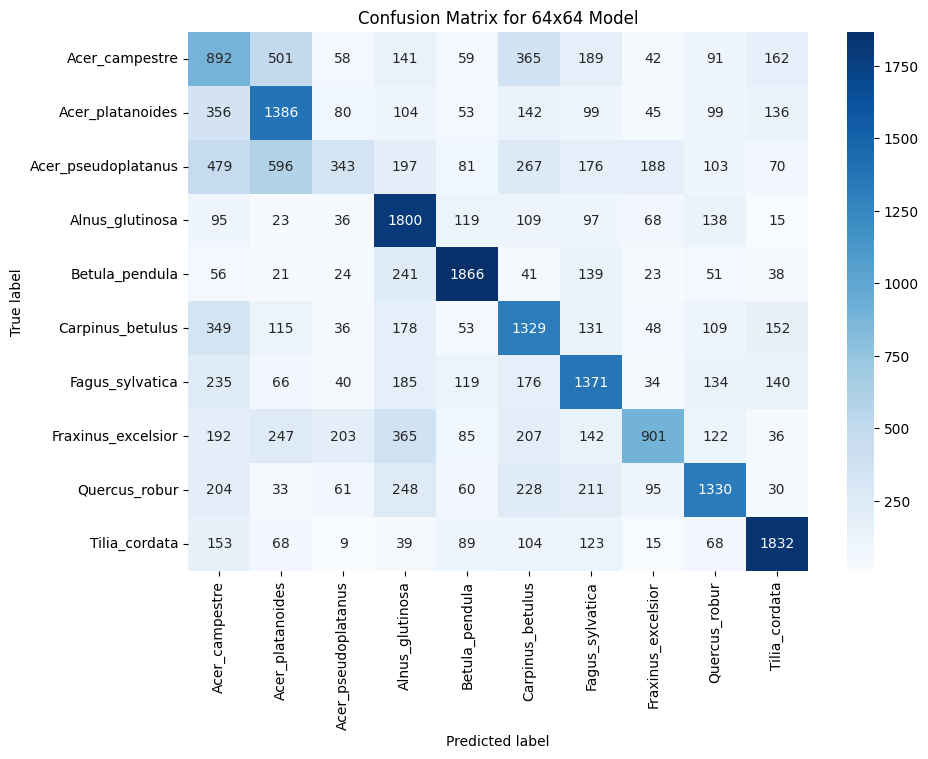

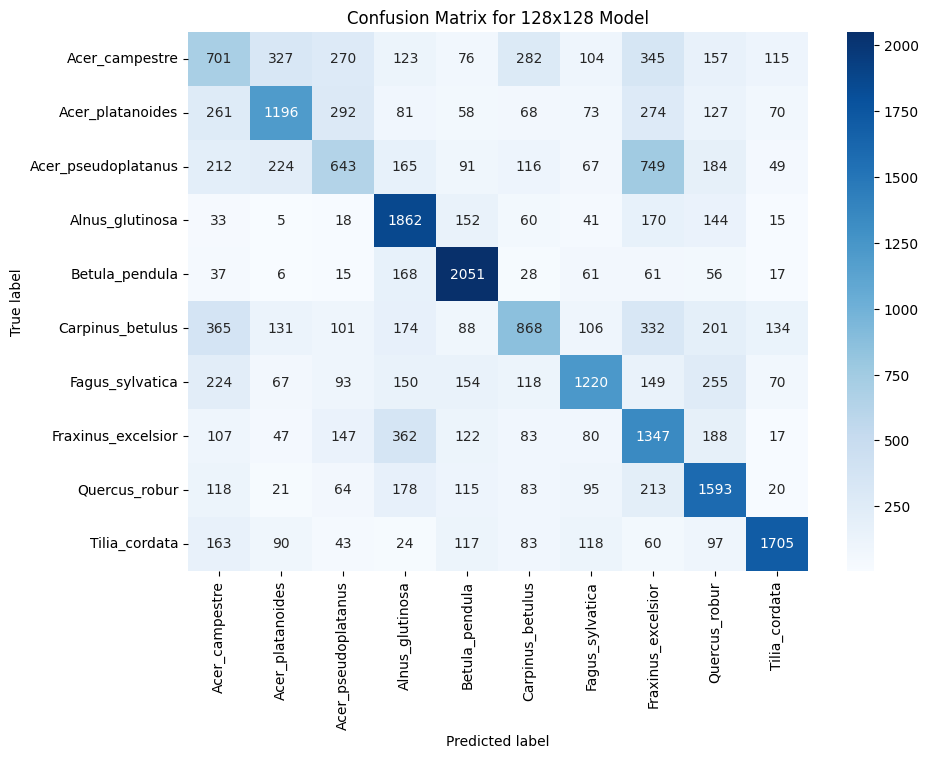

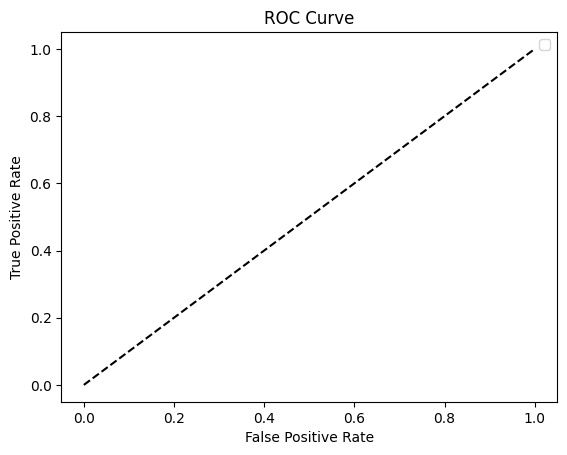

32x32 Model - Accuracy: 0.46724, Loss: [1.577553391456604, 0.46724000573158264]
64x64 Model - Accuracy: 0.522, Loss: [1.4246044158935547, 0.5220000147819519]
128x128 Model - Accuracy: 0.52744, Loss: [1.3757281303405762, 0.5274400115013123]
32x32 Model - Classification Report:
782/782 [==============================] - 2s 2ms/step
              precision    recall  f1-score   support

           0       0.28      0.33      0.30      2500
           1       0.48      0.44      0.46      2500
           2       0.32      0.30      0.31      2500
           3       0.47      0.62      0.54      2500
           4       0.73      0.66      0.69      2500
           5       0.40      0.33      0.36      2500
           6       0.52      0.42      0.46      2500
           7       0.43      0.32      0.37      2500
           8       0.44      0.62      0.51      2500
           9       0.67      0.63      0.65      2500

    accuracy                           0.47     25000
   macro avg      

In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, accuracy_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.image import resize
from pathlib import Path

# Load models
model_32 = tf.keras.models.load_model('/content/drive/MyDrive/MainDataFolder/AIModels/32x32_2500_combined_model.h5')
model_64 = tf.keras.models.load_model('/content/drive/MyDrive/MainDataFolder/AIModels/64x64_2500_combined_model.h5')
model_128 = tf.keras.models.load_model('/content/drive/MyDrive/MainDataFolder/AIModels/128x128_2500_combined_model.h5')

# Define paths
base_path_32 = "/content/drive/MyDrive/MainDataFolder/CombinedDataset32"
base_path_64 = "/content/drive/MyDrive/MainDataFolder/CombinedDataset64"
base_path_128 = "/content/drive/MyDrive/MainDataFolder/CombinedDataset"
kd_bh_path = "/content/drive/MyDrive/MainDataFolder/CombinedDataset"

species = ['Quercus_robur', 'Carpinus_betulus', 'Acer_campestre', 'Tilia_cordata',
           'Betula_pendula', 'Alnus_glutinosa', 'Acer_pseudoplatanus',
           'Fagus_sylvatica', 'Fraxinus_excelsior', 'Acer_platanoides']

def load_and_preprocess_data(base_path, kd_bh_path, species, target_size, samples_per_class=2500):
    images = []
    kds = []
    bhs = []
    labels = []
    for specie in species:
        print(f"Loading data for {specie} from {base_path}...")
        specie_images = np.load(Path(base_path) / f"{specie}_RGBI_combined.npy")
        specie_kds = np.load(Path(kd_bh_path) / f"{specie}_KD_combined.npy")
        specie_bhs = np.load(Path(kd_bh_path) / f"{specie}_BH_combined.npy")
        specie_labels = np.load(Path(base_path) / f"{specie}_label_combined.npy")

        # Randomly sample 2500 instances
        indices = np.random.choice(len(specie_images), samples_per_class, replace=False)
        images.append(specie_images[indices])
        kds.append(specie_kds[indices])
        bhs.append(specie_bhs[indices])
        labels.append(specie_labels[indices])

    images = np.concatenate(images)
    kds = np.concatenate(kds)
    bhs = np.concatenate(bhs)
    labels = np.concatenate(labels)
    images_resized = np.array([resize(img, target_size).numpy() / 255.0 for img in images])
    return images_resized, kds, bhs, labels

# Load and preprocess data for each resolution
print("Loading and preprocessing data...")
images_32, kds_32, bhs_32, labels = load_and_preprocess_data(base_path_32, kd_bh_path, species, (64, 64))  # Upsample 32x32 to 64x64
images_64, kds_64, bhs_64, _ = load_and_preprocess_data(base_path_64, kd_bh_path, species, (64, 64))  # Use 64x64 as they are
images_128, kds_128, bhs_128, _ = load_and_preprocess_data(base_path_128, kd_bh_path, species, (64, 64))  # Downsample 128x128 to 64x64

# Encode labels
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

# Print unique species and their counts
unique_species, counts = np.unique(labels_encoded, return_counts=True)
print(f"Number of unique species discovered: {len(unique_species)}")
for specie, count in zip(unique_species, counts):
    print(f"Species {label_encoder.inverse_transform([specie])[0]}: {count} samples")

print(f"Data loaded and preprocessed. Image shapes: 32x32 - {images_32.shape}, 64x64 - {images_64.shape}, 128x128 - {images_128.shape}")

# Evaluate models
def evaluate_model(model, images, kds, bhs, labels, batch_size=128):
    print(f"Evaluating model...")
    preds = []
    for i in range(0, len(images), batch_size):
        batch_preds = model.predict([images[i:i+batch_size], kds[i:i+batch_size], bhs[i:i+batch_size]])
        preds.append(batch_preds)
    preds = np.concatenate(preds)
    preds_labels = np.argmax(preds, axis=1)

    accuracy = accuracy_score(labels, preds_labels)
    loss = model.evaluate([images, kds, bhs], labels, batch_size=batch_size, verbose=0)
    cm = confusion_matrix(labels, preds_labels)
    report = classification_report(labels, preds_labels, output_dict=True)

    try:
        preds_norm = preds / np.sum(preds, axis=1, keepdims=True)
        roc_auc = roc_auc_score(labels, preds_norm, multi_class='ovr')
        fpr, tpr, _ = roc_curve(labels, preds_norm[:, 1], pos_label=1)
    except ValueError as e:
        print(f"ROC AUC calculation error: {e}")
        roc_auc = None
        fpr, tpr = None, None

    return accuracy, loss, cm, report, roc_auc, fpr, tpr

# Evaluate each model
print("Evaluating 32x32 model...")
accuracy_32, loss_32, cm_32, report_32, roc_auc_32, fpr_32, tpr_32 = evaluate_model(model_32, images_32, kds_32, bhs_32, labels_encoded)
print("Evaluating 64x64 model...")
accuracy_64, loss_64, cm_64, report_64, roc_auc_64, fpr_64, tpr_64 = evaluate_model(model_64, images_64, kds_64, bhs_64, labels_encoded)
print("Evaluating 128x128 model...")
accuracy_128, loss_128, cm_128, report_128, roc_auc_128, fpr_128, tpr_128 = evaluate_model(model_128, images_128, kds_128, bhs_128, labels_encoded)

# Visualize results
def plot_confusion_matrix(cm, title='Confusion Matrix'):
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.title(title)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.show()

plot_confusion_matrix(cm_32, title='Confusion Matrix for 32x32 Model')
plot_confusion_matrix(cm_64, title='Confusion Matrix for 64x64 Model')
plot_confusion_matrix(cm_128, title='Confusion Matrix for 128x128 Model')

# Plot ROC curve
plt.figure()
if fpr_32 is not None and tpr_32 is not None:
    plt.plot(fpr_32, tpr_32, label=f'32x32 model (area = {roc_auc_32:.2f})')
if fpr_64 is not None and tpr_64 is not None:
    plt.plot(fpr_64, tpr_64, label=f'64x64 model (area = {roc_auc_64:.2f})')
if fpr_128 is not None and tpr_128 is not None:
    plt.plot(fpr_128, tpr_128, label=f'128x128 model (area = {roc_auc_128:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()

# Print evaluation metrics
print(f"32x32 Model - Accuracy: {accuracy_32}, Loss: {loss_32}")
print(f"64x64 Model - Accuracy: {accuracy_64}, Loss: {loss_64}")
print(f"128x128 Model - Accuracy: {accuracy_128}, Loss: {loss_128}")

print("32x32 Model - Classification Report:")
print(classification_report(labels_encoded, np.argmax(model_32.predict([images_32, kds_32, bhs_32]), axis=1)))

print("64x64 Model - Classification Report:")
print(classification_report(labels_encoded, np.argmax(model_64.predict([images_64, kds_64, bhs_64]), axis=1)))

print("128x128 Model - Classification Report:")
print(classification_report(labels_encoded, np.argmax(model_128.predict([images_128, kds_128, bhs_128]), axis=1)))

print("Evaluation complete.")


##Notes

Based on the provided confusion matrices, here are some observations:

### Models Trained with 2500 Samples per Species

1. **32x32 Model:**
   - **Overall Performance:** The performance is relatively moderate with significant misclassifications across different species.
   - **Best Performance:** Species like **Alnus_glutinosa**, **Betula_pendula**, and **Quercus_robur** show better performance with higher true positive rates.
   - **Misclassifications:** There is notable **confusion** between **Acer_campestre** and **Acer_platanoides**, and between **Carpinus_betulus** and **Fagus_sylvatica**.

2. **64x64 Model:**
   - **Overall Performance:** The performance is slightly improved compared to the 32x32 model with better class separation.
   - **Best Performance:** **Tilia_cordata** and **Alnus_glutinosa** show high accuracy.
   - **Misclassifications:** **Acer_campestre** and **Acer_platanoides** still exhibit confusion, but less than in the 32x32 model.

3. **128x128 Model:**
   - **Overall Performance:** This model shows the best overall performance among the three with higher correct predictions.
   - **Best Performance:** **Tilia_cordata**, **Betula_pendula**, and **Quercus_robur** show strong performance with high true positive rates.
   - **Misclassifications:** The misclassifications are less frequent but still present, especially between **Acer_pseudoplatanus** and **Acer_platanoides**.

### Models Trained with Different Sample Sizes

1. **32x32 Model:**
   - **Overall Performance:** The performance is generally weaker than when using 2500 samples per species.
   - **Best Performance:** **Quercus_robur** and **Tilia_cordata** show relatively better performance.
   - **Misclassifications:** Significant misclassifications are observed, especially between **Carpinus_betulus** and **Fagus_sylvatica**.

2. **64x64 Model:**
   - **Overall Performance:** This model shows improved performance compared to the 32x32 model but still not as good as when using 2500 samples per species.
   - **Best Performance:** **Tilia_cordata** and **Alnus_glutinosa** again show high accuracy.
   - **Misclassifications:** There is confusion between **Acer_campestre** and **Acer_platanoides**, similar to the 2500 sample model.

3. **128x128 Model:**
   - **Overall Performance:** This model has the best performance among the three different sample size models.
   - **Best Performance:** **Tilia_cordata** and **Quercus_robur** show very strong performance with high true positive rates.
   - **Misclassifications:** Misclassifications are fewer but still present, especially between **Acer_pseudoplatanus** and **Acer_platanoides**.

### General Observations:

- **Sample Size Impact:** Models trained with a uniform sample size of 2500 per species generally perform better than models trained with varying sample sizes. This uniformity likely contributes to more balanced learning across species.
- **Resolution Impact:** Higher resolution models (128x128) tend to perform better than lower resolution models (32x32), likely due to capturing more detailed features in the images.
- **Species-Specific Performance:** Certain species like **Tilia_cordata** and **Alnus_glutinosa** consistently show high accuracy across different models and sample sizes, indicating that these species may have more distinctive features.
- **Common Confusions:** There are consistent misclassification patterns between certain species, suggesting that these species might have similar features or that the models need more data or different feature extraction techniques to distinguish them accurately.

These observations can help guide future improvements in the models, such as exploring different feature extraction methods, data augmentation strategies, or using ensemble methods to improve classification performance further.

##Failed Tests

## 128x128 images directly without downsizing to 64x64
## However, using larger image sizes will also increase the computational cost and memory usage during training and inference. It's crucial to ensure that your hardware can handle the increased demand.


#-------------->  TEST FAILED  <-----------------


In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from pathlib import Path
from tensorflow.image import resize

# Set up GPU memory growth
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

# Enable mixed precision training
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

# Define paths
base_path = "/content/drive/MyDrive/MainDataFolder/CombinedDataset"
species = ['Quercus_robur', 'Carpinus_betulus', 'Acer_campestre', 'Tilia_cordata',
           'Betula_pendula', 'Alnus_glutinosa', 'Acer_pseudoplatanus',
           'Fagus_sylvatica', 'Fraxinus_excelsior', 'Acer_platanoides']

# Load data from .npy files
def load_data():
    images = []
    kds = []
    bhs = []
    labels = []
    for specie in species:
        print(f"Loading data for {specie}...")
        images.append(np.load(Path(base_path) / f"{specie}_RGBI_combined.npy"))
        kds.append(np.load(Path(base_path) / f"{specie}_KD_combined.npy"))
        bhs.append(np.load(Path(base_path) / f"{specie}_BH_combined.npy"))
        labels.append(np.load(Path(base_path) / f"{specie}_label_combined.npy"))
    images = np.concatenate(images)
    kds = np.concatenate(kds)
    bhs = np.concatenate(bhs)
    labels = np.concatenate(labels)
    return images, kds, bhs, labels

# Load combined data
print("Loading combined data...")
rgb_images, kd_values, bh_values, labels = load_data()
print(f"Loaded {len(rgb_images)} images with shape {rgb_images.shape}.")

# Assuming the images are already in 128x128 format. If not, resize them:
# rgb_images_resized = np.array([resize(img, [128, 128]).numpy() for img in rgb_images])

# Split data into training and testing sets
print("Splitting data into training and testing sets...")
X_train_img, X_test_img, y_train, y_test = train_test_split(rgb_images, labels, test_size=0.2, random_state=42)  # Use rgb_images directly if they're already resized
X_train_kd, X_test_kd = train_test_split(kd_values, test_size=0.2, random_state=42)
X_train_bh, X_test_bh = train_test_split(bh_values, test_size=0.2, random_state=42)

# Normalize the images
X_train_img = X_train_img.astype('float32') / 255.0
X_test_img = X_test_img.astype('float32') / 255.0

# Ensure labels are in the correct format
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

print(f"Data splitting completed. Training set size: {len(X_train_img)}, Testing set size: {len(X_test_img)}")


print(f"Shape of X_train_img: {X_train_img.shape}")
print(f"Shape of X_train_kd: {X_train_kd.shape}")
print(f"Shape of X_train_bh: {X_train_bh.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of X_test_img: {X_test_img.shape}")
print(f"Shape of X_test_kd: {X_test_kd.shape}")
print(f"Shape of X_test_bh: {X_test_bh.shape}")
print(f"Shape of y_test: {y_test.shape}")

# Normalize the images
X_train_img = X_train_img.astype('float32') / 255.0
X_test_img = X_test_img.astype('float32') / 255.0

# Ensure labels are in the correct format
y_train = y_train.astype('int32')
y_test = y_test.astype('int32')

print(f"Data type of X_train_img: {X_train_img.dtype}")
print(f"Data type of X_train_kd: {X_train_kd.dtype}")
print(f"Data type of X_train_bh: {X_train_bh.dtype}")
print(f"Data type of y_train: {y_train.dtype}")
print(f"Data type of X_test_img: {X_test_img.dtype}")
print(f"Data type of X_test_kd: {X_test_kd.dtype}")
print(f"Data type of X_test_bh: {X_test_bh.dtype}")
print(f"Data type of y_test: {y_test.dtype}")

# Check for NaN and Inf values
print(f"Any NaN values in X_train_img: {np.isnan(X_train_img).any()}")
print(f"Any Inf values in X_train_img: {np.isinf(X_train_img).any()}")
print(f"Any NaN values in X_train_kd: {np.isnan(X_train_kd).any()}")
print(f"Any Inf values in X_train_kd: {np.isinf(X_train_kd).any()}")
print(f"Any NaN values in X_train_bh: {np.isnan(X_train_bh).any()}")
print(f"Any Inf values in X_train_bh: {np.isinf(X_train_bh).any()}")
print(f"Any NaN values in y_train: {np.isnan(y_train).any()}")
print(f"Any Inf values in y_train: {np.isinf(y_train).any()}")

# Define a CNN model that also takes KD and BH as inputs
def combined_model(input_image_size=(128, 128, 4), input_kd_size=(1,), input_bh_size=(1,), num_classes=10):
    # Image input branch
    image_input = Input(shape=input_image_size, name='image_input')
    x = Conv2D(32, (3, 3), activation='relu')(image_input)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu')(x)
    x = GlobalAveragePooling2D()(x)

    # KD and BH input branches
    kd_input = Input(shape=input_kd_size, name='kd_input')
    bh_input = Input(shape=input_bh_size, name='bh_input')

    # Combine branches
    combined = Concatenate()([x, kd_input, bh_input])
    combined = Dense(128, activation='relu')(combined)
    combined = Dropout(0.5)(combined)
    output = Dense(num_classes, activation='softmax')(combined)

    # Model definition
    model = Model(inputs=[image_input, kd_input, bh_input], outputs=output)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Create and train the model
input_image_size = X_train_img.shape[1:]  # This will automatically set to (128, 128, 4) if your images are correctly formatted
input_kd_size = (1,)
input_bh_size = (1,)
num_classes = len(np.unique(y_train))
print(f"Creating model with input sizes {input_image_size}, {input_kd_size}, {input_bh_size} and {num_classes} classes...")
model = combined_model(input_image_size=input_image_size, input_kd_size=input_kd_size, input_bh_size=input_bh_size, num_classes=num_classes)
model.summary()

checkpoint_filepath = '/content/drive/MyDrive/MainDataFolder/checkpoints/combined_model_checkpoint.h5'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True
)

early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

print("Training model...")
try:
    history = model.fit(
        [X_train_img, X_train_kd, X_train_bh], y_train,
        validation_data=([X_test_img, X_test_kd, X_test_bh], y_test),
        epochs=50, batch_size=32,
        callbacks=[model_checkpoint_callback, early_stopping_callback]
    )
    print("Model training completed.")
except tf.errors.InvalidArgumentError as e:
    print(f"Error during training: {e}")

# Save the model
model_save_path = "/content/drive/MyDrive/MainDataFolder/combined_model.h5"
model.save(model_save_path)
print(f"Model saved as {model_save_path}")


1 Physical GPUs, 1 Logical GPUs
Loading combined data...
Loading data for Quercus_robur...
Loading data for Carpinus_betulus...
Loading data for Acer_campestre...
Loading data for Tilia_cordata...
Loading data for Betula_pendula...
Loading data for Alnus_glutinosa...
Loading data for Acer_pseudoplatanus...
Loading data for Fagus_sylvatica...
Loading data for Fraxinus_excelsior...
Loading data for Acer_platanoides...
Loaded 55359 images with shape (55359, 128, 128, 4).
Splitting data into training and testing sets...
Data splitting completed. Training set size: 44287, Testing set size: 11072
Shape of X_train_img: (44287, 128, 128, 4)
Shape of X_train_kd: (44287,)
Shape of X_train_bh: (44287,)
Shape of y_train: (44287,)
Shape of X_test_img: (11072, 128, 128, 4)
Shape of X_test_kd: (11072,)
Shape of X_test_bh: (11072,)
Shape of y_test: (11072,)
Data type of X_train_img: float32
Data type of X_train_kd: float64
Data type of X_train_bh: float64
Data type of y_train: int32
Data type of X_tes

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

##Test

In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, accuracy_score
from sklearn.preprocessing import LabelEncoder, label_binarize
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from itertools import cycle

# Load models
model_32 = tf.keras.models.load_model('/content/drive/MyDrive/MainDataFolder/AIModels/32x32_2500_combined_model.h5')
model_64 = tf.keras.models.load_model('/content/drive/MyDrive/MainDataFolder/AIModels/64x64_2500_combined_model.h5')
model_128 = tf.keras.models.load_model('/content/drive/MyDrive/MainDataFolder/AIModels/128x128_2500_combined_model.h5')

# Define paths
base_path_32 = "/content/drive/MyDrive/MainDataFolder/CombinedDataset32"
base_path_64 = "/content/drive/MyDrive/MainDataFolder/CombinedDataset64"
base_path_128 = "/content/drive/MyDrive/MainDataFolder/CombinedDataset"
kd_bh_path = "/content/drive/MyDrive/MainDataFolder/CombinedDataset"

species = ['Quercus_robur', 'Carpinus_betulus', 'Acer_campestre', 'Tilia_cordata',
           'Betula_pendula', 'Alnus_glutinosa', 'Acer_pseudoplatanus',
           'Fagus_sylvatica', 'Fraxinus_excelsior', 'Acer_platanoides']

def load_and_preprocess_data(base_path, kd_bh_path, species):
    images = []
    kds = []
    bhs = []
    labels = []
    for specie in species:
        print(f"Loading data for {specie} from {base_path}...")
        specie_images = np.load(Path(base_path) / f"{specie}_RGBI_combined.npy")
        specie_kds = np.load(Path(kd_bh_path) / f"{specie}_KD_combined.npy")
        specie_bhs = np.load(Path(kd_bh_path) / f"{specie}_BH_combined.npy")
        specie_labels = np.load(Path(base_path) / f"{specie}_label_combined.npy")

        images.append(specie_images)
        kds.append(specie_kds)
        bhs.append(specie_bhs)
        labels.append(specie_labels)

    images = np.concatenate(images)
    kds = np.concatenate(kds)
    bhs = np.concatenate(bhs)
    labels = np.concatenate(labels)
    images_normalized = images.astype('float32') / 255.0
    return images_normalized, kds, bhs, labels

# Load and preprocess data for each resolution
print("Loading and preprocessing data for 32x32 model...")
images_32, kds_32, bhs_32, labels = load_and_preprocess_data(base_path_32, kd_bh_path, species)
print("Loading and preprocessing data for 64x64 model...")
images_64, kds_64, bhs_64, _ = load_and_preprocess_data(base_path_64, kd_bh_path, species)
print("Loading and preprocessing data for 128x128 model...")
images_128, kds_128, bhs_128, _ = load_and_preprocess_data(base_path_128, kd_bh_path, species)

# Encode labels
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

# Print unique species and their counts
unique_species, counts = np.unique(labels_encoded, return_counts=True)
print(f"Number of unique species discovered: {len(unique_species)}")
for specie, count in zip(unique_species, counts):
    print(f"Species {label_encoder.inverse_transform([specie])[0]}: {count} samples")

print(f"Data loaded and preprocessed. Image shapes: 32x32 - {images_32.shape}, 64x64 - {images_64.shape}, 128x128 - {images_128.shape}")

# Binarize labels for multiclass ROC AUC calculation
labels_binarized = label_binarize(labels_encoded, classes=range(len(species)))

# Evaluate models
def evaluate_model(model, images, kds, bhs, labels, batch_size=128):
    print(f"Evaluating model...")
    preds = []
    for i in range(0, len(images), batch_size):
        batch_preds = model.predict([images[i:i+batch_size], kds[i:i+batch_size], bhs[i:i+batch_size]])
        preds.append(batch_preds)
    preds = np.concatenate(preds)
    preds_labels = np.argmax(preds, axis=1)

    accuracy = accuracy_score(labels, preds_labels)
    loss = model.evaluate([images, kds, bhs], labels, batch_size=batch_size, verbose=0)
    cm = confusion_matrix(labels, preds_labels)
    report = classification_report(labels, preds_labels, output_dict=True)

    try:
        preds_norm = preds / np.sum(preds, axis=1, keepdims=True)
        roc_auc = roc_auc_score(labels_binarized, preds_norm, multi_class='ovr')
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(len(species)):
            fpr[i], tpr[i], _ = roc_curve(labels_binarized[:, i], preds_norm[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])
    except ValueError as e:
        print(f"ROC AUC calculation error: {e}")
        roc_auc = None
        fpr, tpr = None, None

    return accuracy, loss, cm, report, roc_auc, fpr, tpr

# Evaluate each model
print("Evaluating 32x32 model...")
accuracy_32, loss_32, cm_32, report_32, roc_auc_32, fpr_32, tpr_32 = evaluate_model(model_32, images_32, kds_32, bhs_32, labels_encoded)
print("Evaluating 64x64 model...")
accuracy_64, loss_64, cm_64, report_64, roc_auc_64, fpr_64, tpr_64 = evaluate_model(model_64, images_64, kds_64, bhs_64, labels_encoded)
print("Evaluating 128x128 model...")
accuracy_128, loss_128, cm_128, report_128, roc_auc_128, fpr_128, tpr_128 = evaluate_model(model_128, images_128, kds_128, bhs_128, labels_encoded)

# Visualize results
def plot_confusion_matrix(cm, title='Confusion Matrix'):
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.title(title)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.show()

plot_confusion_matrix(cm_32, title='Confusion Matrix for 32x32 Model')
plot_confusion_matrix(cm_64, title='Confusion Matrix for 64x64 Model')
plot_confusion_matrix(cm_128, title='Confusion Matrix for 128x128 Model')

# Plot ROC curve for multiclass
plt.figure()
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(len(species)), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'ROC curve of class {i} (area = {roc_auc[i]:0.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="best")
plt.show()

# Print evaluation metrics
print(f"32x32 Model - Accuracy: {accuracy_32}, Loss: {loss_32}")
print(f"64x64 Model - Accuracy: {accuracy_64}, Loss: {loss_64}")
print(f"128x128 Model - Accuracy: {accuracy_128}, Loss: {loss_128}")

print("32x32 Model - Classification Report:")
print(classification_report(labels_encoded, np.argmax(model_32.predict([images_32, kds_32, bhs_32]), axis=1)))

print("64x64 Model - Classification Report:")
print(classification_report(labels_encoded, np.argmax(model_64.predict([images_64, kds_64, bhs_64]), axis=1)))

print("128x128 Model - Classification Report:")
print(classification_report(labels_encoded, np.argmax(model_128.predict([images_128, kds_128, bhs_128]), axis=1)))

print("Evaluation complete.")
